In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for plotting

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

# Library to do time series decomposition
import statsmodels.api as sm

# For tuning the model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import hp, fmin, tpe, space_eval
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.base import clone
from scipy.stats import uniform, randint
# For implementing K-Fold cross-validation.
from surprise.model_selection import KFold

# Used to ignore the warning given as output of the code.
#import warnings
#warnings.filterwarnings('ignore')

In [45]:
#path='/kaggle/input/playground-series-s5e1/'
path='../Data/'
ID, DATE, COUNTRY, STORE, PRODUCT, NUM_SOLD = ('id', 'date', 'country', 'store', 'product', 'num_sold')
columns = (ID, DATE, COUNTRY, STORE, PRODUCT, NUM_SOLD)
train_df = pd.read_csv(
    path + 'train.csv',                                # Path to input file.
    header = 0,                                        # Strictly not needed, but ...
    names = columns,                                   # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns,                                 # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    parse_dates = [DATE],                              # Parse date objects.
    date_format = "%Y-%m-%d",                          # assume this form of date string in data.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
test_df = pd.read_csv(
    path + 'test.csv',                                 # Path to input file.
    header = 0,                                        # Strictly not needed, but ...
    names = columns[:-1],                              # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns[:-1],                            # Specify colomns to import (NUM_SOLD not available in testset).
    skipinitialspace=True,                             # Skip space around ends.
    parse_dates = [DATE],                              # Parse date objects.
    date_format = "%Y-%m-%d",                          # assume this form of date string in data.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
submission_df = pd.read_csv(
    path + 'sample_submission.csv',                    # Path to input file.
    header = 0,                                        # Strictly not needed, but ...
    names = [ID,NUM_SOLD],                             # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = [ID, NUM_SOLD],                          # Specify colomns to import (skip the first one).
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)

Remarks
- Converting date strings to date objects when inputting data.
- Use the ID column in input data for index in the data frames - this column is not used for data analysis anyway.

Defined variables:
- **path**:  path to input data.
- **columns**:  list of column names in the train dataset.
- **ID, DATE, COUNTRY, STORE, PRODUCT, NUM_SOLD**: the string constants holding the names of the data columns.

In [46]:
train_df.head(), train_df.tail()

(         date country              store             product  num_sold
 id                                                                    
 0  2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
 1  2010-01-01  Canada  Discount Stickers              Kaggle     973.0
 2  2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
 3  2010-01-01  Canada  Discount Stickers            Kerneler     423.0
 4  2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0,
              date    country                 store             product  \
 id                                                                       
 230125 2016-12-31  Singapore  Premium Sticker Mart   Holographic Goose   
 230126 2016-12-31  Singapore  Premium Sticker Mart              Kaggle   
 230127 2016-12-31  Singapore  Premium Sticker Mart        Kaggle Tiers   
 230128 2016-12-31  Singapore  Premium Sticker Mart            Kerneler   
 230129 2016-12-31  Singapore  Premium Sticke

In [47]:
train_df.nunique()

date        2557
country        6
store          3
product        5
num_sold    4037
dtype: int64

In [48]:
train_df[DATE].max()-train_df[DATE].min(),train_df[DATE].nunique(),test_df[DATE].max()-test_df[DATE].min(),test_df[DATE].nunique()

(Timedelta('2556 days 00:00:00'), 2557, Timedelta('1094 days 00:00:00'), 1095)

In [49]:
train_df[[COUNTRY,STORE,PRODUCT]].value_counts().unique(),test_df[[COUNTRY,STORE,PRODUCT]].value_counts().unique()

(array([2557]), array([1095]))

In [50]:
train_df.shape,2557*(train_df[COUNTRY].nunique()*train_df[STORE].nunique()*train_df[PRODUCT].nunique()),test_df.shape,1095*(test_df[COUNTRY].nunique()*test_df[STORE].nunique()*test_df[PRODUCT].nunique())

((230130, 5), 230130, (98550, 4), 98550)

Remarks
- Train data has values from 1 January 2010 to 31 December 2016.
- Test data has values from 1 January 2017 to 31 December 2019.
- Train and test datasets are time series with values for every single day within the time period.
- Every combination of (COUNTRY, STORE, PRODUCT) have a value for each day.

In [51]:
test_df.info(),train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98550 entries, 230130 to 328679
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     98550 non-null  datetime64[ns]
 1   country  98550 non-null  object        
 2   store    98550 non-null  object        
 3   product  98550 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 230130 entries, 0 to 230129
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      230130 non-null  datetime64[ns]
 1   country   230130 non-null  object        
 2   store     230130 non-null  object        
 3   product   230130 non-null  object        
 4   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 10.5+ MB


(None, None)

Data imputation 
- In Kenya and Canada, Holographic Goose stickers do not have available NUM_SOLD the "Discount Stickers" stores.
- Impute missing values with the zero values - assuming that missing values indicate no sale at all.
- After looking at the data - and spying on how others have handled missing values - I think it is best to drop all rows with missing values.

In [52]:
train_df.loc[(train_df[COUNTRY] =='Canada') & (train_df[STORE] =='Discount Stickers') & (train_df[PRODUCT] =='Holographic Goose')]

,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
90,2010-01-02,Canada,Discount Stickers,Holographic Goose,NaN
180,2010-01-03,Canada,Discount Stickers,Holographic Goose,NaN
270,2010-01-04,Canada,Discount Stickers,Holographic Goose,NaN
360,2010-01-05,Canada,Discount Stickers,Holographic Goose,NaN
...,...,...,...,...,...
229680,2016-12-27,Canada,Discount Stickers,Holographic Goose,NaN
229770,2016-12-28,Canada,Discount Stickers,Holographic Goose,NaN
229860,2016-12-29,Canada,Discount Stickers,Holographic Goose,NaN


In [53]:
train_df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,230130,NaN,NaN,NaN,2013-07-02 00:00:00,2010-01-01 00:00:00,2011-10-02 00:00:00,2013-07-02 00:00:00,2015-04-02 00:00:00,2016-12-31 00:00:00,NaN
country,230130,6,Canada,38355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store,230130,3,Discount Stickers,76710,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product,230130,5,Holographic Goose,46026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_sold,221259.0,NaN,NaN,NaN,752.527382,5.0,219.0,605.0,1114.0,5939.0,690.165445


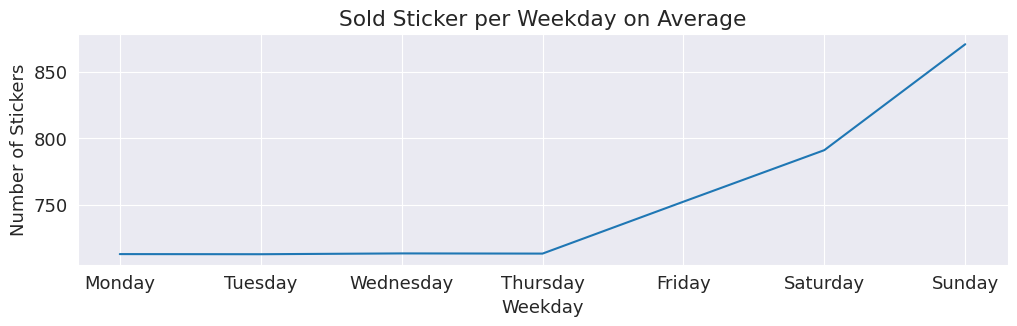

In [54]:
# Average week in terms of number of sold stickers for the train dataset
fig, ax = plt.subplots(1,figsize=(12,3))
train_df.groupby(train_df[DATE].dt.weekday)[NUM_SOLD].mean().plot.line(
    ax=ax,
    title="Sold Sticker per Weekday on Average", 
    ylabel="Number of Stickers",
    xlabel="Weekday",
)
ax.set_xticks(np.arange(0,7),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.show()

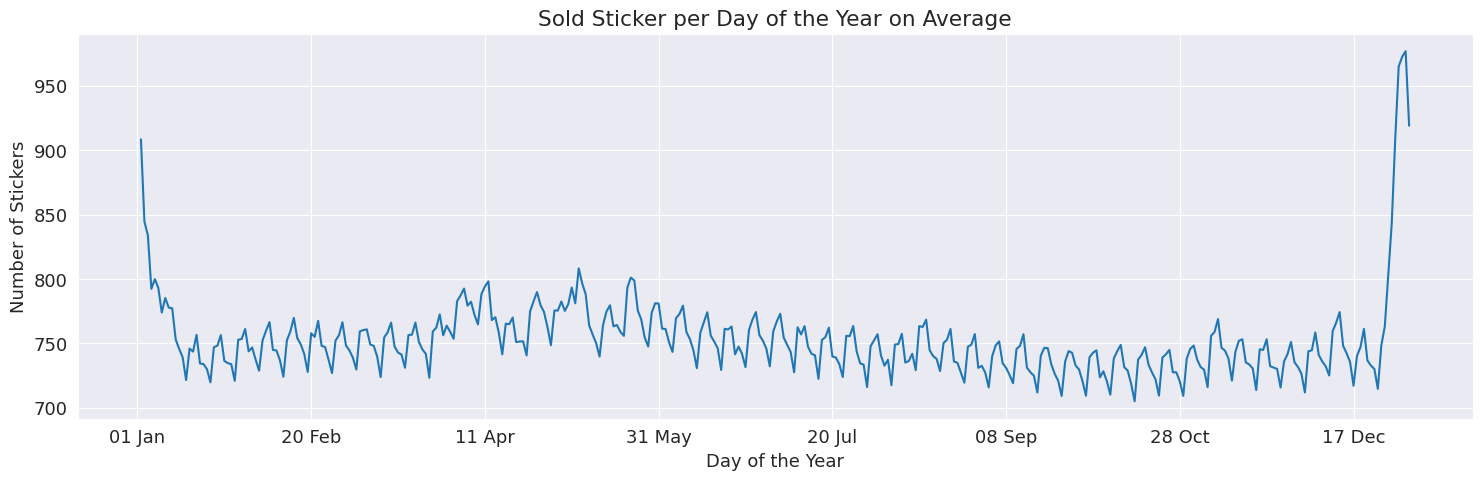

In [55]:
# Seasonal plots (yearly)
fig, ax = plt.subplots(1,figsize=(18,5))
train_df.groupby(train_df[DATE].dt.dayofyear)[NUM_SOLD].mean().plot.line(
    ax=ax,
    title="Sold Sticker per Day of the Year on Average", 
    ylabel="Number of Stickers",
    xlabel="Day of the Year",
)
ax.set_xticks(np.arange(0,351,50),[x.strftime('%d %b') for x in pd.to_datetime(np.arange(0,351,50),unit='D')])
plt.show()

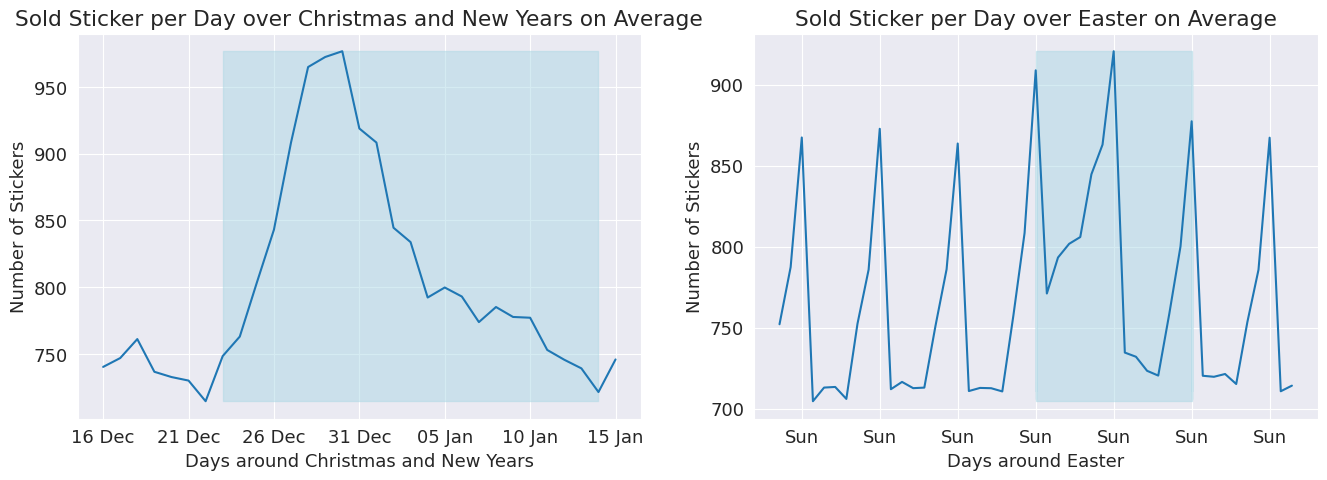

In [56]:
# Plot one month around the New Years
fig, (axL,axR) = plt.subplots(ncols=2,figsize=(16,5))
md = train_df.groupby(train_df[DATE].dt.dayofyear)[NUM_SOLD].mean()
newyear_df = pd.concat([md.iloc[350:366],md.iloc[0:15]]).reset_index()
newyear_df.plot.line(
    ax=axL,
    y=NUM_SOLD,
    title="Sold Sticker per Day over Christmas and New Years on Average", 
    ylabel="Number of Stickers",
    xlabel="Days around Christmas and New Years",
    legend=False,
)
xx = np.array(newyear_df.index[0:31:5].tolist())
axL.set_xticks(
  xx,
  [x.strftime('%d %b') for x in pd.to_datetime(newyear_df.loc[0:31:5,DATE],unit='D',origin='1971-12-31')] # origin has to be the end of ('leap year' - 2)
)
d1 = 7
d2 = 29
axL.fill_betweenx(newyear_df[NUM_SOLD].tolist(),d1, d2, color='lightblue', alpha=0.5, 
                  where = (newyear_df.index > 5) & (newyear_df.index < 15))
# Plot one month around the Easter holidays
dt = 23
half_period = pd.tseries.offsets.DateOffset(dt)
easter = { # Dates before and after Easter for each year from 2010 - 2019
  y: (e-half_period, e+half_period) for y in range(2010, 2020) for e in [pd.to_datetime(1, unit="D", origin=str(y)) + pd.tseries.offsets.Easter()]
}
md = train_df[[DATE,NUM_SOLD]].loc[
  pd.DataFrame({
    yr: pd.Series(train_df[DATE].between(*easter[yr]).tolist(), name=str(yr)) for yr in range(2010,2017)
  }).any(axis=1)
].groupby(DATE, as_index=False, sort=False).mean() # Mean within each year
easter_df = md.assign(**{
  DATE: lambda x: x.groupby(md[DATE].dt.year, as_index=False, sort=False)[DATE].transform('rank').astype(int) - (dt + 1)
}).groupby(DATE, as_index=False, sort=False).mean() # Mean among years
easter_df.plot.line(
    ax=axR,
    y=NUM_SOLD,
    title="Sold Sticker per Day over Easter on Average", 
    ylabel="Number of Stickers",
    xlabel="Days around Easter",
    legend=False,
)
axR.set_xticks(
  easter_df.index[dt-(dt//7)*7:(dt+1)*2:7].tolist(),
  [x.strftime('%a') for x in pd.to_datetime(easter_df.loc[dt-(dt//7)*7:(dt+1)*2:7,DATE], unit='D',origin='1973-06-17')] # origin has to be on Sunday
)
d1 = dt
d2 = dt+14
axR.fill_betweenx(easter_df[NUM_SOLD],d1,d2, color='lightblue', alpha=0.5, where=(easter_df.index > dt-(dt//7)*7) & (easter_df.index <= dt+7))
plt.show()

In [57]:
train_ss = train_df.copy()

In [58]:
train_df = train_ss.copy()

#train_df = train_df.fillna(0).astype({NUM_SOLD: int})  # fill missing values with zero!

# Total missing value of Canada/Kenya Holographic Goose in the Discount Stickers store in the dataset
# does not contain any information - remove before imputing other values.
# Also, remove data for Holographic Goose for the Stickers for Less and Premium Sticker Mart stores,
# since they will not be imputed simply by interpolating linearly (maximum 5 days length).
train_df = train_df.loc[
  (~train_df[COUNTRY].isin(['Canada','Kenya'])) |
  (~train_df[STORE].isin(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'])) |
  (train_df[PRODUCT] != 'Holographic Goose')
]

# Features triplets (COUNTRY, STORE, PRODUCT) that need imputation.
nan_features = train_df.loc[train_df[NUM_SOLD].isna(),[COUNTRY,STORE,PRODUCT]].value_counts().reset_index()
print(nan_features)

# remove features from data with missing values - begin
#for _, row in nan_features.iterrows():
#    mask = True
#    for feat in [COUNTRY,STORE,PRODUCT]:
#        mask &= (train_df[feat] == row[feat])
#    train_df = trfor _, row in categories_to_drop.iterrows():
#    mask = True
#    for feat in cat_features:
#        mask &= (df[feat] == row[feat])
#    df = df[~mask]
#ain_df[~mask]
# remove features from data with missing values - end

# interpolate missing data - begin
for _, row in nan_features.iterrows():
    mask = (train_df[COUNTRY] == row[COUNTRY]) & (train_df[STORE] == row[STORE]) & (train_df[PRODUCT] == row[PRODUCT])
    train_df.loc[mask,NUM_SOLD] = train_df.loc[mask,NUM_SOLD].interpolate(limit=5).transform(round) # Don't interpolate more than five days
# interpolate missing data - end

# Explore LATER
# Idea for imputing values. Begin by removing trends from the time series. Then use average values of days from other years to impute values.
# Using seasonal_decompose function to decompose the time series into its individual components
#tser = train_df.loc[
#  train_df[COUNTRY].isin(['Canada']) &
#  train_df[STORE].isin(['Premium Sticker Mart']) &
#  train_df[PRODUCT].isin(['Holographic Goose'])                                     
#][[DATE,NUM_SOLD]].set_index(DATE)
#decomposition = sm.tsa.seasonal_decompose(tser)
# Creating an empty dataframe to store the individual components
#decomposed_data = pd.DataFrame()
# Extracting the trend component of time series
#decomposed_data['trend'] = decomposition.trend
# Extracting the seasonal component of time series
#decomposed_data['seasonal'] = decomposition.seasonal
# Extracting the white noise or residual component of time series
#decomposed_data['random_noise'] = decomposition.resid


nan_features = train_df.loc[train_df[NUM_SOLD].isna(),[COUNTRY,STORE,PRODUCT]].value_counts().reset_index()
print(nan_features)

  country              store             product  count
0   Kenya  Discount Stickers            Kerneler     63
1  Canada  Discount Stickers            Kerneler      1
2   Kenya  Discount Stickers  Kerneler Dark Mode      1
Empty DataFrame
Columns: [country, store, product, count]
Index: []


In [59]:
# Identify 
# a) Weekdays (FriToSun and MonToThu), 
# b) Christmas and New Years (23rd December to 4th January), 
# c) New Years Recovery time (5th January - 15 January), and 
# d) Easter Week (Easter Sunday to next Sunday)
# Constants:
new_attributes = (
  'Year', 'Quarter', 'Month', 'Week', 'Weekday', 'Christmas_and_New_Years', 'After_New_Years', 'Easter'
)
YEAR, QUARTER, MONTH, WEEK, WEEKDAY, CH_NY, AFTER_NY, EASTER = new_attributes
# Convenient function to determine Easter.
def is_easter(x):
    """
      This function identifies the easter for years between 2010 and 2019.
      Days outside first Easter week are numbered 0. Easter Sunday gets 1, and
      then increasing number during the Easter week.
    """
    days_before_easter = 0
    days_after_easter = 7
    easter = { # Dates defining the Easter week (Easter Sunday to next Sunday inclusive) for each year from 2010 - 2019
      y: (
          e-pd.tseries.offsets.DateOffset(days_before_easter), e+pd.tseries.offsets.DateOffset(days_after_easter)
      ) for y in range(2010, 2020) for e in [pd.to_datetime(1, unit="D", origin=str(y)) + pd.tseries.offsets.Easter()]
    }
    return [
      ((x.loc[i,DATE] - easter[x.loc[i,DATE].year][0]).days + 1)
      if ((x.loc[i,DATE] >= easter[x.loc[i,DATE].year][0]) & (x.loc[i,DATE] <= easter[x.loc[i,DATE].year][1]))
      else 0
      for i in x.index
    ]
# Convenient function to define how weeks are numbered.
def week_number(x):
    """
      Week starts on Monday, first week of the year is numbered 0.
      The first and the last weeks of the year can contain 1 to 7 days.
    """
    return (x[DATE].dt.day_of_year-x[DATE].dt.day_of_week+5)//7
# Attribute creation functions dictionary.
attfunc = {
  # Four digit year
  YEAR: lambda x: x[DATE].dt.year, 
  # Quarter: 1,2,3 or 4.
  QUARTER: lambda x: x[DATE].dt.quarter,
  # Month: 1 to 12.
  MONTH: lambda x: x[DATE].dt.month,
  # Week number: 0 - 53.
  WEEK: week_number,
  # Weekday: 0 for Mon - Thu, 1 = Fri, 2 = Sat, 3 = Sun.
  WEEKDAY: lambda x: [max(0, x.loc[i,DATE].day_of_week - 3) for i in x.index],
  # Christmas and New Years: 0 for days other then 23 Dec - 4 January, that go from 1 at 23 Dec and increase to 13 at 4 Jan.
  CH_NY: lambda x: [
           (x.loc[i,DATE].day - 23 + 1 + 31*(1 - x.loc[i,DATE].month//12))
           if ((x.loc[i,DATE].month == 12) & (x.loc[i,DATE].day >= 23)) | ((x.loc[i,DATE].month == 1) & (x.loc[i,DATE].day <= 4))
           else 0
           for i in x.index
         ],
  # After New Years: 0 outside interval. From 5 January to 15 Janury increase from 1 at 5 Jan to 11 at 15 January.
  AFTER_NY: lambda x: [(x.loc[i,DATE].day - 5 + 1) if (x.loc[i,DATE].month == 1) & (x.loc[i,DATE].day >= 5) & (x.loc[i,DATE].day <= 15) else 0 for i in x.index],
  # Easter: 0 outside first week of Easter. Otherwise 1 for Easter Sunday incremental to 8 at next Sunday.
  EASTER: is_easter,
}
# Add columns for train and test datasets.
train_df = train_df.assign(**{n: attfunc[n] for n in new_attributes})
test_df = test_df.assign(**{n: attfunc[n] for n in new_attributes})

In [60]:
#test_df.loc[(test_df[DATE]>=(pd.to_datetime(1, unit="D", origin=str(2018)) + pd.tseries.offsets.Easter())-pd.tseries.offsets.DateOffset(10)) & (test_df[COUNTRY]=="Finland") & (test_df[STORE]=="Discount Stickers") & (test_df[PRODUCT] == "Holographic Goose")].head(30)
#test_df.loc[(test_df[DATE]>=(pd.to_datetime(1, unit="D", origin=str(2018)))-pd.tseries.offsets.DateOffset(10)) & (test_df[COUNTRY]=="Finland") & (test_df[STORE]=="Discount Stickers") & (test_df[PRODUCT] == "Holographic Goose")].head(30)
train_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,214788,2013-07-02 00:00:00,2010-01-01 00:00:00,2011-10-02 00:00:00,2013-07-02 00:00:00,2015-04-02 00:00:00,2016-12-31 00:00:00,NaN
num_sold,214788.0,771.270257,5.0,234.0,625.0,1136.0,5939.0,691.544591
Year,214788.0,2013.000782,2010.0,2011.0,2013.0,2015.0,2016.0,2.0002
Quarter,214788.0,2.508408,1.0,2.0,3.0,4.0,4.0,1.11713
Month,214788.0,6.522487,1.0,4.0,7.0,10.0,12.0,3.448833
Week,214788.0,26.102073,0.0,13.0,26.0,39.0,53.0,15.069738
Weekday,214788.0,0.857646,0.0,0.0,0.0,2.0,3.0,1.124651
Christmas_and_New_Years,214788.0,0.24912,0.0,0.0,0.0,0.0,13.0,1.476492
After_New_Years,214788.0,0.18068,0.0,0.0,0.0,0.0,11.0,1.163004
Easter,214788.0,0.098553,0.0,0.0,0.0,0.0,8.0,0.740781


In [18]:
def plot_individual_ts(df):
    """Description of how the function works."""
    colour_map = {
        "Canada": "blue", "Finland": "orange", "Italy": "green",
        "Kenya": "red", "Norway": "purple", "Singapore": "brown"
    }
    
    for country in df[COUNTRY].unique():
        # Determine the number of subplots required
        num_plots = df[STORE].nunique() * df[PRODUCT].nunique()
        fig, axes = plt.subplots(num_plots, figsize=(20, 4*num_plots), constrained_layout=True)
        
        # Flatten axes for easier indexing if there's more than one subplot
        if num_plots > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        
        count = 0
        for store in df[STORE].unique():
            for product in df[PRODUCT].unique():
                # Filter data for the current product, store, and country
                plot_df = df.loc[
                    (df[PRODUCT] == product) &
                    (df[COUNTRY] == country) &
                    (df[STORE] == store)
                ]
                
                # Plot the line chart
                axes[count].plot(
                    plot_df[DATE], plot_df[NUM_SOLD],
                    linewidth=0.5, color=colour_map[country]
                )
                
                # Add titles and annotations
                axes[count].set_title(f"{country} - {store} - {product}")
                axes[count].axvline(pd.to_datetime("2017-01-01"), color='black', linestyle='--')
                axes[count].set_xlabel('Date')
                axes[count].set_ylabel('Number Sold')
                
                count += 1

        # Adjust layout for better readability
        plt.suptitle(f"Time Series Plots for {country}", fontsize=16)
        plt.show()

In [19]:
#plot_individual_ts(train_df)
#plot_individual_ts(train_df.loc[
#                   train_df[COUNTRY].isin(['Canada','Kenya']) &
#                   train_df[STORE].isin(['Stickers for Less', 'Premium Sticker Mart']) &
#                   train_df[PRODUCT].isin(['Holographic Goose']) 
#                   ])

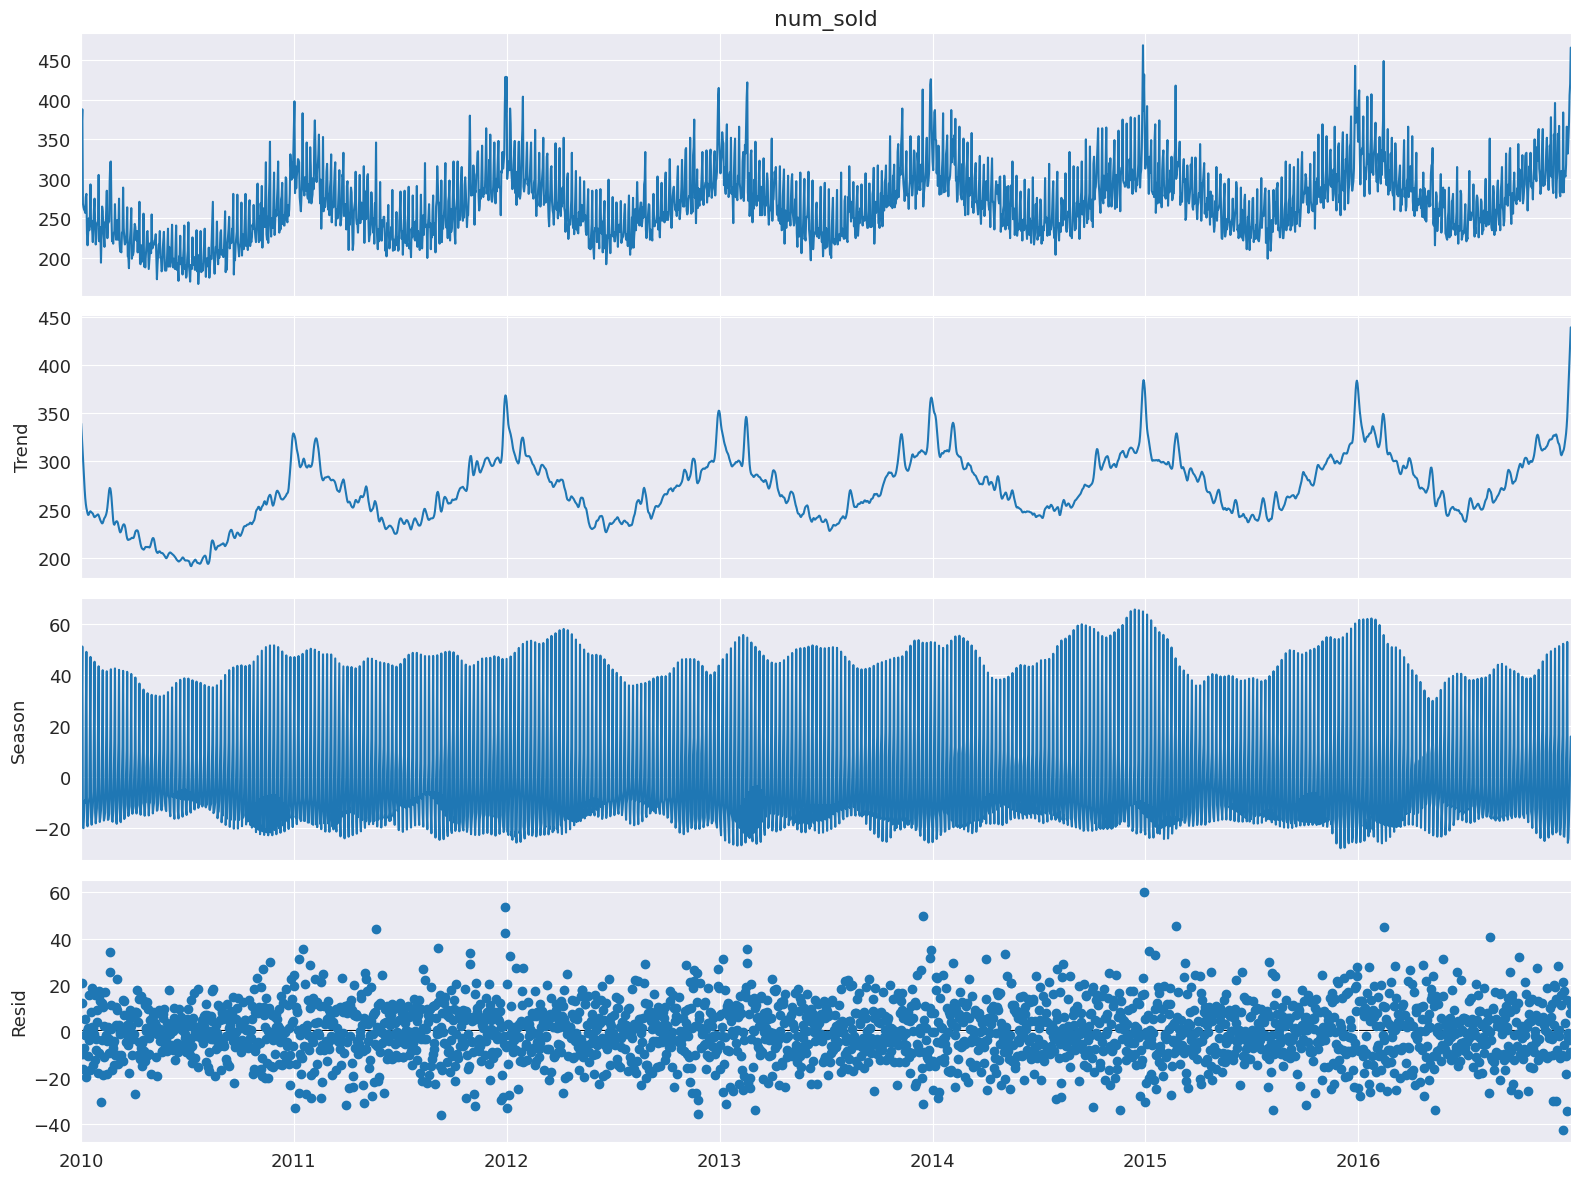

In [20]:
from statsmodels.tsa.seasonal import STL
#fig, axs = plt.subplots(1,figsize=(20,10))
stl = STL(train_df.set_index(DATE).query(COUNTRY + "== 'Singapore' and " + STORE + "=='Premium Sticker Mart' and " + PRODUCT + "=='Holographic Goose'")[NUM_SOLD], seasonal=13)
res = stl.fit()
fig = res.plot()
#plt.show()

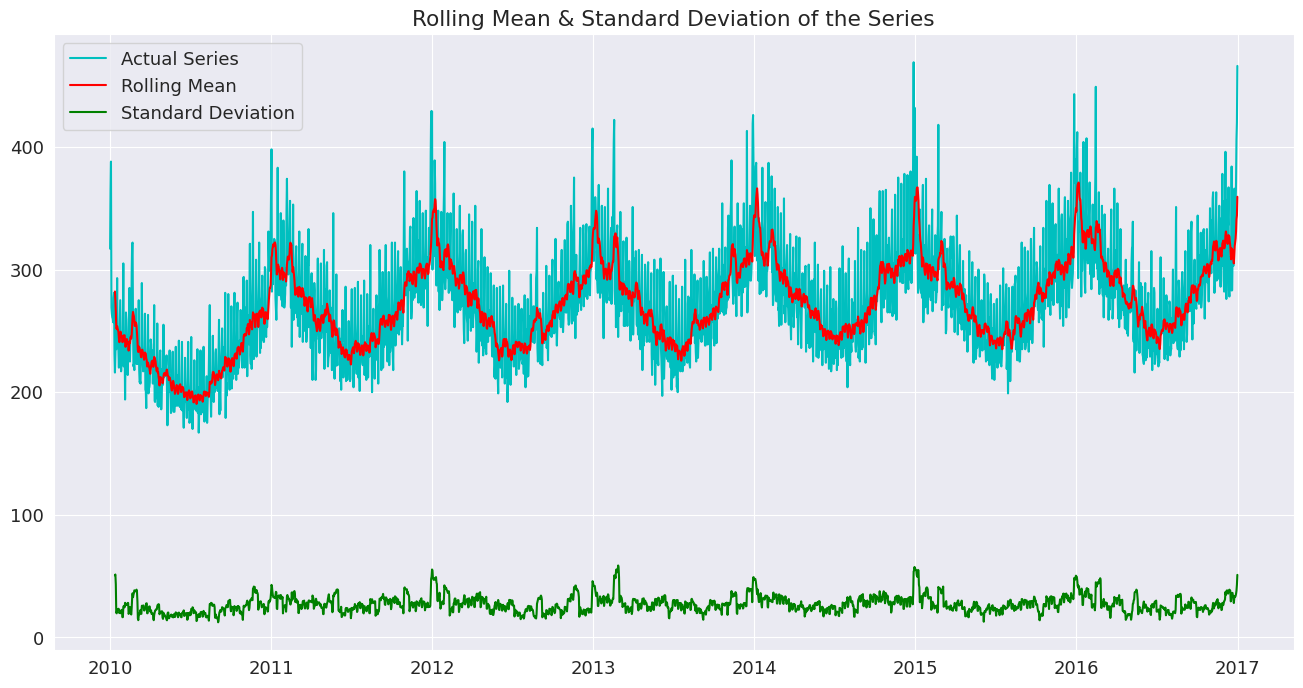

In [21]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
df = train_df.set_index(DATE).query(COUNTRY + "== 'Singapore' and " + STORE + "=='Premium Sticker Mart' and " + PRODUCT + "=='Holographic Goose'")[[NUM_SOLD]]

rolmean = df.rolling(window = 12).mean()

rolstd = df.rolling(window = 12).std()

# Visualizing the rolling mean and standard deviation
plt.figure(figsize = (16, 8))

actual = plt.plot(df, color = 'c', label = 'Actual Series')

rollingmean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')

rollingstd = plt.plot(rolstd, color='g', label = 'Standard Deviation')

plt.title('Rolling Mean & Standard Deviation of the Series')

plt.legend()

plt.show()


In [22]:
# Define a function to use adfuller test

def adfuller(data):

  #Importing adfuller using statsmodels
    from statsmodels.tsa.stattools import adfuller

    print('Dickey-Fuller Test: ')

    adftest = adfuller(data[NUM_SOLD])

    adfoutput = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'No. of Observations'])

    for key, value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value

    print(adfoutput)

adfuller(df)


Dickey-Fuller Test: 
Test Statistic            -1.306732
p-value                    0.626087
Lags Used                 27.000000
No. of Observations     2529.000000
Critical Value (1%)       -3.432938
Critical Value (5%)       -2.862684
Critical Value (10%)      -2.567379
dtype: float64


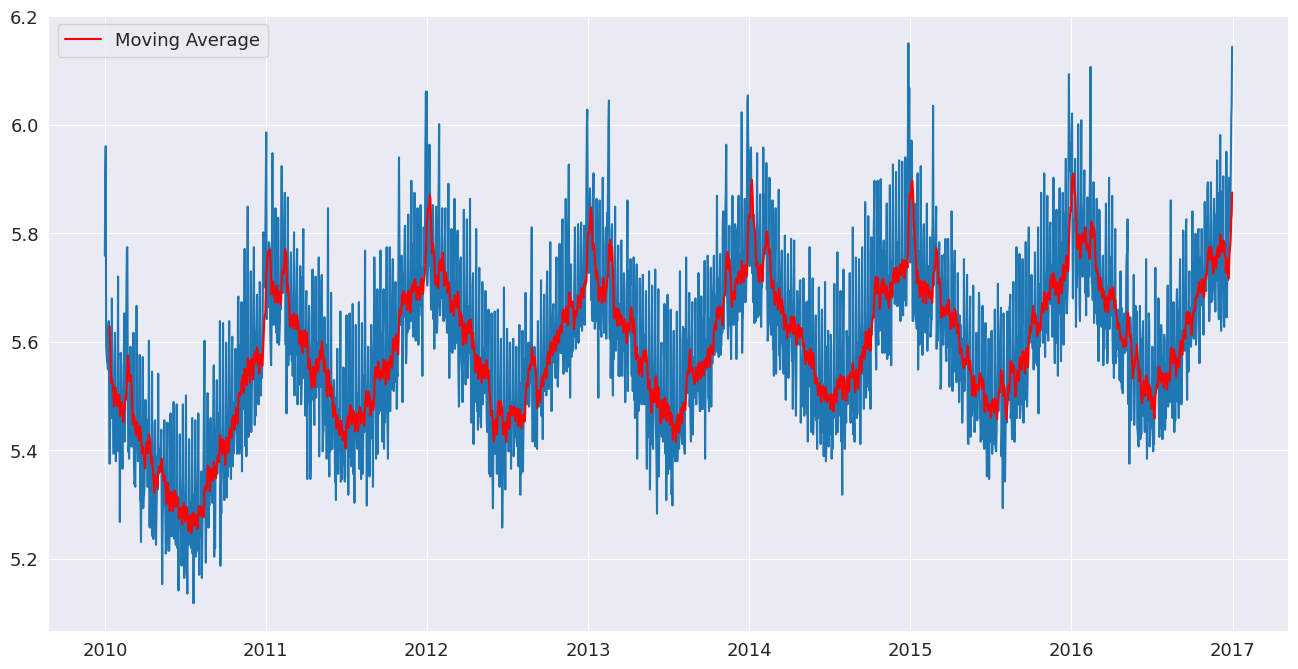

In [23]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize = (16, 8))

df_log = np.log(df)

MAvg = df_log.rolling(window = 12).mean()

MStd = df_log.rolling(window = 12).std()

plt.plot(df_log)

plt.plot(MAvg, color='r', label = 'Moving Average')

#plt.plot(MStd,data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABSEAAAKqCAYAAADFW5sfAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3iT9frH8U+6d8soS/beWxCZIksUwcEQRFAEt3AQ9CA/GS5kKYgTByCCIIgcXCjgANkge4PsPVu62+T5/ZEBgRZamjRp+35dVy/T5MnzfBPSnsOH+3vfJsMwDAEAAAAAAACAm/h4egEAAAAAAAAA8jZCSAAAAAAAAABuRQgJAAAAAAAAwK0IIQEAAAAAAAC4FSEkAAAAAAAAALcihAQAAAAAAADgVoSQAAAAAAAAANyKEBIAAAAAAACAWxFCAgAAAAAAAHArQkgAAPKw6dOny2Qy6dChQ477WrVqpVatWjm+P3TokEwmk6ZPn57j60PultOfnbJly6pv3745cq3sMplMGjVqlEvPee3Prjc6ffq0Hn74YRUqVEgmk0mTJk3K8jn69u2rsLAw1y/Ow3LT5xcAAHcghAQAwEvYA0P7l5+fn2677Tb17dtXx48f9/Ty3OLPP/90vN6vv/463WOaNm0qk8mkmjVr5vDqsi4pKUnDhg1T2bJlFRISoqpVq2rIkCFZPs8PP/ygli1bqkiRIgoJCVH58uXVrVs3LV682HHMiRMnNGrUKG3evNmFryBvuPbnqGDBgmrQoIEGDhyonTt3enp5N7Rz506NGjXK6R8OcpP//Oc/+vXXXzVs2DDNnDlTHTp0SPe4hIQEjRo1Sn/++WfOLvAaf//9t+655x7ddtttCgoKUunSpdWpUyfNnj3bo+sCACAv8vP0AgAAgLPXX39d5cqVU1JSktasWaPp06fr77//1vbt2xUUFOTy65UpU0aJiYny9/d3+bkzKygoSLNnz9ajjz7qdP+hQ4e0atUqt7xud3jllVf0/vvv64knnlDjxo21Z88eff3115owYUKmzzFhwgQNHTpULVu21LBhwxQSEqL9+/dr6dKlmjNnjiPUOXHihEaPHq2yZcuqbt26bnpFuVfbtm312GOPyTAMxcTEaMuWLZoxY4Y++ugjjR07VoMHD3br9RMTE+Xnl/X/q71z506NHj1arVq1UtmyZZ0e++2331y0Ovf5/fff1blz55uG7wkJCRo9erQkeay6c968eerevbvq1q2rgQMHqkCBAjp48KCWL1+uzz77TD179nTp9fbs2SMfH2pAAAD5FyEkAABe5p577lHDhg0lSU8++aQKFy6ssWPHatGiRerWrZvLr2cymTwe8nXs2FGLFi3SuXPnVLhwYcf9s2fPVtGiRVWpUiVdvHjRgyvMnDlz5qhjx4764osvHPe9/fbbmX5+Wlqa3njjDbVt2zbdwOnMmTMuWae3io+PV2hoqEvOVbly5etC7XfeeUedOnXSSy+9pKpVq6pjx44uuVZ63PEzFRAQ4PJzutqZM2cUFRXl6WVkyqhRo1S9enWtWbPmuvfWVT9rhmEoKSlJwcHBCgwMdMk5AQDIrfinOAAAvFzz5s0lSQcOHHC6//fff1fz5s0VGhqqqKgode7cWbt27cry+dPr62fvyXb8+HF16dJFYWFhio6O1pAhQ2Q2m52ef/78efXu3VsRERGKiopSnz59tGXLliz1CuzcubMCAwM1b948p/tnz56tbt26ydfXN93nff3112rQoIGCg4NVsGBB9ejRQ0ePHnU6ZsWKFeratatKly6twMBAlSpVSv/5z3+UmJjodFxWXnNGfHx8ZBiG031ZCR7OnTun2NhYNW3aNN3HixQpIsm6jf3222+XJD3++OOOrcf299sdr/nSpUvq27evIiMjHX/Oly5dum6NW7duVd++fVW+fHkFBQWpWLFieuKJJ3T+/Hmn40aNGiWTyaSdO3eqZ8+eKlCggJo1aybJGty8+eabKlmypEJCQnTXXXdpx44dmX4fM1KoUCHNmTNHfn5+euutt5weS05O1siRI1WxYkXHe/byyy8rOTnZcUzNmjV11113XXdei8Wi2267TQ8//LDjvmt7Qh4+fFjPPvusqlSpouDgYBUqVEhdu3Z12nY9ffp0de3aVZJ01113Of5c7VuW0+sJeebMGfXr109FixZVUFCQ6tSpoxkzZjgdY/8ZnzBhgqZOnaoKFSooMDBQt99+u9avX5+p9+7ff/9V165dVbBgQYWEhOiOO+7QTz/95LR2k8kkwzD04YcfOtaenkOHDik6OlqSNHr0aMex1/bQzMzn0mKxaNKkSapRo4aCgoJUtGhRPfXUU5n6R4sDBw7o9ttvTzfctf+sZfU6ZcuW1X333adff/1VDRs2VHBwsD799FPHY9f2hLx06ZIGDRqkUqVKKTAwUBUrVtTYsWNlsVicjpszZ44aNGig8PBwRUREqFatWpo8efJNXyMAAN6EEBIAAC9nDykKFCjguG/p0qVq3769zpw5o1GjRmnw4MFatWqVmjZt6rJecmazWe3bt1ehQoU0YcIEtWzZUhMnTtTUqVMdx1gsFnXq1EnffPON+vTpo7feeksnT55Unz59snStkJAQde7cWd98843jvi1btmjHjh0Zbol866239Nhjj6lSpUp69913NWjQIC1btkwtWrRwCsfmzZunhIQEPfPMM5oyZYrat2+vKVOm6LHHHrul13wjjz/+uBYvXqxffvklS6/frkiRIgoODtYPP/ygCxcuZHhctWrV9Prrr0uSBgwYoJkzZ2rmzJlq0aKFJNe/ZsMw1LlzZ82cOVOPPvqo3nzzTR07dizdP+clS5bo33//1eOPP64pU6aoR48ejgrRawNaSeratasSEhL09ttvq3///pKkESNG6LXXXlOdOnU0fvx4lS9fXu3atVN8fHzW3tB0lC5dWi1bttSaNWsUGxsryfo5vv/++zVhwgR16tRJU6ZMUZcuXfTee++pe/fujud2795dy5cv16lTp5zO+ffff+vEiRPq0aNHhtddv369Vq1apR49euj999/X008/rWXLlqlVq1ZKSEiQJLVo0UIvvviiJOnVV191/LlWq1Yt3XMmJiaqVatWmjlzpnr16qXx48crMjJSffv2TTegmj17tsaPH6+nnnpKb775pg4dOqQHH3xQqampN3zPTp8+rTvvvFO//vqrnn32Wb311ltKSkrS/fffr++//96x9pkzZ0qyboW3rz090dHR+vjjjyVJDzzwgOPYBx980HFMZn8Wn3rqKQ0dOlRNmzbV5MmT9fjjj2vWrFlq3779TV9XmTJltGzZMh07duyGx2X1Onv27NEjjzyitm3bavLkyRm2S0hISFDLli319ddf67HHHtP777+vpk2batiwYU7tApYsWaJHHnlEBQoU0NixY/XOO++oVatWWrly5U3XDQCAVzEAAIBXmDZtmiHJWLp0qXH27Fnj6NGjxvz5843o6GgjMDDQOHr0qOPYunXrGkWKFDHOnz/vuG/Lli2Gj4+P8dhjj113zoMHDzrua9mypdGyZUvH9wcPHjQkGdOmTXPc16dPH0OS8frrrzutsV69ekaDBg0c33/33XeGJGPSpEmO+8xms9G6devrzpmeP/74w5BkzJs3z/jxxx8Nk8lkHDlyxDAMwxg6dKhRvnx5x5pr1KjheN6hQ4cMX19f46233nI637Zt2ww/Pz+n+xMSEq677pgxYwyTyWQcPnw4y685I6mpqcajjz5qBAQEGKGhocaqVatu+pz0jBgxwpBkhIaGGvfcc4/x1ltvGRs3brzuuPXr12f4Hrv6NS9cuNCQZIwbN85xX1pamtG8efPr1pDetb/55htDkrF8+XLHfSNHjjQkGY888ojTsWfOnDECAgKMe++917BYLI77X331VUOS0adPn+vOfy1JxnPPPZfh4wMHDjQkGVu2bDEMwzBmzpxp+Pj4GCtWrHA67pNPPjEkGStXrjQMwzD27NljSDKmTJnidNyzzz5rhIWFOb12ScbIkSMd36f3vqxevdqQZHz11VeO++bNm2dIMv7444/rjr/2Z3fSpEmGJOPrr7923JeSkmI0adLECAsLM2JjYw3DuPIzXqhQIePChQuOY//3v/8Zkowffvgho7fKMAzDGDRokCHJ6f25fPmyUa5cOaNs2bKG2Wx2et03eu/tzp49e917ZJfZz+WKFSsMScasWbOcjlu8eHG691/riy++MCQZAQEBxl133WW89tprxooVK5xeT1avU6ZMGUOSsXjx4uuuV6ZMGafP7xtvvGGEhoYae/fudTruv//9r+Hr6+v4XThw4EAjIiLCSEtLu+HrAQDA21EJCQCAl2nTpo2io6NVqlQpPfzwwwoNDdWiRYtUsmRJSdLJkye1efNm9e3bVwULFnQ8r3bt2mrbtq1+/vlnl63l6aefdvq+efPm+vfffx3fL168WP7+/o4KNsm6Jfm5557L8rXatWunggULas6cOTIMQ3PmzNEjjzyS7rELFiyQxWJRt27ddO7cOcdXsWLFVKlSJf3xxx+OY4ODgx234+Pjde7cOd15550yDEObNm3K8mvOyMsvv6xffvlF27ZtU+PGjdWxY0enydUnT56UyWRy6heZntGjR2v27NmqV6+efv31Vw0fPlwNGjRQ/fr1M73d3tWv+eeff5afn5+eeeYZx32+vr564YUXbnjtpKQknTt3TnfccYck6Z9//rnptZcuXaqUlBS98MILTtt5Bw0alNHLzbKwsDBJ0uXLlyVZK0erVaumqlWrOn2eWrduLUmOz1PlypVVt25dzZ0713Eus9ms+fPnq1OnTk6v/VpXP5aamqrz58+rYsWKioqKSvd9yYyff/5ZxYoVc/o58ff314svvqi4uDj99ddfTsd3797dqaLa3urhZp/vn3/+WY0aNXJsl5es7+GAAQN06NAht00cv9nnct68eYqMjFTbtm2d/twaNGigsLAwp98D6XniiSe0ePFitWrVSn///bfeeOMNNW/eXJUqVdKqVatu+TrlypVT+/btb/r65s2bp+bNm6tAgQJO523Tpo3MZrOWL18uSYqKilJ8fLyWLFly03MCAODNCCEBAPAyH374oZYsWaL58+erY8eOOnfunFNfwcOHD0uSqlSpct1zq1WrpnPnzrlk22pQUJCjb5tdgQIFnHqgHT58WMWLF1dISIjTcRUrVszy9fz9/dW1a1fNnj1by5cv19GjRzPcir1v3z4ZhqFKlSopOjra6WvXrl1OQyWOHDniCGztveVatmwpSYqJicnya07P8ePH9f777+uVV15R5cqVtXDhQpUrV07t2rXTnj17JEnbt2+XJDVu3Pim78UjjzyiFStW6OLFi/rtt9/Us2dPbdq0SZ06dVJSUtJNn+/q12z/c7aHd3bpfQYvXLiggQMHqmjRogoODlZ0dLTKlSuX7rUlOR67+lqSVKlSJaf7o6OjnQK07IiLi5MkhYeHS7J+nnbs2HHdZ6ly5cqSnIeUdO/eXStXrtTx48clWftznjlzxmnbdnoSExM1YsQIR++/woULKzo6WpcuXUr3fcmMw4cPq1KlStdNXLZv37a/l3alS5d2+t7+ft7s83348OEMf9+kdx1XyMznct++fYqJiVGRIkWu+7OLi4vL1HCZ9u3b69dff9WlS5e0fPlyPffcczp8+LDuu+8+x/Ozep1rP9MZ2bdvnxYvXnzdOdu0aSPpyufu2WefVeXKlXXPPfeoZMmSjvAUAIDchunYAAB4mUaNGjmmY3fp0kXNmjVTz549tWfPnutCIHfKaBiMO/Xs2VOffPKJRo0apTp16qh69erpHmexWGQymfTLL7+ku077+2Q2m9W2bVtduHBBr7zyiqpWrarQ0FAdP35cffv2vW74w62+5rVr18psNjsq/sLDw/XLL7+oadOmatOmjVasWKGpU6eqTp06qlmzZqbPGxERobZt26pt27by9/fXjBkztHbtWkegmJ6ces0Z6datm1atWqWhQ4eqbt26CgsLk8ViUYcOHa67tqQbVg+6y/bt2+Xr6+sIiywWi2rVqqV333033eNLlSrluN29e3cNGzZM8+bN06BBg/Ttt98qMjJSHTp0uOE1X3jhBU2bNk2DBg1SkyZNFBkZKZPJpB49eqT7vrhDRn/WRjq9Oj0tM59Li8WiIkWKaNasWek+fm2IeSMhISFq3ry5mjdvrsKFC2v06NH65Zdf1KdPnyxfJ7OfaYvForZt2+rll19O93F7CF6kSBFt3rxZv/76q3755Rf98ssvmjZtmh577LHrhhABAODNCCEBAPBivr6+GjNmjO666y598MEH+u9//6syZcpIkqPC7mq7d+9W4cKFFRoamiPrK1OmjP744w8lJCQ4VUPu37//ls7XrFkzlS5dWn/++afGjh2b4XEVKlSQYRgqV66c4y/q6dm2bZv27t2rGTNmOA1lcfW2Rvu24asncxctWlS//vqrmjZtqpYtW+rYsWNasGDBLV+jYcOGmjFjhk6ePOl0zWu54zXbB3jExcU5BeHXfgYvXryoZcuWafTo0RoxYoTj/n379mXpWvbnlC9f3nH/2bNnMzXx+GaOHDmiv/76S02aNHFUQlaoUEFbtmzR3XffneH7aleuXDk1atRIc+fO1fPPP68FCxaoS5cuN52CPn/+fPXp00cTJ0503JeUlHTdhPGbXf9qZcqU0datW2WxWJyqIXfv3u143BXKlCmT4e+bW71OVl5nRipUqKClS5eqadOmLg2z7f8IZP9Zc9d1KlSooLi4OEfl440EBASoU6dO6tSpkywWi5599ll9+umneu21126p8hwAAE9gOzYAAF6uVatWatSokSZNmqSkpCQVL15cdevW1YwZM5wCjO3bt+u3335Tx44dc2xt9smwn332meM+i8WiDz/88JbOZzKZ9P7772vkyJHq3bt3hsc9+OCD8vX11ejRo6+r4jIMQ+fPn5d0pZrq6mMMw0h3cnB2NGvWTIGBgXrnnXcck44la8gwadIkHTlyRJGRkTesYJSs03JXr16d7mP2idv2bbH2oPnaEMsdr7ljx45KS0tzTDSWrBWXU6ZMuem1JWnSpEmZvlabNm3k7++vKVOmOJ0nK+fIyIULF/TII4/IbDZr+PDhjvu7deum48ePO32O7RITE69rb9C9e3etWbNGX375pc6dO3fTrdiS9b259n2ZMmWKzGaz030Z/bmmp2PHjjp16pRTj8q0tDRNmTJFYWFhN/28ZVbHjh21bt06p89mfHy8pk6dqrJly2ZYsXwj9n+0yMzrzEi3bt1kNpv1xhtvXPdYWlraTc+9bNmydO+399W1/6xl9zoZ6datm1avXq1ff/31uscuXbqktLQ0SXL8PrPz8fFR7dq1JUnJycm3dG0AADyBSkgAAHKBoUOHqmvXrpo+fbqefvppjR8/Xvfcc4+aNGmifv36KTExUVOmTFFkZKRGjRqVY+vq0qWLGjVqpJdeekn79+9X1apVtWjRIl24cEHSrVU7de7cWZ07d77hMRUqVNCbb76pYcOG6dChQ+rSpYvCw8N18OBBff/99xowYICGDBmiqlWrqkKFChoyZIiOHz+uiIgIfffddy6pqLtadHS0xowZo8GDB6tWrVp64oknVKxYMW3YsEEzZszQHXfcoX/++UcPP/ywfvnlF/n7+6d7noSEBN15552644471KFDB5UqVUqXLl3SwoULtWLFCnXp0kX16tVzvAdRUVH65JNPFB4ertDQUDVu3Ngtr7lTp05q2rSp/vvf/+rQoUOqXr26FixYcF0vw4iICLVo0ULjxo1TamqqbrvtNv322286ePBglt7LIUOGaMyYMbrvvvvUsWNHbdq0Sb/88osKFy6c6fPs3btXX3/9tQzDUGxsrLZs2aJ58+YpLi5O7777rtP26d69e+vbb7/V008/rT/++ENNmzaV2WzW7t279e233+rXX391VMdJ1vBoyJAhGjJkiAoWLJipSrb77rtPM2fOVGRkpKpXr67Vq1dr6dKlKlSokNNxdevWla+vr8aOHauYmBgFBgaqdevWKlKkyHXnHDBggD799FP17dtXGzduVNmyZTV//nytXLlSkyZNclR6Ztd///tfffPNN7rnnnv04osvqmDBgpoxY4YOHjyo77777rqelJkRHBys6tWra+7cuapcubIKFiyomjVrZqldQcuWLfXUU09pzJgx2rx5s9q1ayd/f3/t27dP8+bN0+TJk/Xwww9n+PzOnTurXLly6tSpkypUqKD4+HgtXbpUP/zwg26//XZ16tTJJdfJyNChQ7Vo0SLdd9996tu3rxo0aKD4+Hht27ZN8+fP16FDh1S4cGE9+eSTunDhglq3bq2SJUvq8OHDmjJliurWrevoywkAQK6Q8wO5AQBAeqZNm2ZIMtavX3/dY2az2ahQoYJRoUIFIy0tzTAMw1i6dKnRtGlTIzg42IiIiDA6depk7Ny5M91zHjx40HFfy5YtjZYtWzq+P3jwoCHJmDZtmuO+Pn36GKGhodetY+TIkca1//fh7NmzRs+ePY3w8HAjMjLS6Nu3r7Fy5UpDkjFnzpwbvuY//vjDkGTMmzfvhse1bNnSqFGjxnX3f/fdd0azZs2M0NBQIzQ01Khatarx3HPPGXv27HEcs3PnTqNNmzZGWFiYUbhwYaN///7Gli1bsvWaM7Jw4UKjefPmRmhoqBEcHGw0bNjQ+Pjjj420tDRj6tSphiTjiSeeyPD5qampxmeffWZ06dLFKFOmjBEYGGiEhIQY9erVM8aPH28kJyc7Hf+///3PqF69uuHn5+f0etzxms+fP2/07t3biIiIMCIjI43evXsbmzZtuu6cx44dMx544AEjKirKiIyMNLp27WqcOHHCkGSMHDnyumucPXv2uuubzWZj9OjRRvHixY3g4GCjVatWxvbt240yZcoYffr0yfgPwEaS48vHx8eIiooy6tWrZwwcONDYsWNHus9JSUkxxo4da9SoUcMIDAw0ChQoYDRo0MAYPXq0ERMTc93xTZs2NSQZTz75ZIZruPr1Xrx40Xj88ceNwoULG2FhYUb79u2N3bt3p/uaPvvsM6N8+fKGr6+vIcn4448/DMO4/mfXMAzj9OnTjvMGBAQYtWrVcvrzMIwrP+Pjx4+/6TozcuDAAePhhx82oqKijKCgIKNRo0bGjz/+mO75nnvuuZuezzAMY9WqVUaDBg2MgIAAp3Vk9Wdx6tSpRoMGDYzg4GAjPDzcqFWrlvHyyy8bJ06cuOH1v/nmG6NHjx5GhQoVjODgYCMoKMioXr26MXz4cCM2NvaWrlOmTBnj3nvvTfd66f1ZX7582Rg2bJhRsWJFIyAgwChcuLBx5513GhMmTDBSUlIMwzCM+fPnG+3atTOKFCliBAQEGKVLlzaeeuop4+TJkzd8fQAAeBuTYXhhJ2oAAJCrLVy4UA888ID+/vtvNW3a1NPLAQAAAOBhhJAAACBbEhMTnYY1mM1mtWvXThs2bNCpU6c8Mv0YAAAAgHehJyQAAMiWF154QYmJiWrSpImSk5O1YMECrVq1Sm+//TYBJAAAAABJVEICAIBsmj17tiZOnKj9+/crKSlJFStW1DPPPKPnn3/e00sDAAAA4CUIIQEAAAAAAAC4lY+nFwAAAAAAAAAgbyOEBAAAAAAAAOBW+XowjcVi0YkTJxQeHi6TyeTp5QAAAAAAAAC5imEYunz5skqUKCEfn4zrHfN1CHnixAmVKlXK08sAAAAAAAAAcrWjR4+qZMmSGT6er0PI8PBwSdY3KSIiwsOrAQAAAAAAAHKX2NhYlSpVypGzZSRfh5D2LdgRERGEkAAAAAAAAMAtulmrQwbTAAAAAAAAAHArQkgAAAAAAAAAbkUICQAAAAAAAMCt8nVPSAAAAAAAAFcym81KTU319DIAl/H395evr2+2z0MICQAAAAAAkE2GYejUqVO6dOmSp5cCuFxUVJSKFSt20+EzN0IICQAAAAAAkE32ALJIkSIKCQnJVlgDeAvDMJSQkKAzZ85IkooXL37L5yKEBAAAAAAAyAaz2ewIIAsVKuTp5QAuFRwcLEk6c+aMihQpcstbsxlMAwAAAAAAkA32HpAhISEeXgngHvbPdnb6nRJCAgAAAAAAuABbsJFXueKzTQgJAAAAAAAAwK0IIQEAAAAAAOCVTCaTFi5c6JFrt2rVSoMGDfLItfMiQkgAAAAAAIB8bvXq1fL19dW9996b5eeWLVtWkyZNcv2iMuHs2bN65plnVLp0aQUGBqpYsWJq3769Vq5cme1zL1iwQG+88YYLVgmJ6dgAAAAAAAD53hdffKEXXnhBX3zxhU6cOKESJUp4ekmZ8tBDDyklJUUzZsxQ+fLldfr0aS1btkznz5+/5XOmpKQoICBABQsWdOFKQSUkAAAAAABAPhYXF6e5c+fqmWee0b333qvp06dfd8wPP/yg22+/XUFBQSpcuLAeeOABSdYty4cPH9Z//vMfmUwmxwCTUaNGqW7duk7nmDRpksqWLev4fv369Wrbtq0KFy6syMhItWzZUv/880+m133p0iWtWLFCY8eO1V133aUyZcqoUaNGGjZsmO6//36n45588klFR0crIiJCrVu31pYtWxyP29f6+eefq1y5cgoKCnK8tqu3YycnJ2vIkCG67bbbFBoaqsaNG+vPP/90PH748GF16tRJBQoUUGhoqGrUqKGff/45068nryOEBAAAAAAAcDHDMBRvNuf4l2EYWV7rt99+q6pVq6pKlSp69NFH9eWXXzqd56efftIDDzygjh07atOmTVq2bJkaNWokybpluWTJknr99dd18uRJnTx5MtPXvXz5svr06aO///5ba9asUaVKldSxY0ddvnw5U88PCwtTWFiYFi5cqOTk5AyP69q1q86cOaNffvlFGzduVP369XX33XfrwoULjmP279+v7777TgsWLNDmzZvTPc/zzz+v1atXa86cOdq6dau6du2qDh06aN++fZKk5557TsnJyVq+fLm2bdumsWPHKiwsLNPvR17HdmwAAAAAAAAXS7BYFLZiRY5fN655c4X6+mbpOV988YUeffRRSVKHDh0UExOjv/76S61atZIkvfXWW+rRo4dGjx7teE6dOnUkSQULFpSvr6/Cw8NVrFixLF23devWTt9PnTpVUVFR+uuvv3Tffffd9Pl+fn6aPn26+vfvr08++UT169dXy5Yt1aNHD9WuXVuS9Pfff2vdunU6c+aMAgMDJUkTJkzQwoULNX/+fA0YMECSdQv2V199pejo6HSvdeTIEU2bNk1HjhxxbFUfMmSIFi9erGnTpuntt9/WkSNH9NBDD6lWrVqSpPLly2fp/cjrqIQEAAAAAADIp/bs2aN169bpkUcekWQN9rp3764vvvjCcczmzZt19913u/zap0+fVv/+/VWpUiVFRkYqIiJCcXFxOnLkSKbP8dBDD+nEiRNatGiROnTooD///FP169d3bCnfsmWL4uLiVKhQIUflZFhYmA4ePKgDBw44zlOmTJkMA0hJ2rZtm8xmsypXrux0nr/++stxnhdffFFvvvmmmjZtqpEjR2rr1q239sbkUVRCAgAAAAAAuFiIj4/imjf3yHWz4osvvlBaWprTIBrDMBQYGKgPPvhAkZGRCg4OzvI6fHx8rtsanpqa6vR9nz59dP78eU2ePFllypRRYGCgmjRpopSUlCxdKygoSG3btlXbtm312muv6cknn9TIkSPVt29fxcXFqXjx4k69G+2ioqIct0NDQ294jbi4OPn6+mrjxo3yvabS1L7l+sknn1T79u31008/6bffftOYMWM0ceJEvfDCC1l6PXkVISQAAAAAAICLmUymLG+LzmlpaWn66quvNHHiRLVr187psS5duuibb77R008/rdq1a2vZsmV6/PHH0z1PQECAzGaz033R0dE6deqUDMNwDKu5ttfiypUr9dFHH6ljx46SpKNHj+rcuXPZfl3Vq1fXwoULJUn169fXqVOn5Ofn5zQUJ6vq1asns9msM2fOqPkNwuVSpUrp6aef1tNPP61hw4bps88+I4S0YTs2AAAAAABAPvTjjz/q4sWL6tevn2rWrOn09dBDDzm2ZI8cOVLffPONRo4cqV27djmGrtiVLVtWy5cv1/Hjxx0hYqtWrXT27FmNGzdOBw4c0IcffqhffvnF6fqVKlXSzJkztWvXLq1du1a9evXKUtXl+fPn1bp1a3399dfaunWrDh48qHnz5mncuHHq3LmzJKlNmzZq0qSJunTpot9++02HDh3SqlWrNHz4cG3YsCHT16pcubJ69eqlxx57TAsWLNDBgwe1bt06jRkzRj/99JMkadCgQfr111918OBB/fPPP/rjjz9UrVq1TF8jryOEBAAAAAAAyIe++OILtWnTRpGRkdc99tBDD2nDhg3aunWrWrVqpXnz5mnRokWqW7euWrdurXXr1jmOff3113Xo0CFVqFDB0VexWrVq+uijj/Thhx+qTp06WrdunYYMGXLd9S9evKj69eurd+/eevHFF1WkSJFMrz8sLEyNGzfWe++9pxYtWqhmzZp67bXX1L9/f33wwQeSrBWpP//8s1q0aKHHH39clStXVo8ePXT48GEVLVo0S+/XtGnT9Nhjj+mll15SlSpV1KVLF61fv16lS5eWJJnNZj333HOqVq2aOnTooMqVK+ujjz7K0jXyMpNxK7Pb84jY2FhFRkYqJiZGERERnl4OAAAAAADIhZKSknTw4EGVK1dOQUFBnl4O4HI3+oxnNl+jEhIAAAAAAACAWxFCAgAAAAAAAHArQkgAAAAAgNcZf+SIXtq/X/m4gxgA5Cl+nl4AAAAAAABXMwxDww8eVKphqH/x4qoaGurpJQEAsolKSAAAAACAV0m2WJRqq4DclZDg4dUAAFyBEBIAAAAA4FXiLRbH7d2EkACQJxBCAgAAAAC8SrzZ7LhNCAkAeQMhJAAAAADAq1wdQrIdGwDyBkJIAAAAAIBXubYSkgnZAJD7EUICAAAAALxK3FUh5GWzWSdTUjy4GgA38+eff8pkMunSpUuSpOnTpysqKsrx+KhRo1S3bl2PrA3egxASAAAAAOBVrh5MI7ElG3Cnvn37ymQyyWQyyd/fX+XKldPLL7+spKQkl11jyJAhWrZsmcvOl5FRo0bJZDKpQ4cO1z02fvx4mUwmtWrVyu3rQPoIIQEAAAAAXuXq7dgSw2kAd+vQoYNOnjypf//9V++9954+/fRTjRw50mXnDwsLU6FChVx2vhspXry4/vjjDx07dszp/i+//FKlS5fOkTUgfYSQAAAAAACvQggJ5KzAwEAVK1ZMpUqVUpcuXdSmTRstWbLE8XhycrJefPFFFSlSREFBQWrWrJnWr1+f6fNfux27b9++6tKliyZMmKDixYurUKFCeu6555Samuo45uTJk7r33nsVHByscuXKafbs2SpbtqwmTZp0w2sVKVJE7dq104wZMxz3rVq1SufOndO999573fGff/65qlWrpqCgIFWtWlUfffSR0+OvvPKKKleurJCQEJUvX16vvfaa0zrtr23mzJkqW7asIiMj1aNHD12+fDnT709+4efpBQAAAAAAcDV7CGmSZEjaFR/v0fUAt8QwJE8E6CEhksl0y0/fvn27Vq1apTJlyjjue/nll/Xdd99pxowZKlOmjMaNG6f27dtr//79Kliw4C1d548//nBULe7fv1/du3dX3bp11b9/f0nSY489pnPnzunPP/+Uv7+/Bg8erDNnzmTq3E888YRefvllDR8+XJK1CrJXr17XHTdr1iyNGDFCH3zwgerVq6dNmzapf//+Cg0NVZ8+fSRJ4eHhmj59ukqUKKFt27apf//+Cg8P18svv+w4z4EDB7Rw4UL9+OOPunjxorp166Z33nlHb7311i29N3kVISQAAAAAwKvYe0JWCQnR7oQEKiGROyUkSGFhOX/duDgpNDRLT/nxxx8VFhamtLQ0JScny8fHRx988IEkKT4+Xh9//LGmT5+ue+65R5L02WefacmSJfriiy80dOjQW1pmgQIF9MEHH8jX11dVq1bVvffeq2XLlql///7avXu3li5dqvXr16thw4aSrBWLlSpVytS577vvPj399NNavny5GjRooG+//VZ///23vvzyS6fjRo4cqYkTJ+rBBx+UJJUrV047d+7Up59+6ggh/+///s9xfNmyZTVkyBDNmTPHKYS0WCyaPn26wsPDJUm9e/fWsmXLCCGvQQgJAAAAAPAq9krIBmFh2p2QoOMpKYpNS1OEH3+FBdzhrrvu0scff6z4+Hi999578vPz00MPPSTJWuWXmpqqpk2bOo739/dXo0aNtGvXrlu+Zo0aNeTr6+v4vnjx4tq2bZskac+ePfLz81P9+vUdj1esWFEFChTI1Ln9/f316KOPatq0afr3339VuXJl1a5d2+mY+Ph4HThwQP369XNUX0pSWlqaIiMjHd/PnTtX77//vg4cOKC4uDilpaUpIiLC6Vxly5Z1BJD215LZqs38hN/gAAAAAACvYg8hbwsMVFF/f51OTdWehATdfs1f/AGvFhJirUr0xHWzKDQ0VBUrVpRk3bpcp04dffHFF+rXr5+rV+fg7+/v9L3JZJLFVgXtCk888YQaN26s7du364knnrju8Tjbn81nn32mxo0bOz1mD0dXr16tXr16afTo0Wrfvr0iIyM1Z84cTZw4MUdfS15BCAkAAAAA8Cr2EDLU11dVQ0J0OiZGuwkhkduYTFneFu0NfHx89Oqrr2rw4MHq2bOnKlSooICAAK1cudLRJzI1NVXr16/XoEGD3LKGKlWqKC0tTZs2bVKDBg0kSfv379fFixczfY4aNWqoRo0a2rp1q3r27Hnd40WLFlWJEiX077//ptsvUpKjN6a9t6QkHT58OIuvBnZMxwYAAAAAeBV7T8hQX19Vs4U4u+gLCeSYrl27ytfXVx9++KFCQ0P1zDPPaOjQoVq8eLF27typ/v37KyEhwW2VklWrVlWbNm00YMAArVu3Tps2bdKAAQMUHBwsUxaG7vz+++86efKkoqKi0n189OjRGjNmjN5//33t3btX27Zt07Rp0/Tuu+9KkipVqqQjR45ozpw5OnDggN5//319//33rniJ+RIhJAAAAADAq8TZKyF9fFTVtrWU4TRAzvHz89Pzzz+vcePGKT4+Xu+8844eeugh9e7dW/Xr19f+/fv166+/ZrpH46346quvVLRoUbVo0UIPPPCAYyp1UFBQps8RGhqaYQApSU8++aQ+//xzTZs2TbVq1VLLli01ffp0lStXTpJ0//336z//+Y+ef/551a1bV6tWrdJrr72W3ZeWb5kMwzA8vQhPiY2NVWRkpGJiYq5rKgoAAAAA8Ix2W7ZoycWL+qpqVRUNCFD7rVtVLSREOxs18vTSgHQlJSXp4MGDKleuXJZCMmTesWPHVKpUKS1dulR33323p5eT79zoM57ZfI2ekAAAAAAAr2LvCRlm6wkpSfsSE5Vqscjfhw19QH7w+++/Ky4uTrVq1dLJkyf18ssvq2zZsmrRooWnl4ZbxG9vAAAAAIBXuXowTcnAQIX4+CjNMPRvUpKHVwYgp6SmpurVV19VjRo19MADDyg6Olp//vnndZOokXtQCQkAAAAA8CpXD6bxMZlUNSRE/8TFaVd8vKrYKiMB5G3t27dX+/btPb0MuBCVkAAAAAAArxJ/1WAaSQynAYA8gBASAAAAAOBVrt6OLUnVCCEBINcjhAQAAAAAeA3DMK4LIe2VkLsIIQEg1yKEBAAAAAB4jRTDkNl2+9oQcndCggzD8NDKAADZQQgJAAAAAPAacWaz47a9J2SlkBD5SIo1m3UqJcVDKwMAZAchJAAAAADAa9i3YgeYTPKzhZCBPj4qHxwsiS3ZAJBbEUICAAAAALzGtf0g7ZiQDeQPhw4dkslk0ubNm3PVuW/F9OnTFRUV5TXncbcsh5DLly9Xp06dVKJECZlMJi1cuDDDY59++mmZTCZNmjTJ6f4LFy6oV69eioiIUFRUlPr166e4uDinY7Zu3armzZsrKChIpUqV0rhx4647/7x581S1alUFBQWpVq1a+vnnn7P6cgAAAAAAXsQeQoZdE0JWYzgN4BZnz57VM888o9KlSyswMFDFihVT+/bttXLlSscxN8t/8pJWrVrJZDLJZDIpMDBQt912mzp16qQFCxa4/Frdu3fX3r17s/ScsmXLXpez3cp5PCHLIWR8fLzq1KmjDz/88IbHff/991qzZo1KlChx3WO9evXSjh07tGTJEv34449avny5BgwY4Hg8NjZW7dq1U5kyZbRx40aNHz9eo0aN0tSpUx3HrFq1So888oj69eunTZs2qUuXLurSpYu2b9+e1ZcEAAAAAPAS8RaLJCohgZzy0EMPadOmTZoxY4b27t2rRYsWqVWrVjp//rynl3bLUrLZO7Z///46efKkDhw4oO+++07Vq1dXjx49nLIrVwgODlaRIkW85jzuluUQ8p577tGbb76pBx54IMNjjh8/rhdeeEGzZs2Sv7+/02O7du3S4sWL9fnnn6tx48Zq1qyZpkyZojlz5ujEiROSpFmzZiklJUVffvmlatSooR49eujFF1/Uu+++6zjP5MmT1aFDBw0dOlTVqlXTG2+8ofr16+uDDz7I6ksCAAAAAHgJx3ZsH+e/rlYjhARc7tKlS1qxYoXGjh2ru+66S2XKlFGjRo00bNgw3X///ZKslXeS9MADD8hkMjm+P3DggDp37qyiRYsqLCxMt99+u5YuXep0/rJly+rtt9/WE088ofDwcJUuXdqpwEyS1q1bp3r16ikoKEgNGzbUpk2bnB43m83q16+fypUrp+DgYFWpUkWTJ092OqZv377q0qWL3nrrLZUoUUJVqlTJ1LkzEhISomLFiqlkyZK64447NHbsWH366af67LPPnF7j0aNH1a1bN0VFRalgwYLq3LmzDh06JEn67bffFBQUpEuXLjmde+DAgWrdurWk67dR3+w9bdWqlQ4fPqz//Oc/jmrN9M4jSR9//LEqVKiggIAAValSRTNnznR63GQy6fPPP9cDDzygkJAQVapUSYsWLcrU+3OrXN4T0mKxqHfv3ho6dKhq1Khx3eOrV69WVFSUGjZs6LivTZs28vHx0dq1ax3HtGjRQgEBAY5j2rdvrz179ujixYuOY9q0aeN07vbt22v16tUZri05OVmxsbFOXwAAAAAA75FRT8gqthDyWHKyLqel5fi6gKwyDEPxKfE5/mUYRqbXGBYWprCwMC1cuFDJycnpHrN+/XpJ0rRp03Ty5EnH93FxcerYsaOWLVumTZs2qUOHDurUqZOOHDni9PyJEyc6AsBnn31WzzzzjPbs2eM4x3333afq1atr48aNGjVqlIYMGeL0fIvFopIlS2revHnauXOnRowYoVdffVXffvut03HLli3Tnj17HLtuM3PurOjTp48KFCjg2Jadmpqq9u3bKzw8XCtWrNDKlSsVFhamDh06KCUlRXfffbeioqL03XffOc5hNps1d+5c9erVK91r3Ow9XbBggUqWLKnXX39dJ0+e1MmTJ9M9z/fff6+BAwfqpZde0vbt2/XUU0/p8ccf1x9//OF03OjRo9WtWzdt3bpVHTt2VK9evXThwoVbfo9uxs/VJxw7dqz8/Pz04osvpvv4qVOnrisR9fPzU8GCBXXq1CnHMeXKlXM6pmjRoo7HChQooFOnTjnuu/oY+znSM2bMGI0ePTrLrwkAAAAAkDMyCiEL+vuriL+/zqSmak9CghpGRHhieUCmJaQmKGxMWI5fN25YnEIDQjN1rJ+fn6ZPn67+/fvrk08+Uf369dWyZUv16NFDtWvXliRFR0dLkqKiolSsWDHHc+vUqaM6deo4vn/jjTf0/fffa9GiRXr++ecd93fs2FHPPvusJOmVV17Re++9pz/++ENVqlTR7NmzZbFY9MUXXygoKEg1atTQsWPH9Mwzzzie7+/v75TllCtXTqtXr9a3336rbt26Oe4PDQ3V559/7ihomzp16k3PnRU+Pj6qXLmyo9Jx7ty5slgs+vzzzx0VidOmTVNUVJT+/PNPtWvXTj169NDs2bPVr18/Sdag9NKlS3rooYfSvcbN3tOCBQvK19dX4eHhTn8W15owYYL69u3reN8HDx6sNWvWaMKECbrrrrscx/Xt21ePPPKIJOntt9/W+++/r3Xr1qlDhw639B7djEsrITdu3KjJkydr+vTpjj8AbzJs2DDFxMQ4vo4ePerpJQEAAAAArpJRT0iJLdmAOzz00EM6ceKEFi1apA4dOujPP/9U/fr1NX369Bs+Ly4uTkOGDFG1atUUFRWlsLAw7dq167pKSHuYKVm3ABcrVkxnzpyRZG3ZV7t2bQUFBTmOadKkyXXX+vDDD9WgQQNFR0crLCxMU6dOve46tWrVctpRm9lzZ4VhGI68a8uWLdq/f7/Cw8MdFaUFCxZUUlKSDhw4IMk6E+XPP/90aj947733ZjjJOrPv6c3s2rVLTZs2dbqvadOm2rVrl9N9V//ZhIaGKiIiwvFn4w4urYRcsWKFzpw5o9KlSzvuM5vNeumllzRp0iQdOnTI6cNml5aWpgsXLjhS3GLFiun06dNOx9i/v9kxN0qCAwMDFRgYeOsvEAAAAADgVhn1hJSsw2n+iolhQjZyhRD/EMUNi/PIdbMqKChIbdu2Vdu2bfXaa6/pySef1MiRI9W3b98MnzNkyBAtWbJEEyZMUMWKFRUcHKyHH374uqEw184KMZlMstj+sSEz5syZoyFDhmjixIlq0qSJwsPDNX78eEdLP7vQ0MxVf94qs9msffv26fbbb5dkDQwbNGigWbNmXXesvXr09ttvV4UKFTRnzhw988wz+v77728Y7mb2PXWV7P7ZZJVLQ8jevXun26exd+/eevzxxyVZU+dLly5p48aNatCggSTp999/l8ViUePGjR3HDB8+XKmpqY43ZMmSJapSpYoKFCjgOGbZsmUaNGiQ41pLlizJdqoNAAAAAPCcuAy2Y0tMyEbuYjKZMr0t2ttUr15dCxcudHzv7+8vs+1n027lypXq27evY3BxXFycY6tyZlWrVk0zZ85UUlKSo2JxzZo1113nzjvvdGwtluSoNMzuubNixowZunjxomMrdf369TV37lwVKVJEETdoD9GrVy/NmjVLJUuWlI+Pj+69994Mj83MexoQEHDdn8W1qlWrppUrV6pPnz5O565evfrNXqZbZXk7dlxcnDZv3qzNmzdLkg4ePKjNmzfryJEjKlSokGrWrOn05e/vr2LFijkmE1WrVk0dOnRQ//79tW7dOq1cuVLPP/+8evTooRIlSkiSevbsqYCAAPXr1087duzQ3LlzNXnyZA0ePNixjoEDB2rx4sWaOHGidu/erVGjRmnDhg1OfQcAAAAAALlLRj0hJamardKJSkjANc6fP6/WrVvr66+/1tatW3Xw4EHNmzdP48aNU+fOnR3HlS1bVsuWLdOpU6ccA4MrVaqkBQsWaPPmzdqyZYt69uyZ5Sq6nj17ymQyqX///tq5c6d+/vlnTZgwwemYSpUqacOGDfr111+1d+9evfbaa47hONk9d0YSEhJ06tQpHTt2TGvWrNErr7yip59+Ws8884yjp2KvXr1UuHBhde7cWStWrNDBgwf1559/6sUXX9SxY8cc5+rVq5f++ecfvfXWW3r44YdvuEM3M+9p2bJltXz5ch0/flznzp1L9zxDhw7V9OnT9fHHH2vfvn169913tWDBgmwN5nGFLIeQGzZsUL169VSvXj1J1uaW9erV04gRIzJ9jlmzZqlq1aq6++671bFjRzVr1sxpRHtkZKR+++03HTx4UA0aNNBLL72kESNGaMCAAY5j7rzzTs2ePVtTp05VnTp1NH/+fC1cuFA1a9bM6ksCAAAAAHgJewgZdoNKyP2JiUp145ZBIL8ICwtT48aN9d5776lFixaqWbOmXnvtNfXv318ffPCB47iJEydqyZIlKlWqlCMPevfdd1WgQAHdeeed6tSpk9q3b6/69etn+fo//PCDtm3bpnr16mn48OEaO3as0zFPPfWUHnzwQXXv3l2NGzfW+fPnnaois3PujHz22WcqXry4KlSooAcffFA7d+7U3Llz9dFHHzmOCQkJ0fLly1W6dGk9+OCDqlatmvr166ekpCSnysiKFSuqUaNG2rp1a4ZTse0y856+/vrrOnTokCpUqODY9n2tLl26aPLkyZowYYJq1KihTz/9VNOmTVOrVq0y9frdxWRkZXZ7HhMbG6vIyEjFxMTcsHQWAAAAAJAzeu/apa9Pn9aEChX0UqlSTo9ZDEPhK1YowWLRnkaNVDkk673vAHdISkrSwYMHVa5cOadBKEBecaPPeGbzNZdOxwYAAAAAIDtuNJjGx2RSFVvwyJZsAMhdCCEBAAAAAF7jRj0hJYbTAEBuRQgJAAAAAPAaNwshqxFCAkCuRAgJAAAAAPAa8baBMzerhNwVH59jawIAZB8hJAAAAADAa9yoJ6TkXAmZj+eswkvxmURe5YrPNiEkAAAAAMBrxN1kO3bF4GD5SIoxm3U6JSUHVwZkzN/fX5KUQJsA5FH2z7b9s34r/Fy1GAAAAAAAsutmPSGDfH1VLihIB5KStCshQcUCA3NyeUC6fH19FRUVpTNnzkiSQkJCZDKZPLwqIPsMw1BCQoLOnDmjqKgo+WbwuzkzCCEBAAAAAF7BMIybhpCSVC00VAeSkrQ7IUF3FSiQU8sDbqhYsWKS5AgigbwkKirK8Rm/VYSQAAAAAACvkGIYMttuh90ghKwaEqIfz5/XLra+wouYTCYVL15cRYoUUWpqqqeXA7iMv79/tiog7QghAQAAAABewV4FKWU8mEa6MiF7NyEkvJCvr69LAhsgr2EwDQAAAADAK9hDyACTSX43CCGrEUICQK5DCAkAAAAA8AqZ6QcpXamEPJqcrLi0NLevCwCQfYSQAAAAAACvEG+xSLp5CFnQ319F/P0lSXsSE92+LgBA9hFCAgAAAAC8gqMS8gZbse3oCwkAuQshJAAAAADAK2R2O7Z0JYTcFR/v1jUBAFyDEBIAAAAA4BXishBCMpwGAHIXQkgAAAAAgFe4pUpIQkgAyBUIIQEAAAAAXsExmCYLPSH3JSYqzfY8AID3IoQEAAAAAHgFeyVkWCYqIUsHBSnYx0ephqGDSUnuXhoAIJsIIQEAAAAAXiEr27F9TCZVYUs2AOQahJAAAAAAAK+QlRBSYjgNAOQmhJAAAAAAAK/g6AmZyRCyKiEkAOQahJAAAAAAAK/gqITMxGAaiQnZAJCbEEICAAAAALxCdrZjG4bhtnUBALKPEBIAAAAA4BWyGkJWCg6Wj6RLaWk6nZLixpUBALKLEBIAAAAA4BXishhCBvn6qlxQkCT6QgKAtyOEBAAAAAB4Bcdgmkz2hJQYTgMAuQUhJAAAAADAK2R1O7bEcBoAyC0IIQEAAAAAXsEeQoZlIYSsFhoqiUpIAPB2hJAAAAAAAK+QnUpIQkgA8G6EkAAAAAAAr+DoCXkLIeSR5GTFpaW5ZV0AgOwjhAQAAAAAeFyKxaI0w5CUtcE0hfz9Fe3vL0nam5jolrUBALKPEBIAAAAA4HH2rdhS1iohJYbTAEBuQAgJAAAAAPA4ewjpbzLJPwuVkJJUjb6QAOD1CCEBAAAAAB4XdwtDaewYTgMA3o8QEgAAAADgcY6hNFmsgpSkUoGBkqRTKSkuXRMAwHUIIQEAAAAAHhefjUrIwrbBNOdSU126JgCA6xBCAgAAAAA8zh5ChmUjhDxLJSQAeC1CSAAAAACAx2WnEjI6IECSdCEtTWbDcOm6AACuQQgJAAAAAPA4R0/IWwghC/r5SZIMSRfZkg0AXokQEgAAAADgcY5KyFsYTOPv46MoWxB5lhASALwSISQAAAAAwOOysx1bkqIZTgMAXo0QEgAAAADgcdkNIZmQDQDejRASAAAAAOBx2ekJKRFCAoC3I4QEAAAAAHhcXDZ6QkpXQkh6QgKAdyKEBAAAAAB4HD0hASBvI4QEAAAAAHgcPSEBIG8jhAQAAAAAeJw9hAzLZgjJdmwA8E6EkAAAAAAAj8vuYBq2YwOAdyOEBAAAAAB4XLyLBtMQQgKAdyKEBAAAAAB4HD0hASBvI4QEAAAAAHicq0LIOLNZSbZzAQC8ByEkAAAAAMDjstsTMtLPT34mkySqIQHAGxFCAgAAAAA8Li6bPSFNJhNbsgHAixFCAgAAAAA8KsViUZphSLr1Skjpypbss4SQAOB1CCEBAAAAAB4Vf1UPx+yEkNFUQgKA1yKEBAAAAAB4lD2E9DOZFHCL27ElJmQDgDcjhAQAAAAAeJR9KE1YNqogJUJIAPBmhJAAAAAAAI+Kz+ZQGjt6QgKA9yKEBAAAAAB4lCOEzGYlJD0hAcB7EUICAAAAADzKVSEk27EBwHsRQgIAAAAAPMreE9JVISTbsQHA+xBCAgAAAAA8ylU9IdmODQDeixASAAAAAOBRcW7Yjm0YRrbXBQBwnSyHkMuXL1enTp1UokQJmUwmLVy40PFYamqqXnnlFdWqVUuhoaEqUaKEHnvsMZ04ccLpHBcuXFCvXr0UERGhqKgo9evXT3FxcU7HbN26Vc2bN1dQUJBKlSqlcePGXbeWefPmqWrVqgoKClKtWrX0888/Z/XlAAAAAAA8zFU9IQvZQsg0w1Cs7ZwAAO+Q5RAyPj5ederU0YcffnjdYwkJCfrnn3/02muv6Z9//tGCBQu0Z88e3X///U7H9erVSzt27NCSJUv0448/avny5RowYIDj8djYWLVr105lypTRxo0bNX78eI0aNUpTp051HLNq1So98sgj6tevnzZt2qQuXbqoS5cu2r59e1ZfEgAAAADAg1wVQgb7+jq2dJ9NScn2ugAArmMyslGjbjKZ9P3336tLly4ZHrN+/Xo1atRIhw8fVunSpbVr1y5Vr15d69evV8OGDSVJixcvVseOHXXs2DGVKFFCH3/8sYYPH65Tp04pICBAkvTf//5XCxcu1O7duyVJ3bt3V3x8vH788UfHte644w7VrVtXn3zySabWHxsbq8jISMXExCgiIuIW3wUAAAAAQHYMPXBAE44e1UslS2pCxYrZOle5NWt0KClJq+vV0x2RkS5aIQAgI5nN19zeEzImJkYmk0lRUVGSpNWrVysqKsoRQEpSmzZt5OPjo7Vr1zqOadGihSOAlKT27dtrz549unjxouOYNm3aOF2rffv2Wr16tZtfEQAAAADAleyVkGHZrISUnPtCAgC8h587T56UlKRXXnlFjzzyiCMJPXXqlIoUKeK8CD8/FSxYUKdOnXIcU65cOadjihYt6nisQIECOnXqlOO+q4+xnyM9ycnJSk5OdnwfGxt76y8OAAAAAOASrtqOLV0JIc8SQgKAV3FbJWRqaqq6desmwzD08ccfu+syWTJmzBhFRkY6vkqVKuXpJQEAAABAvufKEDKaSkgA8EpuCSHtAeThw4e1ZMkSp/3gxYoV05kzZ5yOT0tL04ULF1SsWDHHMadPn3Y6xv79zY6xP56eYcOGKSYmxvF19OjRW3+RAAAAAACXiLdYJLm2EpIQEgC8i8tDSHsAuW/fPi1dulSFChVyerxJkya6dOmSNm7c6Ljv999/l8ViUePGjR3HLF++XKlX/Y/GkiVLVKVKFRUoUMBxzLJly5zOvWTJEjVp0iTDtQUGBioiIsLpCwAAAADgWY5KSJ/s/xWVEBIAvFOWf8PHxcVp8+bN2rx5syTp4MGD2rx5s44cOaLU1FQ9/PDD2rBhg2bNmiWz2axTp07p1KlTSklJkSRVq1ZNHTp0UP/+/bVu3TqtXLlSzz//vHr06KESJUpIknr27KmAgAD169dPO3bs0Ny5czV58mQNHjzYsY6BAwdq8eLFmjhxonbv3q1Ro0Zpw4YNev75513wtgAAAAAAckocPSEBIM/Lcgi5YcMG1atXT/Xq1ZMkDR48WPXq1dOIESN0/PhxLVq0SMeOHVPdunVVvHhxx9eqVasc55g1a5aqVq2qu+++Wx07dlSzZs00depUx+ORkZH67bffdPDgQTVo0EAvvfSSRowYoQEDBjiOufPOOzV79mxNnTpVderU0fz587Vw4ULVrFkzO+8HAAAAACCH0RMSAPI+k2EYhqcX4SmxsbGKjIxUTEwMW7MBAAAAwENKrlql4ykp2tCggRqEh2frXCsuXVKLzZtVKThYe20tvwAA7pPZfM1t07EBAAAAAMgMx2AaF/aEZDs2AHgXQkgAAAAAgEfZt2OHuXA79qW0NKXawk0AgOcRQgIAAAAAPCbVYlGqrUuYK3pCFvD3l8l2+0JaWrbPBwBwDUJIAAAAAIDH2KsgJdeEkL4mkwr6+UliOA0AeBNCSAAAAACAx9j7QfqZTApwQU9I6aq+kCkpLjkfACD7CCEBAAAAAB5jr4R0xVAau+iAAElUQgKANyGEBAAAAAB4jCOEdMFWbDt7JSQhJAB4D0JIAAAAAIDHxBFCAkC+QAgJAAAAAPAYd1ZCniWEBACvQQgJAAAAAPAY+2Aal/aEpBISALwOISQAAAAAwGPoCQkA+QMhJAAAAADAY+whZBjbsQEgTyOEBAAAAAB4jDsqIdmODQDehxASAAAAAOAxjp6QbMcGgDyNEBIAAAAA4DGOSkgXDqaxh5CJFosSbOcHAHgWISQAAAAAwGPcsR07zNdXASaTJPpCAoC3IIQEAAAAAHhMnBtCSJPJRF9IAPAyhJAAAAAAAI9xRyWkRF9IAPA2hJAAAAAAAI9xDKZxYU9I6UoIeTYlxaXnBQDcGkJIAAAAAIDHuKsSMjogQBKVkADgLQghAQAAAAAew3ZsAMgfCCEBAAAAAB5jDyHDCCEBIE8jhAQAAAAAeIyjJ6SbQsizhJAA4BUIIQEAAAAAHuPYju3iwTTRVEICgFchhAQAAAAAeAw9IQEgfyCEBAAAAAB4RKrFohTDkMR2bADI6wghAQAAAAAeYa+ClFwfQtq3Y59PTZXFFnQCADyHEBIAAAAA4BH2oTS+kgJMJpeeu5AthLRIupSW5tJzAwCyjhASAAAAAOARV/eDNLk4hAzw8VGErbqSvpAA4HmEkAAAAAAAj3DXUBo7+kICgPcghAQAAAAAeIS7Q8hoJmQDgNcghAQAAAAAeIS9J2SYmyshCSEBwPMIIQEAAAAAHuGohPRxz19NHduxU1Lccn4AQOYRQgIAAAAAPMLt27EDAiRRCQkA3oAQEgAAAADgETk1mIYQEgA8jxASAAAAAOARcYSQAJBvEEICAAAAADzCPpjG7T0hCSEBwOMIIQEAAAAAHuH2npBUQgKA1yCEBAAAAAB4BD0hASD/IIQEAAAAAHhEToWQsWazkm1bvwEAnkEICQAAAADwCHf3hIzy85M93jxPNSQAeBQhJAAAAADAI+yVkGFuqoT0MZlUiC3ZAOAVCCEBAAAAAB7h7u3YEn0hgfScT03VgcREWQzD00tBPuLn6QUAAAAAAPKnnAwhzxJCApKk2LQ0VVm7VufT0hTi46MaoaGqZfuqHRamWqGhig4I8PQykQcRQgIAAAAAPMLRE9KNIWQ0lZCAk79jYnQ+LU2SlGCxaP3ly1p/+bLTMUX9/VXLFkjWCg1V3bAw1Q0Lk8lk8sSSkUcQQgIAAAAAPCLOXgnppsE0EtuxgWv9HRMjSepdtKiGlymjrXFx2hYfb/2Ki9O/SUk6nZqq0xcvaunFi47nvV2unIaVKeOpZSMPIIQEAAAAAHhEjm7HTklx2zWA3MQeQraMilKVkBBVCQlR16sejzebteOqUHLt5ctaExurT0+c0CulS8uHakjcIkJIAAAAAIBHMJgGyFnJFovWxcZKkppFRqZ7TKivrxpFRKhRRIQkKdFsVtFVq3Q4OVkrY2LUPCoqp5aLPIbp2AAAAACAHJdmsSjFNpnXrT0hbQM2CCEBaePly0o2DEX7+6tycHCmnhPs66uHo6MlSTNPn3bn8pDHEUICAAAAAHKcfSiNRE9IIKfYt2I3i4zM0pCZR4sWlSR9e+aMkmwVzEBWEUICAAAAAHKcfSu2r6TAHAghzxJCAk4hZFa0jIrSbQEBijGb9fOFC+5YGvIBQkgAAAAAQI67uh9kViqysir6qkpIw7b9G8iPLIahlbcYQvqaTOplq4b8mi3ZuEWEkAAAAACAHJcTQ2mkK5WQKYahOLaRIh/bnZCgC2lpCvbxUb2wsCw/374l+8fz53WBymLcAkJIAAAAAECOs/eEdHcIGeLrq2Dbdm+2ZCM/s2/FviMiQv630AKhVliYaoeGKtUwNO/sWVcvD/kAISQAAAAAIMc5KiHd2A/SjuE0wK33g7xab7ZkIxsIIQEAAAAAOS4uh7ZjS859IYH8yhUh5CNFi8pkO9fBxEQXrQz5BSEkAAAAACDH5VRPSIlKSOB4crIOJiXJR9bt2LfqtsBAtY6KkiTNohoSWUQICQAAAADIcZ4IIekJifzKXgVZJyxMEX5+2TpX72LFJFm3ZDNxHllBCAkAAAAAyHGOwTQ50BOS7djI71yxFdvugcKFFezjoz2Jidpw+XK2z4f8gxASAAAAAJDj2I4N5BxXhpARfn7qXLiwJAbUIGsIIQEAAAAAOc4eQoYRQgJuFZOWpq1xcZJcE0JKV6Zkf3PmjFJtVc3AzRBCAgAAAABynEd6QqakuP1agLdZExsri6TyQUEqERjoknO2LVBA0f7+OpuaqiUXL7rknMj7CCEBAAAAADnO0RMyB0LI6IAASVRCIn9y5VZsO38fH/UoUkQSW7KReYSQAAAAAIAc56iEzIHBNGzHRn7mjhBSurIle+G5c7qclubScyNvIoQEAAAAAOS4OA9sx76QliazYbj9eoC3SLFYtDY2VpLrQ8iG4eGqHBysRItFC86dc+m5kTdlOYRcvny5OnXqpBIlSshkMmnhwoVOjxuGoREjRqh48eIKDg5WmzZttG/fPqdjLly4oF69eikiIkJRUVHq16+f4mxNUu22bt2q5s2bKygoSKVKldK4ceOuW8u8efNUtWpVBQUFqVatWvr555+z+nIAAAAAAB6Qkz0hC/n5SZIMSReohkQ+sikuTokWiwr5+alqSIhLz20ymfSorRqSLdnIjCyHkPHx8apTp44+/PDDdB8fN26c3n//fX3yySdau3atQkND1b59eyUlJTmO6dWrl3bs2KElS5boxx9/1PLlyzVgwADH47GxsWrXrp3KlCmjjRs3avz48Ro1apSmTp3qOGbVqlV65JFH1K9fP23atEldunRRly5dtH379qy+JAAAAABADsvJENLPx0cFbEEkW7KRn9i3YjeNjJTJZHL5+XvZQshlFy/qRHKyy8+PvCXLIeQ999yjN998Uw888MB1jxmGoUmTJun//u//1LlzZ9WuXVtfffWVTpw44aiY3LVrlxYvXqzPP/9cjRs3VrNmzTRlyhTNmTNHJ06ckCTNmjVLKSkp+vLLL1WjRg316NFDL774ot59913HtSZPnqwOHTpo6NChqlatmt544w3Vr19fH3zwwS2+FQAAAACAnOIYTJMDPSEl+kIif3JXP0i78sHBahoRIUPSbKohcRMu/W1/8OBBnTp1Sm3atHHcFxkZqcaNG2v16tWSpNWrVysqKkoNGzZ0HNOmTRv5+Pho7dq1jmNatGihANsEM0lq37699uzZo4u20e+rV692uo79GPt10pOcnKzY2FinLwAAAABAzsvJSkjpSgh5lhAS+YRhGG4PISWxJRuZ5tIQ8tSpU5KkorYPoF3RokUdj506dUpFbGPc7fz8/FSwYEGnY9I7x9XXyOgY++PpGTNmjCIjIx1fpUqVyupLBAAAAAC4QE6HkNFUQiKf2ZuYqHOpqQry8VH98HC3XadbkSLyN5m0JT5e266Z9wFcLV9Nxx42bJhiYmIcX0ePHvX0kgAAAAAgX7KHkGE5XAlJCIn8wl4F2Sg8XIFubHtQ0N9f9xYqJEmaRTUkbsCln8JixYpJkk5f86E7ffq047FixYrpzJkzTo+npaXpwoULTsekd46rr5HRMfbH0xMYGKiIiAinLwAAAABAzjIbhpINQxLbsQF3WXHpkiT3bsW2s2/JnnXmjCy2n23gWi4NIcuVK6dixYpp2bJljvtiY2O1du1aNWnSRJLUpEkTXbp0SRs3bnQc8/vvv8tisahx48aOY5YvX67Uq/7HYcmSJapSpYoKFCjgOObq69iPsV8HAAAAAOCd7FWQUs4NpmE7NvIbeyVk8xwIIe8tWFBRfn46lpysv2zhJ3CtLP+2j4uL0+bNm7V582ZJ1mE0mzdv1pEjR2QymTRo0CC9+eabWrRokbZt26bHHntMJUqUUJcuXSRJ1apVU4cOHdS/f3+tW7dOK1eu1PPPP68ePXqoRIkSkqSePXsqICBA/fr1044dOzR37lxNnjxZgwcPdqxj4MCBWrx4sSZOnKjdu3dr1KhR2rBhg55//vnsvysAAAAAALexh5A+klu3iV6N7djIT04mJ+tAUpJMkprkQAgZ5OurrtHRkhhQg4xl+bf9hg0bVK9ePdWrV0+SNHjwYNWrV08jRoyQJL388st64YUXNGDAAN1+++2Ki4vT4sWLFRQU5DjHrFmzVLVqVd19993q2LGjmjVrpqlTpzoej4yM1G+//aaDBw+qQYMGeumllzRixAgNGDDAccydd96p2bNna+rUqapTp47mz5+vhQsXqmbNmrf8ZgAAAAAA3C/uqqE0JpMpR65JCIn8ZKWtCrJ2aKgi/fxy5Jr2Ldnzz55V4lXVzoCdyTDy72b92NhYRUZGKiYmhv6QAAAAAJBDNl++rHobN6pYQIBO3nlnjlxzTUyMmmzapDKBgTpEGy/kcYP27dPk48f1XIkS+qBy5Ry5psUwVH7NGh1OTtbc6tXVrUiRHLkuPC+z+Vq+mo4NAAAAAPC8eItFUs71g5Sk6IAASVRCIn+w94PMiaE0dj4mk3rZB9SwJRvpIIQEAAAAAOSo+Ku2Y+cU+3bseIuFraLI0y6npWlTXJyknA0hJelBW1/Ivy5dYko2rkMICQAAAADIUZ4IISN8feVv6z9JNSTysrWxsbJIKhMYqJJXzefICXVCQxXs46MYs1l7EhJy9NrwfoSQAAAAAIAc5YkQ0mQyMZwG+YIntmLb+fn4qEF4uCRrGApcjRASAAAAAJCj7D0hw3IwhJSYkI38wZMhpCTdYRtMsvbyZY9cH96LEBIAAAAAkKMclZA5OJhGIoRE3pdqsWiNrQLRUyFkY1sl5Jo8Wgl5ITVVz+7dqw159PW5EyEkAAAAACBHeWI7tnQlhDxLCIk8aktcnOItFkX5+al6aKhH1tDYVgm5LS5OCXlwCNQXJ0/q4xMn9Obhw55eSq5DCAkAAAAAyFFxHgoho6mERB5n34rdNCJCPrZBTDmtZGCgSgQEyCxpYx7ckr3aVgF5KCnJwyvJfQghAQAAAAA5ytOVkISQyKs83Q9Ssg6BsldD5rUt2YZhOF7T0eRkD68m9yGEBAAAAADkKPtgGk/1hGQ7NvIiwzC0whZCNo+K8uha7CFkXpuQfSw5WSdTUiRJF9LS8uR2c3cihAQAAAAA5ChPVUKyHRt52f7ERJ1JTVWgyaSGtuEwnpJXJ2RfW9lJNWTWEEICAAAAAHIU27EB17Nvxb49IkKBOVxlfK0GYWHykbVy8HgeCuqurew8Sl/ILCGEBAAAAADkKEJIwPW8oR+kXZifn2rapnPnpS3Z9kpI+8gfKiGzhhASAAAAAJCj7D0hwzwYQhqGkaPXBtzNm0JI6aot2XkkhEy1WLQxLk6S1NT2HhNCZg0hJAAAAAAgRzkqIT00mCbNMBSTlpaj1wbc6UxKivYmJkqS7rSFf56W1yZkb42PV5LFoig/P91tG/xDCJk1hJAAAAAAgBzlqe3YQb6+jurLA/RyQx6y0lYFWTM0VAVsYbun2UPIDZcvK81W/Zyb2Ss6G4eHq3RQkCR6QmYVISQAAAAAIEd5KoSUpKa2YKT3rl26RG9I5BHethVbkqqFhCjC11cJFot2JCR4ejnZZq/obBwRoVKBgZKohMwqQkgAAAAAQI6K82AIOa1qVd0WEKBdCQnqtnNnnqjQAv6x9Sq8w0u2YkuSj8mk28PDJeWNvpD2EPIOQshbRggJAAAAAMgxZsNQsm0oTE73hJSk4oGB+qFWLYX4+GjJxYsauH9/jq8BcLX9tn6QlYODPbwSZ3mlL+T51FTts73HjSIiVMq2Hfuy2Ux/2SwghAQAAAAA5Bj7VmzJM5WQklQvPFyzqlWTSdJHJ07og2PHPLIOwBUSzWYds1XkVfSyEDKvTMheZ1t/peBgFfL3V6ivrwr4+UmiL2RWEEICAAAAAHKMPYQ0SQryQCWkXZfoaI0tX16SNHD/fi0+f95jawGy46AtBIvw9XVMgPcW9krIXQkJubpicO1VW7Ht2JKddYSQAAAAAIAcc/VQGpPJ5NG1DClVSo8XKyaLpG47d2pHfLxH1wPcCvtW7IrBwR7/mbpWkYAAlQ0KkiFpfS6uhrx6KI0dIWTWEUICAAAAAHJMvG0QjCf6QV7LZDLpk8qV1SIyUpfNZt23bZvOpqR4ellAlthDyApethXbzrEl+/JlD6/k1lgMQ+tsa3eqhLT1hSSEzDzP/9YHAAAAAOQb9krIMA/1g7xWgI+PFtSsqQpBQTqUlKQu27cr6aq+lYC3O3BVJaQ3apzLJ2TvS0zUxbQ0Bfn4qHZoqON+RyUkPSEzjRASAAAAAJBjrt6O7S0K+fvrx1q1FOXnp1Wxseq/d68M2wRvwNvt9/YQ8qoJ2bnx58oenjYIC5P/VRXc9hDyGJWQmUYICQAAAADIMd4YQkpS1dBQzateXb6Svj59Wm8fOeLpJQGZ4u0hZL2wMPmbTDqbmqpDubBqML1+kBI9IW8FISQAAAAAIMfEeWkIKUltChbUB5UqSZL+7+BBzT9zxsMrAm4s1WLRYVuw5609IYN8fVU3LExS7tySnd5kbMm5J2RurPD0BEJIAAAAAECO8abBNOl5+rbbNKhkSUnSY7t35+qJvsj7DiclySwp2MdHxQMCPL2cDF29JTs3STCbtSUuTtL1lZC32d7vRItFF9LScnxtuZF3/tYHAAAAAORJ3rod+2oTKlTQvQULKtFi0f3btzN4Al7r6snYPiaTh1eTsdw6IXvj5csySyoeEODYfm0X5OuraH9/SQynySxCSAAAAABAjskNIaSvyaTZ1aurZmioTqWk6Jm9ez29JCBd3t4P0s4+IXvT5ctKtlVD5wZXb8U2pRPy0hcyawghAQAAAAA5JjeEkJIU4eenOdWrS5J+u3hRl9luCS/kqIS09Sf0VhWCg1XIz0/JhuHY3pwbZDSUxo4QMmsIIQEAAAAAOcbbe0JerUZoqCoEBSnVMPT7pUueXg5wnQO2bcDeXglpMpkcQV5uGk5j3z5+7VAau6uH0+DmvP+3PgAAAAAgz8gtlZB29xQqJEn65fx5D68EuF5u2Y4tKdeFkMeTk3UsOVk+khrYpntfy1EJSU/ITCGEBAAAAADkGHsIGZZbQsiCBSVJv1y4IMMwPLwa4AqzYejf3BhC5pLhNPawtFZoqML8/NI9hu3YWUMICQAAAADIMbmtErJVVJQCTSYdSU7WzoQETy8HcDiWnKwUw5C/yeTYFuzNGtmG0+xPTNS5lBQPr+bmbtYPUiKEzCpCSAAAAABAjnH0hMwlIWSIr69aRUVJYks2vMsBWxVkuaAg+aYzudnbFPD3VxVbxea6XFANefVk7IzYw99jycmyUCl9U4SQAAAAAIAcE2evhMwFg2nsHH0hL1zw8EqAK3JTP0i73NIXMs1i0XpbUHqjSsgSAQEySUo1DJ3JBdWdnpZ7fusDAAAAAHK93LYdW7rSF3JFTIwup6V5eDWAVW4MIe1VhWu8PITcFh+vRItFEb6+qhoSkuFx/j4+Kh4QIIkt2ZlBCAkAAAAAyDG5MYSsFBysCkFBSjUM/X7pkqeXA0jKnSGkvapw3eXLXr19ee1V/SB9brLVnb6QmUcICQAAAADIMbkxhDSZTFe2ZNMXEl7C3hOyQi4KIWuFhirIx0eX0tK0z7Z+b5SZoTR29r6QhJA3RwgJAAAAAMgxjsE0uagnpHRlS/YvFy7I8OIKLuQPhmHkykpIfx8fNbRNyfbmLdlrbf0gbzSUxs5RCZmU5NY15QW567c+AAAAACDXMhuGknLZdGy7VlFRCjSZdCQ5WbsSEjy9HORzp1JSlGCxyEdSWVslXm7R2BZCeutwmoupqdpt+xlvZFvrjbAdO/MIIQEAAAAAOSLBthVbyn0hZIivr1pFRUliSnamnTsnff+9tHevp1eS59irIMsEBSkgl1UVe/uEbPtU7ApBQYq2DZ25EULIzMtdn1QAAAAAQK5l7wdpkhScy4ITSfSFzIy9e6UJE6TmzaWiRaUHH5Rq1JBGjpRSUjy9ujxjfy7sB2ln3+K8JS7O6R8mvEVW+kFK9ITMitz3Wx8AAAAAkCvFX7UV23STibPeyN4XcnlMjC6npXl4NV7CbJZWrZJeeUWqVk2qUkUaOlT6+2/JYpHKlJHS0qTXX5duv13atMnTK84TDuTCfpB2JQMDVTwgQGZJ/9iqDr2JvUIzM/0gpSuVkCeSk5Vm+x2H9BFCAgAAAAByRJx9MnYurIKUpErBwSofFKRUw9Dvly55ejmek5AgLVok9esnlSghNW0qjRsn7d4t+flJbdtKU6ZIhw9LBw9Kc+dKhQtLW7dag8jXXpOoGsuW3DiUxs5kMl3Zku1lIaRhGI4QMrOVkEUDAuRnMskia69OZCx3/uYHAAAAAOQ69u3Yua0fpJ3JZLoyJTs/bsmOi5Oef94aKHbuLH35pXTmjBQZKT3yiDRnjrUP5G+/WY8rXVoymaRu3aQdO6SuXa2Vk2++KTVsKG3Y4OlXlGvl5hBSulJl6G0Tsg8kJup8WpoCTSbVDQvL1HN8TSbdZusdyZbsGyOEBAAAAADkiNweQkpX9YW8cEGGYXh4NTlo7VqpXj3pww+lxETrNusXX5SWLpXOnpVmz5a6d7cGkukpUkT69lvrV3S0tH27dMcd0vDhVEVmkWEYV3pC5rLJ2HbeOiHbHorWCw/P0sAf+kJmDiEkAAAAACBH5IUQ8q6oKAWaTDqSnKxdCQmeXo772fs5Nm0q7d8vlSwp/fqrdZv15MnS3XdL/v6ZP1/XrtaqyB49rFWRb78tNWggrV/vvteQx1xIS1OM7WepfC6thGwYHi4fWUO7k14U3K3JYj9IOyZkZw4hJAAAAAAgRzgG0+TSnpCSFOLrq5ZRUZKs1ZB52v791inXI0daA8MePax9Hdu1s26zvlXR0dI330jffWetkNyxw1oVOWyYlJTkuvXnUfYqyNsCAhSSSwP9MD8/1QwNleRd1ZD2HpW3HEKm9/k9ftzaIxWEkAAAAACAnJEXKiEluawvZKLt/fA6hiF9/rlUt660Zo11i/WsWdbgsEAB113nwQelnTulnj2tk7TfeUdq2VJKTXXdNfKg3N4P0q6xl/WFTDSbtTkuTtKV7eKZVTKjSsi1a63DmF58UfrqK5esMzcjhAQAAAAA5Ii8EkJ2tPWFXBETo7i0tFs6x7STJxW+YoU+On7clUvLvrNnpQcekPr3l+LjraHg1q3WoNAdChWyBpzffy+Fh0vr1kl//eWea+URjn6QeSSE9JYJ2Zvi4pRmGCrq768yWey1me527BkzpBYtpJMnpRo1rC0N8jlCSAAAAABAjsgrIWSl4GCVDwpSimHo90uXsvz8A4mJen7fPpkl/e/cOZev75b9/LNUq5b0v/9Z+zyOGyctW2adcu1uXbpYt3tL0rx57r9eLnYgj1RC2rc8r4+NldkLhjzZKzIbR0TIlMV2A06DadLSpMGDpb59pZQU6yT51aulChVcveRchxASAAAAAJAj7D0hw3J5CGkyma5syc5iX0iLYejx3buVYHsvtsbHu3x9WZaQID33nHTvvdLp09aqrXXrpKFDpZz8s+ra1frf77+3BjlIV17Zjl01JEThvr6Kt1j05cmTWhsbq38TExWbluaRyfNrb3EojXSlEjL5/HlZ7rlHeu896wOvvSYtWGCt8oX8PL0AAAAAAED+4KiEzMWDaezuKVRIH544oZ/Pn5dhGJmunJp87JhWxMQo1MdHCRaLTqWk6ExKiooEBLh5xRnYuVN6+GFp1y7r9wMHSmPGSJ4IuFq1kgoWtG4JX75cat0659eQC+SVENLXZFKj8HAtu3RJA/budXoswGRStL+/ogMCVNjf33rb31/FAwL0ePHiKuqGn5erKyGzKtrfX7WPHNH8V1+Vz/HjUkiINH36lWAdkgghAQAAAAA5JC6PbMeWpLuiohRoMulIcrJ2JSSoum3S743sSUjQqwcPSpImVqyoiUePal9iorbFx+tuT4SQc+dK/fpZez8WL27tYde2bc6vw87f39qP8osvpPnzCSHTEZuWprO2wT25vSekJL1RrpyCjxzRqZQUnU1J0dnUVCVYLEoxDB1PSdHxlJTrnrMjIUEzq1Vz6TpOJifrSHKyTJJuv4WqRdNPP2nlM88oLCFBSaVKKWjRIutgJzghhAQAAAAA5Ii80hNSkkJ8fdUyKkq/XbyoXy5cuGkIaTYM9d29W0kWi9oWKKABxYtryYUL2peYqK1xcbrblVOnbyYlRXr5ZWnyZOv3rVtbJ18XKZJza8jIww9bQ8gFC6QpU3J2O3guYO8HGe3vrwi/3B/pNImM1A+1ajndl2A262xqqiOUPJeaqrOpqdqTkKCpJ0/ql/PnZTYM+Waxb+ONLI+JkSTVDA1VeFbeV8OwTnUfPlxhhqG/atfW2dmz9XCNGi5bW16S+2vgAQAAAAC5Ql4KISVd6Qt5/vxNj51w9KjWxMYqwtdXX1SpIpPJpNphYZJyuC/k8ePSXXddCSCHDZN++807AkhJuvtuqUABa2/Kv//29Gq8Tl7Zin0jIb6+KhMUpIYREbqnUCH1LlZMg0uV0geVKinC11fn09K00cUTte0/w+2y8o8BCQnWqfGvvioZhpZ17662EyZov+3nGtcjhAQAAAAA5Aj7YJq80BNSsvaFlKQVMTGKu8Egle1xcRph24Y9qWJFxyTd2rbqya1xcW5eqc0ff0j160urVkmRkdLChdLbb3tXtaG/v3WasMSU7HTkhxAyI/4+Po6K4V+zOBDqRiyGocW289l/pm/q6FGpeXNpzhzJz0/6+GP9/vbbSvX3t07IRrryxm9+AAAAAIDXy2uVkJWDg1UuKEgphqHfL11K95hUi0V9d+9WimHovkKF1LdYMcdj9krIHfHxSrMFtG5hGNK4cVKbNtKZM1Lt2tKGDVfCPm9jH+bx3XeSO9+XXCg/h5CS1MFWfezKEHJLXJxOp6Yq1MdHzSIjb/6EPXukhg2lf/6RCheWli2Tnn7aMSGbEDJjhJAAAAAAgByR10JIk8l0ZUt2BqHIO0eOaGNcnAr4+enTypWdpmiXDQpSmK+vkg1D+2zhksvFxEgPPii98oo10HvsMWn1aqliRfdczxXatLFWap46Ja1c6enVeBV7T8i8MJTmVrS3/bytiY3VJduAnuyy/+y2LlBAgTer0jYM6bnnroT569dLLVpIkqPCmRAyY4SQAAAAAIAckddCSMm5L6RhGE6Pbb58Wa8fPixJmlKpkkrYKqXsfEwm1bJvyXZHX8ht26Tbb7duuw4IkD75RJo+XQoJcf21XCkg4EqV5vz5nl2Ll8nvlZBlgoJUNSREZknLMqg+zip7CGn/Wb6hRYuslY+Bgdafq7JlHQ85KiGTklyyrryIEBIAAAAAkCPsPSHD8lAIeVeBAgowmXQ4OVm7ExIc96dYLOqze7fSDEMPFC6snhkMfnFbX8ivv5YaN5b27ZNKl7YOeXnqKcmFE4Xd6uGHrf+dP58t2TYJZrOOp6RIyr8hpCS1t/WFXOyCLdmXUlO12jYZ+6YhZHKy9NJL1tuDB0vlyjk9bA8hz6elKcH2Dy5wRggJAAAAAMgRjkrIPDKYRrJWdbaKipLkvCX79UOHtDU+XoX9/fXJNduwr+aWCdlvvCH17i0lJkrt2kkbN1orInOTdu2kiAjpxAlpzRpPr8Yr/Gurgozy81NBPz8Pr8Zzru4LeW31cVYtuXhRZklVQ0JU9mbB7vvvSwcOSMWLW6fKXyPKz8/xu+0YW7LT5fLf/GazWa+99prKlSun4OBgVahQQW+88YbTB8MwDI0YMULFixdXcHCw2rRpo3379jmd58KFC+rVq5ciIiIUFRWlfv36Ke6afxnaunWrmjdvrqCgIJUqVUrjxo1z9csBAAAAALiA2TCUaJ+OnYcqISVd1xdyfWys3jlyRJL0caVKKhIQkOFzXV4JuWCBNGKE9fb//Z/088/W4Rm5TWCgdP/91ttMyZYkHbBt860QFJRhqJ0ftIiKUqDJpKPJydp1VfXxrVic2a3Yp09bw31JGjNGCg+/7hCTyURfyJtweQg5duxYffzxx/rggw+0a9cujR07VuPGjdOUKVMcx4wbN07vv/++PvnkE61du1ahoaFq3769kq7aN9+rVy/t2LFDS5Ys0Y8//qjly5drwIABjsdjY2PVrl07lSlTRhs3btT48eM1atQoTZ061dUvCQAAAACQTVdvT8xzIWShQpKk5Zcu6VxKivrs3i2zpB5FiujhDLZh29WyVUIeSU7O/qCNnTulPn2stwcOtIYmufm9Zku2k/zeD9IuxNdXLWzVx9mZkm0YRuZDyOHDpcuXrRXFvXtneBh9IW/M5SHkqlWr1LlzZ917770qW7asHn74YbVr107r1q2TZP1DnjRpkv7v//5PnTt3Vu3atfXVV1/pxIkTWrhwoSRp165dWrx4sT7//HM1btxYzZo105QpUzRnzhydOHFCkjRr1iylpKToyy+/VI0aNdSjRw+9+OKLevfdd139kgAAAAAA2WTfim2SFJyHtmNLUuXgYJULClKKYajjtm3alZCgov7++qBSpZs+N9LPT2VswcW27GzJvnRJ6tJFiouT7rpLGj/+1s/lLdq3l8LCpGPHJFumkJ8RQl5x9ZbsW7U1Pl4nUlIU4uOj5pGRGR+4aZP05ZfW25MmSTf4/eUIIamETJfLf/PfeeedWrZsmfbu3StJ2rJli/7++2/dc889kqSDBw/q1KlTatOmjeM5kZGRaty4sVavXi1JWr16taKiotSwYUPHMW3atJGPj4/Wrl3rOKZFixYKuKqsvX379tqzZ48uXryY7tqSk5MVGxvr9AUAAAAAcD/7UJoQH588t5XUZDI5KqnWX74sSZpapYoK+ftn6vnZ7gtpNku9el0ZQjN3rpTJa3u1oCCpUyfrbaZkE0Jepb3t5+2vmBgl3uIQmF/On5ck3RUVpaCMKoYNw1pVbBhSz57SnXfe8Jz2EJKekOlzeQj53//+Vz169FDVqlXl7++vevXqadCgQerVq5ck6dSpU5KkokWLOj2vaNGijsdOnTqlIteUrPv5+algwYJOx6R3jquvca0xY8YoMjLS8VWqVKlsvloAAAAAQGY4htLk5u3BN3D1ds7HihbV/Vnow5jtvpAjR1p7PwYFSd9/L0VH39p5vFHXrtb/zp9vDYLysQO2ELICIaSqh4SoZGCgkiwWLbdNt84qew9XezuFdM2fL61YIQUHS++8c9Nz0hPyxlweQn777beaNWuWZs+erX/++UczZszQhAkTNGPGDFdfKsuGDRummJgYx9fRo0c9vSQAAAAAyBfyegjZukABlQ4MVMXgYE2uWDFLz81WJeR330lvvWW9/fnnUv36WT+HN+vQQQoNlQ4fljZs8PRqPCbFYtFhW59BKiGt1cftCxSQdGW4TFbEpKVppS28zLAfZGKiNGSI9fYrr0iZKGRjO/aNuTyEHDp0qKMaslatWurdu7f+85//aMyYMZKkYsWKSZJOnz7t9LzTp087HitWrJjOnDnj9HhaWpouXLjgdEx657j6GtcKDAxURESE0xcAAAAAwP3yeggZ4uurvY0ba1vDhorK4lZoeyXktrg4WbJS7bd9+5VBNP/5j3VLdl4THCzdd5/1dj6ekn0oKUkWWdsZFLvBtPX8JDt9IZddvCizrP1cy2cU6k6cKB05Yg0fhw7N1HkZTHNjLg8hExIS5HNNk05fX19ZbP0/ypUrp2LFimnZsmWOx2NjY7V27Vo1adJEktSkSRNdunRJGzdudBzz+++/y2KxqHHjxo5jli9frtSrpoctWbJEVapUUQFbGg4AAAAA8A72npCheWwozdUCfXwy7i13AxWDgxXk46N4i0UHMxteXLxoHUQTHy+1bi2NG5fl6+YaV0/Jzqdbsq/uB5nXeqreqrsLFJCPpF0JCTqSxdDvl5tNxT5+XLIV02ncOCkkJFPnLWkLIWPMZl1OS8vSmvIDl//279Spk9566y399NNPOnTokL7//nu9++67euCBByRZS2YHDRqkN998U4sWLdK2bdv02GOPqUSJEurSpYskqVq1aurQoYP69++vdevWaeXKlXr++efVo0cPlShRQpLUs2dPBQQEqF+/ftqxY4fmzp2ryZMna/Dgwa5+SQAAAACAbLJXQobl0UrI7PDz8VENW8iRqb6QZrN1SMaBA1KZMtZBNH5+bl6lB3XsaA2BDh6U/vnH06vxCPpBXq+Av78a23a4ZqUa0jAMx1CaDPtBDhsmJSRITZtK3btn+tzhfn6KtP2OY0v29VweQk6ZMkUPP/ywnn32WVWrVk1DhgzRU089pTfeeMNxzMsvv6wXXnhBAwYM0O233664uDgtXrxYQbYGnpI0a9YsVa1aVXfffbc6duyoZs2aaerUqY7HIyMj9dtvv+ngwYNq0KCBXnrpJY0YMUIDBgxw9UsCAAAAAGRTXt+OnV32vpBbMhNCvvaatHixdavy999LWRiCkyuFhFiDSCnfTslmMnb6bmVL9vb4eB1PSVGQj49aREZef8CaNdLMmdbbkyZJWaw8ZThNxlz+TyXh4eGaNGmSJk2alOExJpNJr7/+ul5//fUMjylYsKBmz559w2vVrl1bK1asuNWlAgAAAABySBwh5A05JmTfbDjN/PlXtol+8YVUr56bV+Yluna1vvZ586S3385yMJTbEUKmr33Bghp56JCWXryoNItFfplo92Dfin1XVJSCr/19ZLFIgwZZb/ftKzVsmOU1lQoM1Pb4ePpCpiPvNuMAAAAAAHgNKiFvzDEh+0aVkNu3W4MRSXrpJemRR9y/MG/RsaMUFGTdgr5li6dXk+MIIdPXMDxcBf38FGM2a+3ly5l6zg37Qc6eLa1dK4WFWcPuW8CE7IwRQgIAAAAA3C4/DKbJjlq2SsgDSUmKS2+gxdWDaO6+W3rnnZxdoKeFhV3Zkp3PpmSbDcMxsIiekM58TSa1tQ0nzsyW7Ni0NP0dEyMpnRAyLk565RXr7eHDpeLFb2lNhJAZ47c/AAAAAMDt2I59Y9EBASoeECDJ2rPOidlsrXo8cEAqWzbvD6LJiH1K9rx5+WpK9tGkJKUahgJMJsf0ZVxh7wu5OBMh5O8XLyrNMFQxOFgVr514PXasdOKEVK7clS3Zt4CekBkjhAQAAAAAuN0x21/ISxCiZCjDvpAvvST9+qt1EM3ChVJGE33zuvvukwIDpX37pG3bPL2aHGPfil0+OFi++awXZma0s4WQGy5f1rmUlBsem+FW7L17pQkTrLcnTLBu/b9FjkpIekJehxASAAAAAOB2h21/IS9NCJmhdPtCfvCBNHmy9faMGVKdOh5YmZcID5c6dLDezkdTsukHeWMlAgNVKzRUhqQlFy9meJxhGI4QssPVIeTly9IDD0hJSVKbNtbb2XD1dmwjH1XsZgYhJAAAAADA7Y7YQsgy2agwyuuuq4T86Sdp4EDr7TFjrBOi8zv7e5CPtmQfsP3sEEJmzB4q3qgv5M6EBB1NTlagyaRWUVHWOw1DeuIJaedOqUQJaebMbE9et2+ZT7BYdDG9/q75GCEkAAAAAMCt4s1mnbf9ZZwQMmNXV0IamzZJ3btLFovUr9+VgRn53X33SQEB0u7d1uAoH7BXQlbgZydD7e0h5MWLGVYf/nL+vCSpVVSUQuy9acePt1bV+vtb/1usWLbXEuzrq8L+/pLoC3ktQkgAAAAAgFvZt2JH+voqMj8OVMmkqiEh8jOZFHrqlMz33XdlEvbHH2e7OivPiIyU2re33s4nU7LZjn1zzSIjFeLjo1MpKdf3VLVx9IO091RdulQaNsx6e8oUqUkTl62HvpDpI4QEAAAAALjVYbZiZ0qAj4/qS/ph+HD5nTghVat2pUoLV9inZOeDvpCGYegAIeRNBfr46C7bFuv0tmTHpaVpRUyMJNtQmkOHpB49rJXGTzwhDRjg0vVc3RcSVxBCAgAAAADcyjGUhhDyxsxmfTxqlOrv26f4QoWsPSHtvetwxf33W4PZHTukXbs8vRq3OpmSokSLRb4ixL8Ze1/IxemEkL9fuqRUw1D5oCBVkqSHHpLOn5caNpQ+/NDllcaEkOkjhAQAAAAAuNUR21/EyzAZ+8Zeekn1//xTiQEBGvP++1K5cp5ekXeKipLatrXezuNbsu1bscsEBcnfhwjnRux9If+OiVHcNQNhHFuxCxSQ6dlnpX/+kQoXlr77TnJDuFvKdk5CSGd8ggEAAAAAbsV27Ez44ANp8mRJ0mPDhmlBxYoeXpCX697d+t+vvrJuqc2j6AeZeRWDg1UuKEiphqE/L11y3G8YhmMozVP/+580Y4bk4yPNnSuVLu2WtdATMn2EkAAAAAAAtyKEvImffpIGDpQkxb7+uua3aqU9CQlKMps9vDAv9tBDUkSEdOCA9Pvvnl6N2xBCZp7JZEp3S/buhAQdTk5Wy+3bVXP4cOud48ZJrVu7bS1sx04fISQAAAAAwK0O27djE0Jeb/NmpwEZ4cOHq5CfnyySdiYkeHp13is0VHr0UevtqVM9uxY3YihN1ti3ZP968aLjvl8uXFDxc+f03ejRMqWlWatoBw926zrsIeSx5GQZhuHWa+UmhJAAAAAAALdJtVh0whZClqYnpLPjx6X77pPi4qxVWZ98IpOPj2qHhUmStsbFeXiBXs4+0fj776XTpz27FjexV0JWIITMlNZRUfIzmbQ/MdER4C49fVrzRo1SoXPnpJo1pS++cPkgmmvdFhgok6QUw9DZ1FS3Xis3IYQEAAAAALjN8eRkWSQFmEwqGhDg6eV4j7g4qVMnaxBZtao0f7514rOk2qGhkqSt8fGeXKH3q1NHatxYSkuz9vnLYwzDYDt2FoX7+alpRIQk6dcLFxRvNuv+t95S0x07ZI6MtAbWtp8vd/L38VEx2+87tmRfQQgJAAAAAHAb+1bs0kFB8nFz9VGuMny4tGmTFB1t7QlZoIDjISohs8BeDTl1ap4bUHMuNVWxZrNMksrTyiDT7H0hf71wQfs++khPL1woSfL5+mspBwc+MZzmeoSQAAAAAAC3cQylYSv2FXv3Sh99ZL09c6ZUvrzTw/ZKyC3x8fSTu5nu3a8MqPnjD0+vxqXsVZAlAwMV5Ovr4dXkHva+kBfWrlWNIUMkST++8IJM992Xo+tgOM31CCEBAAAAAG7DZOx0vPyydQvxvfdK7dtf93D10FD5yFoJdzolJefXl5vk4QE1B+gHeUvqhIWp2bFj+vaVV+SfkqIfmjSR5f/+L8fXUZIQ8jqEkAAAAAAAt7GHkKUJIa3++EP63/8kX19p/Ph0Dwnx9VUlW/BEX8hMuHpAzZkznl2LC9EP8tb4bN2qn158UcUvXNCW8uXV79VX1dpWHZmTStl+5xFCXkEICQAAAABwmyO2v4CzHVuS2SwNHmy9/fTTUrVqGR5KX8gsqFNHatRISk3NUwNqCCFvwfr10l13KeLiRW2oXFl3vfeeapcsqTA/vxxfCj0hr0cICQAAAABwG7ZjX2XmTGnzZikyUho58oaHMiE7i/LggBpCyCxatUpq00a6eFGpd9yhNhMn6mJEhO4pVMgjy6En5PUIIQEAAAAAbmEYxpVKyPweQsbHS6++ar09fLh1KvYNUAmZRT16SOHh0v790p9/eno1LmEPISvk95+dzPjzT6ldOyk2VmrZUv6//abmZcoo3NdXDxUu7JEl2UPI48nJMjNgShIhJAAAAADATc6kpirJYpFJV4Y05Fvjx0snT0rlykkvvHDTw+2VkDsTEpSaRyr73CqPDai5kJqq82lpkqiEvKnffpPuucca9LdtK/38sxQeru9q1NDRJk1U1kPvX/HAQPlKMks6xYApSYSQAAAAAAA3sW/FLh4QoACffPzXz+PHpXHjrLfHjpUyUdlWJihI4b6+SjUM7UlIcPMC8wj7luwFC6SzZz27lmzaZ6uCLBEQ4JF+hrnGjz9KnTpJSUnWafOLFkkhIZKkAB8fRXrwvfM1mVSCvpBO8vH/CgAAAAAA3OkI/SCt/u//pMRE6c47pYcfztRTTCYTfSGzqm5d6fbbrQNqpk/39GqyZZ8teK5sC9SQju++kx54QEpJsf53wYJMBfw5ib6QzgghAQAAAABucZh+kNI//1yZ2Pzuu5LJlOmn2vtCbsliX8jjycn66tQpJZnNWXpenvDUU9b/Tp0q5eI+fHttlZCV2Yqdvtmzpe7dpbQ0az/QuXOlgABPr+o6hJDOCCEBAAAAAG7hmIydX/tBGob00kvW//bsKTVunKWn30ol5IHERDXeuFF9du9Wvz17ZOTiIO6WdO+eJwbU7LVVQlYihLzetGnW/p9ms9S3r/T115K/v6dXla5Stn+AIYS0IoQEAAAAALjF4fy+HXvRImsQFhQkjRmT5adndUL2wcRE3bV5s47bhmDMPnNGn508meXr5mphYVKvXtbbuXhAjb0nJNuxr/HJJ9ITT1iD/aeekr74QvL19fSqMlSKnpBOCCEBAAAAAG5hDyFL58cQMiVFGjrUenvwYKl06SyfopatEvJESorO3WS67uGkJN21ebOOJierSnCwXilVSpL04r592nz5cpavnavZB9R8912uHFBjGIZjOzaVkDaGIb3xhvTMM9bvBw6UPv5Y8vKBV2zHdubdf1oAAAAAgFzriL0nZH7cjv3xx9K+fVKRItJ//3tLpwj381N5W4C77QZbso8mJan15s06nJysSsHB+r1uXb1dvrzuK1RIyYahrjt3KjYt7ZbWkCvVqyc1bGgdUGPvx5mLnEpJUZzZLB9J5QkhpYQEa9/HESOs3//3v9J772Wpv6qnEEI6I4QEAAAAALjc5bQ0XbQFX/luO/aFC9Lo0dbbb75p7VF4ixxbsjMIIY8nJ6v1li36NylJ5YOC9HudOioRGCgfk0kzqlZV6cBA7U9MVP/81h8yFw+osW/FLhsUpEAvr/Rzu+PHpRYtpG+/tfZ9/Owza2uDXBBASld6Qp5KSVGKxeLh1XhePv80AwAAAADcwb4Vu4Cfn8L9/Dy8mhz25pvSxYtSrVrW/nXZ4BhOk05fyJPJyWq9ebP2JyaqbFCQ/qhbVyWvCnwL+vtrbvXq8jOZ9O3Zs/r4xIlsrSVX6dHD2h9y3z7pr788vZosYSiNzdq11orWjRulwoWlpUulJ5/09KqyJNrfXwEmkwxJJ6iGJIQEAAAAALjeYftW7PxWBblvn/TBB9bbEydme2hGRpWQp1NSdPeWLdqbmKjSgYH6o06ddHtv3hEZqXHly0uS/rN/v/7JL/0hrx5Q8+mnnl1LFu1lKI00a5bUsqV06pRUs6a0bp21IjKX8TGZVJIt2Q6EkAAAAAAAl3MMpclv/SBfecXai7BjR6lt22yfzl4JuT0+XmbbtuKzKSm6e/Nm7UpIUMnAQP1Rt67K3qBqblDJkupcqJBSDENdd+xQTH7pD2kfULNgQa4aUOOYjJ0fKyEtFunVV6VHH5WSk6VOnaRVq6Ry5Ty9sltWKjBQBfz8FGs2e3opHkcICQAAAABwuSO2EDJfVUL+9Zf0/ffW6sfx411yyvLBwQrx8VGSxaL9iYk6n5qqNlu2aEdCgkoEBOj3OnVuOrzEZDJpWtWqKhsUpH+TktRv9+780R+yfn3rdt6UFOmrrzy9mkxzbMfOb5WQly9LDz5o7fkoWQfQLFyYrZ6q3mBJnTq60KyZ7i1UyNNL8ThCSAAAAACAy+W77dgWi/TSS9bbAwZI1au75LS+JpNq2qoh/7p0SW23bNHW+HgVCwjQ73XrZjqoKuDvr2+rV5e/yaTvzp3TB8ePu2R9Xs9eDZlLBtSYDUP782Ml5KFDUtOm0v/+JwUGSjNnWsPIPDCYxz8PvAZX4Z0AAAAAALicfTt2mfyyHXvePOsAjfBwadQol57a3hfyuX37tCkuTkX8/fV7nTqqksVKudsjIjShQgVJ0ksHDmh9bKxL1+mV7ANq9u7NFQNqjiYlKcUwFGAypdvjM09asUK6/XZp2zapWDHrn9Ojj3p6VXADQkgAAAAAgMsdzk/bsVNTpddes94eOlQqUsSlp7f3hUwzDBX299eyOnVUzXZfVr1w2216qHBhpRqGuu3cqYupqa5cqvcJD5d69rTenjrVs2vJBPtQmgrBwfI1mTy8GjdLSJDeflu6+27p3Dnr9vn166XGjT29MrgJISQAAAAAwKVSLBadTEmRpPxRzTV9unUqdnS0NGiQy0/fJCJCklTQz0/L6tRRTVtl5K0wmUz6ompVlQ8K0qGkJD2eH/pDPvWU9b/ffef1A2rs/SDz9Fbs1FTp44+lihWl4cOt33ftaq2ILFnS06uDGxFCAgAAAABc6lhysgxJQT4+KuLv7+nluFdiojR6tPX28OFuGaLRMCJCS2rX1uaGDR1bs7Mj0s9P82rUUIDJpP+dP69Jx465YJVerH5963bflBTp9dc9vZobckzGzotDaSwWafZsqWpV6dlnpZMnpbJlrUOD5s6V8uJrhhNCSAAAAACAS9m3YpcODJQpr28p/egj6fhxqXRp6emn3XaZNgULqpQLq0rrh4frvYoVJUkv//uv1sTEuOzcXumdd6z//fhjaft2z67lBuzbsSvlpUpIw5B++kmqV0/q1Uv691+paFHpgw+kPXuk3r2lvP57ApIIIQEAAAAALpZv+kHGxlon+ErWYTS5bAjPMyVKqHt0tNIMQ222bNGjO3fqh3PnlGyxeHpprte6tfTgg5LZLA0c6LWTsh3bsfNKVeDff0stWkj3/T979x0fVZm2cfw3Pb0CCV2KiiBFQIoCNqxYQNfeRSwvWLAurmXtrrrK6uraxd4VEAsiAirFgiK995IA6X3aef84mSGhBkhyZpLr+/mcPWdKZu5hIZGL+3nuM2H+fEhOhkcfhVWrYORIcLutrlDqkUJIERERERERqVXrKiqARhBC/vvfkJNjLi+9/HKrq9lvNpuNVw4/nN6JiZQEg7y3dStnL1xIxsyZXLVkCV/n5OBtSIHk00+bQfEPP8D48VZXswtvMMjaygA/6veE/OsvGDIEBg40g8iYGLjrLrML8p574AAHK0l0UwgpIiIiIiIitarqcuwGa9s2eOYZ8/rhh8HptLaeA5TkdPJLz57MOuoobmnZkhZuNwWBAG9lZzNkwQIyZ81i+NKlfJebiy/aA8l27eCOO8zr22+Hyt+nkWJ1WRlBIMHhIDNaOwQLCuCyy6BHD/j6a3A4zMFAK1fCv/4FaWlWVygWUggpIiIiIiIitWp9Y1iO/fjjUFwMvXrBeedZXc1Bsdts9E9OZuyhh7Khf39+7NGDUS1bkul2k+f380ZWFqfOn0/zWbO4ftkyZuTnR+9E7TFjoGVLWLNmR4gcIVZU2Q8yKvdS3bzZXHr93nvm7YsugiVL4KWXzF9zafQUQoqIiIiIiEitavDLsTdsMAfSADz2WIMaqmG32RiYksLzhx7Kxv79mda9Oze2aEFTl4scv59Xtmzh+HnzOHX+fBYUF1td7v6Ljzc78sD8/27TJmvrqSI0lCYql2IvWQL9+5v7PmZmwpw58MEHcOihVlcmEUQhpIiIiIiIiNSaoGHs6IRsqMuxH3wQKirg+OPh5JOtrqbOOGw2jk9N5cXDDmNz//5837071zZvjttmY0peHj1+/53rly1jq9drdan755JL4JhjoKQE/v53q6sJCw2lOTTahtLMng0DBsD69WboOGsW9O1rdVUSgRRCioiIiIiISK3J9nrxGgZ2oGVDDCGXLYM33zSvH3+8QXVB7o3Tbuek1FRePfxwlvTpw9+aNiUIvLJlCx1/+YV/rV9PeSBgdZk1Y7PBf/5jnt991wzRIsCKaOyEnDgRTjoJcnPN4HHWLHPvTZHdUAgpIiIiIiIitSY0lKaFx4PL3gD/ynnffRAMwtlnQ79+VldjifaxsXzSpQs/9uhBr4QEigIB/r56NUf89hufbN0aHftF9u4NV19tXt98s/n/qcVCnZCHRUsn5KuvwrBhUFYGZ5wBU6dCkyZWVyURrAH+RBARERERERGrrA/tB9kQuyD/+AM++cTsoHvkEaursdzAlBR+7dWLtzp1ooXbzdryci5YvJiBf/7Jb4WFVpe3b48+ComJ8Pvv8NZblpZSEgiwqXJZ+6GR3glpGOaWBNddZ4a311wDEyaY+22K7IVCSBEREREREak16xryZOx//MM8X3IJdO1qbS0Rwm6zcUVmJsv79uWBtm2JtduZWVhInz/+4PIlS9hY+fshImVmwv33m9djxoCFwenKyqXY6U4naS6XZXXsk98PN9wA//ynefvee+G118DptLQsiQ4KIUVERERERKTWNNgQ8scf4dtvzbDlwQetribixDsc/LNdO1b07csVGRkAvJudzWG//srbWVkWV7cXN99sDlPJzra0uzUqlmKXlsJ558Err5jdwC++CA8/3Gj2RZWDpxBSREREREREas260HLshhRCGobZKQcwYgR06GBtPRGspcfDW0ccwW89ezIgOZmyYJBbVq7EHwF7Lu6W2w3PPmtejx0Ly5dbUsbyyk7IiF2KnZMDgwebg2g8Hvj0U7jxRqurkiijEFJERERERERqTagTsk1D2hPyq6/Mqb+xseZgGtmn3klJTO/RgzSnk3y/nzmRvEfkGWfAaaeBzwe3325JCSsiuRNywwYYMMCcIp6SAlOmwLnnWl2VRCGFkCIiIiIiIlJr1je05djB4I69IG++GZo3t7aeKOKw2TgtLQ2Ar3NzLa5mL2w2sxvS6YRJk8xl9/UsYjshs7PNDsilS6FVK/j5Zxg40OqqJEophBQREREREZFaUeD3UxAIAA0ohPzoI5g/H5KT4e67ra4m6pyRng7A1zk5FleyD506wU03mde33mp2Rdaj8J6QkRRC5ufDqaeaS9TbtIGZM6FLF6urkiimEFJERERERERqRWgpdrrTSbzDYXE1tcDn27H8+q67IDXV2nqi0KmpqdiAv0pK2FS5X2jEuv9+aNoUli2D556rt7fN9fnI8fsB6BgpIWRJCQwZAn/9BRkZ8P33ZhApchAUQoqIiIiIiEitaHCTsd99F1atgmbNzKXYst+auN30TUoCoqAbMiUFHnvMvL73Xli0qF7edkXlUuwWbjcJTme9vOdeVVTAsGHmPqgpKfDdd+YEcZGDpBBSREREREREakV4KE1DCCGDQfjXv8zrO++EhARr64liZ0TDvpAh11wDp5wC5eVw8cXmuY4tj6ShNH6/+bmnTIH4ePjmG+jWzeqqpIFQCCkiIiIiIiK1Yn3lctu2DWEy9sSJ5rLclBS47jqrq4lqoX0hv8/LoyIYtLiafbDb4a23zO7XBQvMALqOhTohLd8PMhiEa6+FL74AtxsmTIB+/aytSRoUhZAiIiIiIiJSKxrMcmzDgMcfN69HjoTK5cRyYI5KSCDT7aY4EODnggKry9m3zEwYN868/u9/4csv6/TtQp2Qlk7GNgxzIM9bb4HDAR9/DCedZF090iAphBQREREREZFa0WBCyBkz4NdfISZGe0HWArvNxumhJdmRvi9kyOmnm6EcwNVXw+bNdfZWy0OdkFYux37gAXj+efN63Dg45xzrapEGSyGkiIiIiIiI1Ip1oeXY0R5ChvaCvOYac1muHLSo2hcy5IknoEcPyMmBK64wlyvXMsMwrF+O/e9/w8MPm9cvvACXXWZNHdLgKYQUERERERGRg1YeCJDl9QLQJpr3hJw3D7791twb8Pbbra6mwTg5LQ0HsLS0lNWVoVvE83jggw8gLg6mToWnnqr1t8jyeikOBLAD7a0IIV99Fe64w7x+7DH4v/+r/xqk0aiTEHLTpk1cdtllpKenExsbS9euXfn999/DjxuGwf3330/z5s2JjY1l8ODBrFixotpr5Obmcumll5KUlERKSgrDhw+nuLi42nPmz5/PwIEDiYmJoXXr1jz55JN18XFERERERERkHzZUdkHG2u00cbksruYghP5eeeGF0L69tbU0IMlOJwOSk4EoWpIN0KkT/Oc/5vW995rL9GtRaCn2ITExuO313Cf20Udw/fXm9d13w5gx9fv+0ujU+u/wvLw8jj32WFwuF9988w2LFy/m3//+N6mpqeHnPPnkkzz33HO89NJL/PLLL8THx3PqqadSXrl/CMCll17KokWLmDJlCpMmTeLHH3/kuioTyQoLCznllFNo27Ytc+fO5amnnuKf//wnr7zySm1/JBEREREREdmH9VWWYttsNourOUCrV5vBDJihjNSq0JTsqFqSDTB8OPztb+D3wyWXQFFRrb30isqhNPW+H+RXX5nLrg0DbrhhxyAmkTrkrO0X/Ne//kXr1q158803w/e1a9cufG0YBmPHjuXee+/lnMqNTt9++20yMjIYP348F110EUuWLOHbb7/lt99+o3fv3gA8//zznHHGGTz99NO0aNGC9957D6/XyxtvvIHb7aZLly7MmzePZ555plpYKSIiIiIiInUvPJQmmpdiP/20ue/faadB9+5WV9PgnJGWxt2rVzMtP5/SQIA4h8PqkmrGZoNXXjG7IFetglGjzCnStSDUCVmvk7G//bZ6qPrCC+ZnFKljtd4JOXHiRHr37s35559Ps2bNOOqoo3j11VfDj69Zs4asrCwGDx4cvi85OZm+ffsye/ZsAGbPnk1KSko4gAQYPHgwdrudX375JfycQYMG4Xa7w8859dRTWbZsGXl5ebutraKigsLCwmqHiIiIiIiIHLxQCNkmWofSZGdDqJnm73+3tpYGqkt8PG08HsqDQabn51tdzv5JTYX33jP3Cn37bXj//Vp52eWhTsj6CiEnTICzz4bycnMC9rhx5mcSqQe1/jtt9erV/O9//+PQQw9l8uTJ3Hjjjdx88828VfmvBFlZWQBkZGRU+7qMjIzwY1lZWTTbaQKZ0+kkLS2t2nN29xpV32Nnjz/+OMnJyeGjdevWB/lpRUREREREBKp0QkZrCPncc2Yw07cvDBpkdTUNks1m27EkO5r2hQwZMADuu8+8vuEGc/n+QQpPxq6P5dgff2x2QPp8cP758MknEM37t0rUqfUQMhgM0rNnTx577DGOOuoorrvuOkaMGMFLL71U22+138aMGUNBQUH42LBhg9UliYiIiIiINAjrQntCRuNy7MJCc0kqmF2QWppaZ85ISwPgq9xcDMOwuJoDcO+9cOyx5r6Ql1xiBnoHKGAYrKyv5djvvAMXX2wuwb7sMrOTUwGk1LNaDyGbN29O586dq913xBFHsH79egAyMzMByM7Orvac7Ozs8GOZmZls3bq12uN+v5/c3Nxqz9nda1R9j515PB6SkpKqHSIiIiIiInLw1kdzJ+Qrr0BBgTkJ+eyzra6mQTsxNRW3zcba8nKWVi5FjipOp7ksOzkZfvkF/vnPA36pDeXleA0Dt81Wt9sYvPoqXHmlud/ptdeaS7CdtT4iRGSfaj2EPPbYY1m2bFm1+5YvX07btm0Bc0hNZmYmU6dODT9eWFjIL7/8Qv/+/QHo378/+fn5zJ07N/ycH374gWAwSN++fcPP+fHHH/FV+VeHKVOmcPjhh1ebxC0iIiIiIiJ1K2gYbKgyHTuqVFTAM8+Y13fdpf3x6li8w8HxKSlAFE7JDmnb1gz2wJwqPW3aAb1MaChNx9hYHHXVffvf/8J115lTsEeOhJdfhmgZCCQNTq1/dx09ejRz5szhscceY+XKlbz//vu88sorjBw5EjD3gLj11lt55JFHmDhxIgsWLOCKK66gRYsWDB06FDA7J0877TRGjBjBr7/+ysyZMxk1ahQXXXQRLVq0AOCSSy7B7XYzfPhwFi1axEcffcR//vMfbrvtttr+SCIiIiIiIrIXW7xefIaBA2hRZXhoVHjnHdiyBVq2hEsvtbqaRiGq94UMOf98GD7cDPcuuww2btzvlwgNpamzpdhPPw033WRe3347PP+8QnaxVK3/7jv66KP54osv+OCDDzjyyCN5+OGHGTt2LJdW+WZ+1113cdNNN3Hddddx9NFHU1xczLfffktMlX8xe++99+jUqRMnnXQSZ5xxBgMGDOCVV14JP56cnMx3333HmjVr6NWrF7fffjv3338/1113XW1/JBEREREREdmL0FCalh4PzmgKOQIBeOop8/q22yDaAtQoFdoX8qeCAgr9fourOQj/+Q8cfjhs3gy9esFPP+3Xl9fpUJpHHoE77zSv//EP8/e59joVi9mMqNwJtnYUFhaSnJxMQUGB9ocUERERERE5QB9kZ3PJkiUMTE7mx6OOsrqcmvvsM3NacGoqrFsHiYlWV9RoHPbLL6woK+PzLl0Y1rSp1eUcuDVrYOhQmD/f3Gdx7Fj4v/+rUeB3+vz5fJuby6uHHca1las+D5phmBO8H33UvP3ww+YwHZE6VNN8LYr+iUpEREREREQi0fpo3A/SMOCJJ8zrUaMUQNaz8JTsaF6SDdCuHcyaBRddZE6eHjUKrrkGKruD9ya8HLu2OiENw+x+DAWQTz2lAFIiikJIEREREREROSih5dhtPR6LK9kP06bB779DbOyOffOk3oT3hczNJeoXaMbHw/vvm3sw2u3m9OmBA2HDhj1+iTcYZG3ln5vDamNPyGDQ/H3873+bt59/Hu644+BfV6QWKYQUERERERGRgxIKIdtEUydkqAty+HCI5uXAUWpQcjJxdjtbvF7+Ki62upyDZ7OZw18mT4b0dDPg7tULpk/f7dNXl5URBBIcDjIPdi/S/HyzE/OFF8w6XnnF7MgUiTAKIUVEREREROSghDshoyWEnDsXpkwBh8MMjqTexTgcnJSaCpjdkA3G4MFmANmjB2zbZt7+z3/MpdJVLK8cSnNobCy2gxkYM3Om+V6ffGL+fh43DkaMOPDXE6lDCiFFRERERETkgBmGwbrQnpDRshz7ySfN80UXwSGHWFpKYxbaF/LraN8XcmeHHGKGg5deak5gv/VWuOIKqNwDEqpMxj7Qpdh+Pzz0EAwaZA5Vat/efM8rrjj4+kXqiEJIEREREREROWD5fj/FgQAQJcuxV6yATz81r+++29paGrnQvpCzCwvJ9fksrqaWxcXBO++Y07IdDnj3XRgwANauBQ5yKM369XDCCfDAA+ZekJddBn/+CX371l79InVAIaSIiIiIiIgcsNBS7KYuF3EOh8XV1MDTT5vBzRlnQNeuVlfTqLWJieHI+HiCwOSGtCQ7xGaDW26B77+HJk3MoLB3b3jiCYqXLQMOoBPy00+he3f4+Wdzovs775hHUlIdfACR2qUQUkRERERERA5YaCl2m2hYip2XB2+/bV6rCzIihJdkN8QQMuT44819SHv1gpwcGDOG9845hz+vvZbjX3gBli7d92uUlMC118L555uDaPr0MUPNyy6r6+pFao1CSBERERERETlgUTWU5p13oLzc7IAcONDqaoQdS7K/zc0lsNPwlgalTRuze/GVV/CffDJ+u50eq1bR+pFH4Igj4Mgj4Z//hIULdxliwx9/QM+e8PrrZnflPfeYr9WhgyUfReRAKYQUERERERGRAxY1IaRhwCuvmNfXX2+GOWK5Y5KSSHI42O7z8XtRkdXl1K2YGBgxgoWffUbG559z09//bm4L4HLBokXw4INmQH7EEXDvvTBvHjzzDPTrB8uXQ8uWMHUqPPqo+TUiUUYhpIiIiIiIiByw9aHJ2JEeQs6ebQY9sbHm1GKJCC67nVMa6pTsPVhRVkZucjJzzz8fvvoKtm41twk4+2xwu2HZMjNoPOoouP128Plg6FD46y9zII1IlFIIKSIiIiIiIgcs3AkZ6XtCvvyyeb7oIkhJsbQUqS60L+RXjSSEXF5WBsChoaE0KSlw+eUwYQJs2wbvvQfDhpmdkzEx8L//weefQ+XSdZFo5bS6ABEREREREYleoRCyTSR3Qublwccfm9fXXWdtLbKL0ytDyLnFxWRVVJAZ6YH2QVpeWgrAYXFxuz6YlASXXGIeJSXg9UJqaj1XKFI31AkpIiIiIiIiB6QsEGCrzwdE+HLsd9/dMZCmb1+rq5GdZHo89EpIAMwBNQ3dispOyMNCnZB7Eh+vAFIaFIWQIiIiIiIickBC+0HG2+2kOSN0oZ1h7FiKrYE0ESs0JfvrRhBChjohD91XCCnSwCiEFBERERERkQOyvspkbFukhnsaSBMVQvtCTs7NxR8MWlxN3cn1+cjx+wHoqBBSGhmFkCIiIiIiInJA1lUJISPWK6+YZw2kiWhHJyWR4HBQGAiwrHK5ckMUWord0u0mIVK7h0XqiEJIEREREREROSDrKpdjt4nUQSJ5efDRR+a1BtJENIfNRtf4eAAWFBdbXE3dCS/F3t1QGpEGTiGkiIiIiIiIHJCI74TUQJqo0q0yhJxfUmJxJXVneU2H0og0QAohRURERERE5IBEdAhpGDuWYmsgTVToVjkhe34D7oRcUdkJeZg6IaURUggpIiIiIiIi+80XDDK3qAiALpUdbBFl9mxYuFADaaJI10bUCanJ2NIYKYQUERERERGR/fZbURElwSDpTmc4PIoooS7ICy/UQJooEfp9tKGigjyfz+Jqap9hGOHBNFqOLY2RQkgRERERERHZbz/k5QFwQmoq9khb6lx1IM3111tbi9RYissVHnK0sAF2Q2Z5vRQHAtiB9gohpRFSCCkiIiIiIiL7bVp+PgAnRGKXoQbSRK3wvpANMIQMLcU+JCYGt11xjDQ++l0vIiIiIiIi+6U8EGBmQQEAJ0ZaCKmBNFEtPCG7AQ6n0VAaaewUQoqIiIiIiMh+mVNYSIVhkOl2c3ikBSpz5mggTRRryJ2QCyo/0+Faii2NlEJIERERERER2S8/VC7FPjElBVukdRq+/LJ51kCaqBQaTrOguJigYVhcTe36sbJ7+JjkZIsrEbGGQkgRERERERHZL+GhNJEW8mkgTdQ7LDYWt81GSTDImvJyq8upNfk+H39VLjEfqBBSGimFkCIiIiIiIlJjJYEAvxQVAXBiaqrF1ezkvfc0kCbKOe12ulTphmwoZhYWYgCHxsbSvHICuEhjoxBSREREREREauznggL8hkFbj4d2MTFWl7ODYexYin3ddRpIE8XCw2ka0L6QMyq3MDgu0rqHReqRQkgRERERERGpsWmhpdipqZG1H2TVgTSXXWZ1NXIQwsNpGlAn5I+VIeQgLcWWRkwhpIiIiIiIiNRY1aE0EeWVV8yzBtJEva4NrBOy2O9nbmWgOki/N6URUwgpIiIiIiIiNVLg9zO3cj/IiBpKk5+vgTQNSKgTcmVZGSWBgMXVHLzZhYXhLQzaRtIWBiL1TCGkiIiIiIiI1MiP+fkEMYdrtIqkMOWTT6CsTANpGogMt5tmLhcGsLgBdEP+WFAAqAtSRCGkiIiIiIiI1EjELsUeP948X3yxBtI0EOF9IRtACDlD+0GKAAohRUREREREpIaqDqWJGMXFMHWqeX322dbWIrUmPCE7yofTlAcC/FJYCGgytohCSBEREREREdmn7V4vf1V2pR0fSWHK5MlQUQEdOkDnzlZXI7WkoXRC/lpUhNcwyHS76Rgba3U5IpZSCCkiIiIiIiL7NKNyX7sucXFkuN0WV1PFxInm+ZxztBS7AelapRPSMAyLqzlwoaXYxyUnY9PvT2nkFEKKiIiIiIjIPv1QuRT7xEhaiu33w6RJ5vU551hbi9SqznFx2IFcv58tXq/V5RwwDaUR2UEhpIiIiIiIiOxTaCjNCZEUpsycCbm5kJ4OxxxjdTVSi2IcDg6PiwOid19IXzDIrFAIqaE0IgohRUREREREZO+2VFSwtLQUGxE2XGPCBPM8ZAg4ndbWIrUuPJwmSveFnFtURGkwSLrTSefKzyLSmCmEFBERERERkb2aVtkFeVRCAmkul7XFhBhG9f0gpcEJD6eJ0k7I0FLsgSkp2LUfpIhCSBEREREREdm7aZG4FHvxYli1CjweOOUUq6uROhDtnZA/Vv650VJsEZP61UVERERERGSvInIoTWgp9uDBkJDALxt/ochbhNvhxuPw4HF6dnt2O9y4HW5NKo4CXSs7IZeUluINBnHbo6ePKmAY/FTZCRlRWxiIWEghpIiIiIiIiOzRuvJyVpeX4wAGRlJHVyiEPPts3pv/Hpd9cVmNvzQjPoMbet/A/x39fzSLb1ZHBcrBauPxkORwUBgIsKy0NBxKRoP5xcUUBgIkOhx0j6K6RepS9PwzgoiIiIiIiNS7aZVdkEcnJZEYKcNfNm+GX38FwD/kdB6c8SAAh6QcwmHph9E2uS2ZCZmkxqQS54rDYXNU+/LskmwenPEgbZ5tw7UTr2XR1kX1/hFk32w22459IaNsSfaMyqXYA5KTcajrVgRQJ6SIiIiIiIjsxQ+RuB/kpEnmuW9fPsr5kRW5K0iPTWfBjQtIcO++6ywQDOANeCn3lzNl9RT+Pfvf/LrpV17/83Ve//N1Tu1wKrf1v42T25+spdoRpFt8PD8XFDC/uJhLMzKsLqfGftRSbJFdqBNSREREREREdsswjPBQmhMjKUypXIodOPssHv3pUQBu63/bHgNIAIfdQawrltTYVC7ocgFzhs9h5jUzOe+I87Db7ExeNZlT3z2Vrv/ryht/vkG5v7xePorsXTR2QhqGoaE0IruhEFJERERERER2a2VZGRsrKnDbbBwTKWFKcTFMnQrAZz1jWLJ9CSkxKYzqM2q/XsZms3FM62P49IJPWXHTCm7pewsJ7gQWbVvE8InDaTu2LQ/NeIhtJdvq4lNIDXUNTcguLra4kppbXFpKjt9PnN1Or8REq8sRiRgKIUVERERERGS3Ql2Q/ZKSiHM49v7k+jJ5MlRUEOzQnofXjANgdL/RJHmSDvgl26e2Z+xpY9kwegNPnfwUrZJasbVkKw9Mf4DWz7bmkR8fwTCMWvoAsj+OrAwhN3u95Ph8FldTM6EuyP5JSVE10VukrulPg4iIiIiIiOzWD5VDaU5MTbW4kiomTgRg/HldWLh1IUmeJG7ue3OtvHRKTAp3HHMHq29ezQfnfUDvFr2pCFRw37T7uOmbmwgawVp5H6m5JKeTdjExACyIkm7I0H6QgyJpCwORCKAQUkRERERERHZRdT/IiBlK4/fDpEkYwMPNlgBwc5+bSYlJqdW3cTlcXHTkRfx67a+8eMaL2LDxwm8vcOX4K/EFoqMbryHpFlqSHQX7QhqGEZ6MraE0ItUphBQREREREZFdLC4tZavPR6zdTt+kA1/qXKtmzoTcXCb1SmRe8UoS3Anc2u/WOns7m83GjUffyHvnvofT7uTd+e9y3sfnaWhNPQsPp4mCTshVZWVs8Xpx22z00X6QItUohBQREREREZFdhJZiH5ucjCdS9rWbMAEDeOhkNwCjjh5Felx6nb/txV0v5osLvyDGGcOXy7/kjPfOoKiiqM7fV0zR1AkZWordJymJ2EjZR1UkQkTITxIRERERERGJJKGl2CdGypJSw4AJE/i2I/wek0OcK47b+t9Wb29/5mFn8u2l35LoTmTa2mmc9PZJ5JTm1Nv7N2ZdKzshF5aUEIjwAUHhpdiRMk1eJIIohBQREREREZFqgobB9FAIGSlDaRYvxli9modOsAFwY+8baRrftF5LOO6Q4/jhyh9Ij03nt82/MWjcIDYVbqrXGhqjjrGxxNjtlAWDrC4rs7qcvdJQGpE9UwgpIiIiIiIi1fxVXEye30+iw0Gvyi40y02YwNT2MKelQYwzhjuOucOSMnq36M2PV/9Ii8QWLN62mIFvDmR13mpLamksHDYbR0bBkuz15eWsLS/HAfSPlH1URSKIQkgRERERERGp5ofKLshByck4I2Q/SGPCeB48zry+vtf1ZCZkWlZL56ad+fnqn+mQ2oE1+WsY8MYAFm5daFk9jUF4X8gIHk7zY+Wfm16JiSQ6ndYWIxKBIuOniYiIiIiIiESMaZVDaU6IlKXYmzczY+tv/NwWPA4Pdx17l9UV0S61HT9d/RNdm3VlS/EWBr05iF82/mJ1WQ1WeEJ2BHdCaim2yN4phBQREREREZEwXzDIjMowJWKG0nz5JQ9VdkEOP2o4LRJbWFtPpeaJzZl+1XT6tepHXnkeJ719ElNXT7W6rAYpGjohNZRGZO8UQoqIiIiIiEjY3KIiigMBUp1OukfIfpA//zCOae3AhYO7B9xtdTnVpMWmMeXyKZzU7iRKfCWc8f4ZjF863uqyGpyulSHk6vJyiv1+i6vZVVZFBcvLyrABxyqEFNkthZAiIiIiIiISNq2ym+v4lBTsNpu1xQAUF/NwjLnM+ep259ImuY3FBe0qwZ3AV5d8xbBOw/AGvPzt47/x9l9vW11Wg9LE7aa52w3Awghckv1TZfdwt/h4Ul0ui6sRiUwKIUVERERERCQsNJQmUpZiz/nieb5rb+AMwpiz/mV1OXvkcXr4+PyPubL7lQSMAFeOv5Lnf3ne6rIalG4RPCE7vBQ7Qv7ciEQihZAiIiIiIiICQEUwyMzKjq5IGUrz8IIXALjc34VDUttZXM3eOe1O3jjnDW7pewsAN397Mw/NeAjDMCyurGEID6eJwH0hNZRGZN/qPIR84oknsNls3HrrreH7ysvLGTlyJOnp6SQkJHDeeeeRnZ1d7evWr1/PkCFDiIuLo1mzZtx55534d9r3Yfr06fTs2ROPx0PHjh0ZN25cXX8cERERERGRBuv7vDzKgkGauVx0jouzuhx+Xz+Hr+M3YQ/CPQPvsbqcGrHb7Dx76rP887h/AvDA9Ae4bfJtBI2gtYU1AJHaCZnr87GgsqaB2g9SZI/qNIT87bffePnll+nWrVu1+0ePHs2XX37JJ598wowZM9i8eTPnnntu+PFAIMCQIUPwer3MmjWLt956i3HjxnH//feHn7NmzRqGDBnCCSecwLx587j11lu59tprmTx5cl1+JBERERERkQbpy+3buWDRIgDOSk/HFgH7QT4y8Q4ALl3upuPgCyyupuZsNhsPHP8AY08dC8DYX8YyfOJw/MHIG6gSTUKdkAtKSiKquzS0H+QRcXE0q9y3UkR2VWchZHFxMZdeeimvvvoqqVXa+AsKCnj99dd55plnOPHEE+nVqxdvvvkms2bNYs6cOQB89913LF68mHfffZcePXpw+umn8/DDD/PCCy/g9XoBeOmll2jXrh3//ve/OeKIIxg1ahR/+9vfePbZZ+vqI4mIiIiIiDRIz2/cyNCFCykNBjk5NZV/d+xodUnMy5rHhJyZ2Az4R/zp4HRaXdJ+u6XfLYw7Zxx2m51x88Zx4acXUuGvsLqsqNUpLg6nzUa+38/Gisj5dfyxcj/IQeqCFNmrOgshR44cyZAhQxg8eHC1++fOnYvP56t2f6dOnWjTpg2zZ88GYPbs2XTt2pWMjIzwc0499VQKCwtZVPkvc7Nnz97ltU899dTwa+xORUUFhYWF1Q4REREREZHGKmAY3LJiBTevXEkQuLZ5c77q2pXkCAj8HvnxEQAuWgiHn3GFxdUcuCt7XMmn53+K2+Hm8yWfc9YHZ1Hsjbw9DaOB226nU+U2AZG0JFtDaURqpk5CyA8//JA//viDxx9/fJfHsrKycLvdpOz0hzMjI4OsrKzwc6oGkKHHQ4/t7TmFhYWUlZXttq7HH3+c5OTk8NG6desD+nwiIiIiIiLRriQQ4NyFC3lu0yYAHm/XjlcOOwyX3fr5peX+csYvHQ/AmF9ccMop1hZ0kIYdMYyvLvmKeFc8U1ZP4eR3TiavLM/qsqJSeF/ICBlOU+j382dlLdoPUmTvav2ny4YNG7jlllt47733iImJqe2XPyhjxoyhoKAgfGzYsMHqkkREREREROrdlooKBv35JxNzcvDYbHzUuTN/b9s2IvaBBFies5yAESClDI7sfjJU7gUYzQa3H8z3V3xPakwqczbO4bhxx5FVnGV1WVEnPCE7QjohZxUUEATax8TQKsIyEJFIU+sh5Ny5c9m6dSs9e/bE6XTidDqZMWMGzz33HE6nk4yMDLxeL/mV7coh2dnZZGZmApCZmbnLtOzQ7X09JykpidjY2N3W5vF4SEpKqnaIiIiIiIg0JguKi+n7xx/8UVxME5eLH3r04IJmzawuq5rF2xYD0Hkb2M4+x+Jqak+/Vv2YcdUMMhMyWbB1AQPeGMCavDVWlxVVIq0TckblUBotxRbZt1oPIU866SQWLFjAvHnzwkfv3r259NJLw9cul4upU6eGv2bZsmWsX7+e/v37A9C/f38WLFjA1q1bw8+ZMmUKSUlJdO7cOfycqq8Rek7oNURERERERKS673JzOfbPP9lQUcHhsbHM6dmTYyJwCenidb8DZgjJWWdZW0wt65rRlZ+v/pl2Ke1YlbeKQeMGsTxnudVlRY2ulSHkstJSKoJBS2uZuH07/9m4EYDjFUKK7FOth5CJiYkceeSR1Y74+HjS09M58sgjSU5OZvjw4dx2221MmzaNuXPncvXVV9O/f3/69esHwCmnnELnzp25/PLL+euvv5g8eTL33nsvI0eOxOPxAHDDDTewevVq7rrrLpYuXcqLL77Ixx9/zOjRo2v7I4mIiIiIiES9Vzdv5oz58ykKBDguOZlZPXvSYQ+ryKy2eNnPAHR2ZkLz5hZXU/s6pHXgp6t/olOTTmws3Mhx444Ld3/K3rX0eEh1OgkASyxckv3Cpk0MW7iQsmCQ09LSuCjCuolFIpElOw4/++yznHnmmZx33nkMGjSIzMxMPv/88/DjDoeDSZMm4XA46N+/P5dddhlXXHEFDz30UPg57dq146uvvmLKlCl0796df//737z22muceuqpVnwkERERERGRiBQ0DP6+ahXXLV9OALg8I4PJ3buT5nJZXdoeLcpdBkCXDg13pVvLpJbMuGoG3TK6kVWcxXHjjmNe1jyry4p4Npttx5JsC0LIoGFw96pVjFqxIjxRfuKRR+KOgIFOIpHOZhiGYXURViksLCQ5OZmCggLtDykiIiIiIg3Sv9av5++rVwPwz0MO4f4IGkCzO96Al7iHPATssKHrm7Q69yqrS6pTuWW5nPLOKczdMpeUmBQmXzaZPi37WF1WRLt5xQqe37SJ21u14umOHevtfcsDAa5aupSPtm0D4OFDDuEfEf7nSaQ+1DRfU1QvIiIiIiLSgH1eGZg83q4dDxxySMQHJivmTydgh8QKaHnSMKvLqXNpsWlMvWIqx7Q+hvzyfAa/PZif1/9sdVkRzYpOyFyfj1Pnz+ejbdtw2my81akT90bBnyeRSKIQUkREREREpIEqDQT4o3KK8IVRsmfd4p+/AKBzWQK2CByaUxeSY5KZfNlkjj/keIq8RZz67qlMXT1131/YSHVLSABgQT2FkGvLyhjw55/8WFBAksPBt926cUVmZr28t0hDohBSRERERESkgfqtqAi/YdDc7eaQmBiry6mRxcsrh9IkdbC4kvqV4E7g60u+5tQOp1LqK2XI+0P4esXXVpcVkbrEx2MDsrxetnq9dfpefxQV0f/PP1lSWkpLt5ufjzqKk1JT6/Q9RRoqhZAiIiIiIiIN1MyCAgCOTU6OjmWjhsHi/BUAdDn0GIuLqX+xrlgmXDSBcw4/h4pABUM/HMoXS76wuqyIE+9whCe712U35Dc5OQz680+yvF66xsczp2dPulZ2YYrI/lMIKSIiIiIi0kCFQ8hoGcS5cCGLkioA6NzzNIuLsYbH6eGT8z/hgi4X4Av6OP+T8/lw4YdWlxVxQvtCTsvLY315Odu9XkoDAWpr9u6rmzdz1oIFlASDnJSSwk9HHUWrKOkmFolUTqsLEBERERERkdoXNAxmFRYCZidkNPB9/x3L083rzi26W1uMhVwOF++d+x4xzhje/uttLv38Usr95VzV4yqrS4sY3RIS+Hz7dh5dv55H16+v9lic3U6cw0F85Tlup3Os3U7sXq4XlpTwn02bALgiI4NXDz8ct109XCIHSyGkiIiIiIhIA7SktJR8v584u50eUbKEdNWsSfiOhHjctE5ubXU5lnLanbx5zpvEOGJ45Y9XuHrC1fgCPkb0GmF1aRHhombN+GTrVrZ4vZQGg5QHg+HHSoNBSoNBth/ke9zXti0PagK2SK1RCCkiIiIiItIAhZZi90lKwhUNXVw+H4tXzYEj4YiUjthtUVBzHbPb7Lx05kvEOGN47tfnuPGrG2mf2p6T2p9kdWmWOzwujoV9+oRvBwyDskCAkmCQ0kCA0mCQkkCg+nUwSFkgQFllSFkWum+na79hcHlGBpdkZFj4CUUaHoWQIiIiIiIiDVDU7Qf5228sTiwHoEub3hYXEzlsNhtjTxtLfkU+b//1Nhd8egG/j/iddqntrC4tojhsNhKcTqKj51ekcdI/LYmIiIiIiDRAVSdjR4WpU1nU1Lzs3KyLtbVEGJvNxktDXqJ3i97kluUy9KOhlHjrbiq0iEhdUAgpIiIiIiLSwGR7vawqL8cG9I+WTsjvv2dxKIRs2tnaWiJQrCuWLy78goz4DOZnz+fqCVfX2iRoEZH6oBBSRERERESkgQl1QXaJjyfF5bK4mhooKcE/ZxbLmpg3FULuXqukVnx2wWe47C4+WfwJT/z8hNUliYjUmEJIERERERGRBibq9oP8+WfWJPipcEKsM5a2yW2trihiHdvmWJ4//XkA/vHDP/hq+VcWVyQiUjMKIUVERERERBqYqNsPsspS7E5NOuGwO6ytJ8Jd3/t6ru91PQYGl3x+Ccu2L7O6JBGRfVIIKSIiIiIi0oCUBQL8UVwMRFEIOXUqi5qZl100lKZGnjv9OQa0GUBhRSHnfHgOBeUFVpckIrJXCiFFREREREQakN+KivAZBpluN+1iYqwuZ99ycmDevB1DaZpoP8iacDvcfHr+p7RMbMmynGVc/sXlBI2g1WWJiOyRQkgREREREZEGpOp+kDabzeJqamDaNDAMFrc2A1MNpam5jIQMxl80Ho/Dw5fLv+SBaQ9YXZKIyB4phBQREREREWlAonE/yIANlqT4AIWQ+6t3i968etarADzy0yN8tvgziysSEdk9hZAiIiIiIiINRNAwmFVYCERRCDl1KutSoNwWwOPw0D61vdUVRZ3Lu1/O6H6jAbhy/JUsyF5gcUUiIrtSCCkiIiIiItJALC0tJc/vJ9Zu56iEBKvL2bd162DlShZnmH811WTsA/fkyU9yUruTKPGVMPSjoeSW5VpdkohINQohRUREREREGojQUuw+iYm47FHw172pUwFY1LMVoKXYB8Npd/LR3z6iXUo7Vuet5sJPL8Qf9FtdlohIWBT8VBIREREREZGaiLr9ICtDyMUdzXoVQh6c9Lh0xl80njhXHN+v/p6zPjiLvLI8q8sSEQEUQoqIiIiIiDQYM6NpP0jD2BFCJnsBhZC1oVtGNz4870NinbF8u/Jb+rzWh8XbFltdloiIQkgREREREZGGINvrZWVZGQD9k5IsrqYGFi2C7GyCsTEsKd8IKISsLWcdfhYzr5lJm+Q2rMxdSd/X+jJ+6XiryxKRRk4hpIiIiIiISAMwq3Ipdpe4OFJdLourqYHKLsgNg4+mxFeCy+6iY1pHi4tqOI5qfhS/j/id4w85nmJvMcM+GsY/p/+ToBG0ujQRaaQUQoqIiIiIiDQA0bof5KJjzODx8CaH47Q7rayowWka35TvLvuOW/reAsCDMx7k3I/OpbCi0OLKRKQxUggpIiIiIiLSAETVfpB+P0yfDsDiDubScS3Frhsuh4uxp43lzXPexOPwMGHZBPq91o/lOcutLk1EGhmFkCIiIiIiIlGuLBBgblERECUh5G+/QVERpKWx2GV2cHZuohCyLl3V4yp+vPpHWia2ZMn2JfR5tQ/frPjG6rJEpBFRCCkiIiIiIhLl5hYV4TMMMlwu2sfEWF3OvlUuxebEE1m8fQmgTsj60KdlH36/7neOaX0MBRUFDHl/CE/8/ASGYVhdmog0AgohRUREREREolzVpdg2m83iamrg++8BME48kcXbFgPQpVkXKytqNDITMpl25TSu63kdBgZjpo7hos8uosRbYnVpItLAKYQUERERERGJclE1lKa0FGbPBmBj/y4UeYtw2p2ajF2P3A43L5/1Mi8NeQmX3cXHiz7mmDeOYV3+OqtLE5EGTCGkiIiIiIhIFDMMg1nRFEL+/DN4vdCmDYvjSwE4NO1Q3A63xYU1Ptf3vp4frvyBjPgM5mfPp89rfZi1YZbVZYlIA6UQUkREREREJIotKy0lx+8nxm7nqIQEq8vZt8ql2Jx0kvaDjAAD2gzg1xG/0iOzB1tLtnLCWyfw1ry3rC5LRBoghZAiIiIiIiJRLLQfZJ/ERNz2KPgrXmgozUknhfeDVAhprTbJbfj56p8594hz8Qa8XDXhKu6acheBYMDq0kSkAYmCn1AiIiIiIiKyJ1G1H2RODvz5p3l90kks3l45lKaphtJYLd4dzyfnf8J9g+4D4KlZTzH0o6EUVhRaXJmINBROqwsQERERERGRAxdVIeS0aWAY0KULRkaGOiEjjN1m56ETHqJz085cPeFqJi2fxDGvH8PEiyfSPrW91eVJlDMMg22l21iVu4qVuStZmbuSVXmr2Fy0GZvNhtPuxGl34rA5dlzbHdXuj3PFcXm3yzm65dFWfxw5AAohRUREREREotQ2r5flZWUA9E9KsriaGqiyFHtL8Rbyy/Ox2+wcln6YtXVJNRcdeREdUjtwzofnsGjbIvq82ofPL/ycQW0HWV2aRIFtJdtYuHUhq/JWhYPGlbkrWZW7iiJv0UG//gu/vcDt/W/nweMfJNYVWwsVS31RCCkiIiIiIhKlZlXuB9k5Lo40l8viamogFEIOHhzuguyY1hGP02NhUbI7R7c8mt9G/MbQj4by++bfOentk/jfkP9xbc9r6+T9SrwlvP7n68S74hnec3idvIfUraKKIh6c8SBj54wlYOx+P1EbNlont6ZDagc6pnWkQ2oHWie3BiAQDOAP+gkY5tkf9O9y37yseXyy+BOemvUUE5dN5I1z3uCY1sfU58eUg6AQUkREREREJEpF1VLs9ethxQpwOOC441i8ZBygpdiRrGVSS2ZcNYNrJlzDR4s+YsSXI1i0dRFPnfIUTnvtxAnegJdX5r7CIz8+QnZJNgAZCRmcediZtfL6UvcMw+DTxZ8yevJoNhVtAqBDagcOTT+Ujqkd6ZC2I3Bsl9qOGGfMQb3fxGUTuWHSDSzLWcaANwZwa79beeTER4hzxdXGx5E6pBBSREREREQkSkVVCBnqgjz6aEhK2rEfZBOFkJEszhXHB+d9QJemXbh/+v2M/WUsC7Yu4M5j7uTEdifichxYB24gGOC9Be/xwPQHWJu/FoB4VzwlvhJu+uYmTmx3okKlKLA8Zzmjvh7FlNVTAGif2p7/nv5fTj/09Dp7z7MPP5uBbQYyevJo3vrrLZ6d8yxfLv+S189+XVsGRDhNxxYREREREYlC5YEAvxeZ+6sdG+n7QRoGvPGGeX3yyQDhELJLM03GjnQ2m437jruPT87/hFhnLFPXTOW0906jxTMtuGHSDUxbM41AcPfLb3dmGAbjl46n+0vduXL8lazNX0tmQiYvnvEiG0ZvoHVSa9bmr+WRHx+p408lB6PMV8b90+6n6/+6MmX1FDwODw8c9wALb1xYpwFkSGpsKuOGjuPrS76mZWJLVuau5Lhxx3HzNzdT4i2p8/eXA2MzDMOwugirFBYWkpycTEFBAUmR/kNbRERERESkipkFBQz480+auVxkHXMMNpvN6pL2bMoUOOUU8Hhg9WqM5s1p8lQTcsty+fP6P+mR2cPqCqWGFm9bzH9//S+fLv6UbaXbwvdnJmRyfufzuejIi+jXqh922649Tz+s+YF7pt7DL5t+ASA1JpW7j72bm/reFO56HL90PMM+GobL7uKvG/7iiKZH1M8HkxqbtHwSN39zM2vy1wBwWsfTeP705+mY1tGSegrKC7jjuzt47c/XAGiX0o7Xz36dE9qdYEk9jVFN8zWFkAohRUREREQkCj25fj13r17NsCZN+PzII60uZ88MA445BubMgVtvhWefJbs4m8x/Z2LDRsk9JZpwG4X8QT/T1kzjo0Uf8dmSz8gvzw8/1jqpNRd2uZALj7yQXs178fvm37nnh3v4fvX3gLnE+9a+t3LnsXeSEpNS7XUNw+CcD8/hy+Vfclzb45h25bTIDtgbkXX567jl21uYsGwCAK2SWvGf0/7DsE7DIuL/oymrpnDtl9eyvmA9ADf0uoEnT36SRE+ixZU1fAoha0AhpIiIiIiIRKtzFixgYk4OT3fowO2tW1tdzp598w2ccQbExsLq1ZCZybQ10zjx7RPpkNqBlTevtLpCOUjegJcpq6bw4aIPmbB0AkXeovBjLRJbsLloMwAuu4sbet/APQPvITMhc4+vtzZ/LZ1f6EyZv4y3hr7FFd2vqPPPIHvmC/j49+x/89CMhyjzl+G0OxndbzT3H3c/Ce4Eq8urpqiiiLu/v5v//f4/ANomt+WLC7/gqOZHWVxZw1bTfE17QoqIiIiIiFhsSUkJr27eTLbXW6PnG4bBrMJCIML3gzQMuP9+83rkSMg0g6fwUBpNxm4Q3A43Qw4bwjvD3iH7jmw+v+BzLuhyAbHOWDYXbcaGjSu7X8nym5bz3OnP7TWABDgk5RDuP878fXPHd3eQW5ZbHx9DdsMwDK6ZeA1jpo6hzF/GoLaDmHf9PJ48+cmICyABEj2JvDjkRX644gfapbRjXcE6Brw5gC+WfGF1aYJCSBEREREREUsFDYMzFyzguuXLaT17NhcuWsS0vDz2tmhteVkZ230+Yux2eiZG8FLDSZPg998hPh7uuit8d3goTVMNpWloYl2xDDtiGB/97SO23rmVry/5mqWjljJu6DgOSTmkxq9zW//b6Ny0M9tKt3HP1HvqrmDZq39O/yfvzn8Xp93Jm+e8yfQrp0fFMKkT2p3AH9f/wSkdTqHUV8q5H5/LEz8/sdfvq1L3FEKKiIiIiIhY6LvcXFaXl2MHfIbBx9u2ceJff9Hp1195dsMGcn2+Xb5mZkEBAEcnJuK2R+hf66p2Qd50EzRtGn5o0bZFgDohG7oEdwKnH3o6h6Uftt9f63a4efGMFwF4Ze4r/LLxl9ouT/bhrXlv8dCPDwHw0pCXuKrHVRGx92NNpcSk8NUlXzHq6FEAjJk6hivHX0mFv8LiyhqvCP1pJSIiIiIi0ji8vGULADe1bMmfvXpxQ4sWJDgcLC8r47ZVq2gxaxZXLFnCrIKCcBdPKIQ8NjnZsrr3afx4mDcPEhLgjjuqPaTl2FITxx1yHFd0vwIDgxu+ugF/0G91SY3GtDXTGPHlCADGDBjD8J7DLa7owDjtTp4/43leOOMFHDYH78x/hxPfPpGtJVutLq1RUggpIiIiIiJikc0VFXy5fTsA17VoQY/ERP532GFs7t+flw47jB4JCVQYBu9kZ3Psn3/S/fffeXHTJn4MhZCRuh9kMAj//Kd5fcstkJ4efmhbyTa2lW4DoFOTThYUJ9HkqZOfIjUmlXlZ83jh1xesLqdRWLxtMcM+GoYv6OPCLhfyyImPWF3SQfu/o/+Pby/7lpSYFGZtmEWfV/uwIHuB1WU1OgohRURERERELPLGli0EgAHJyXSOjw/fn+h0cn2LFvzRqxe/9OzJ1ZmZxNrtLCgpYeSKFawsKwPgmEjthPz8c5g/H5KS4Lbbqj20ZPsSwBw+Eu+O391Xi4Q1i2/GE4OfAOC+afexqXCTxRU1bNnF2Qx5fwgFFQUc2/pYxg0dh93WMKKjwe0HM2f4HDqmdWRdwTqOeeMYJi2fZHVZjUrD+J0kIiIiIiISZQKGwauVS7Gvb958t8+x2Wz0SUrijU6d2NS/P//p2JEj4uIAswsyzeWqt3prLBCABx4wr0ePhrS0ag9rKI3sr2t7Xku/Vv0o8hYxevJoq8tpsEp9pZz1wVmszV9Lx7SOjL9oPDHOGKvLqlWHNzmcX679hRMOOYFibzFnf3A2z8x+RgNr6olCSBEREREREQt8l5vL+ooKUp1OzqsytGVPUl0ubm7VikVHH82C3r2Z2LVrPVR5AD75BBYvhpQUuPXWXR7WfpCyv+w2O/8b8j/sNjufLP6EySsnW11SgxMIBrjs88v4bfNvpMWm8fUlX9MkronVZdWJtNg0Jl82mRE9R2BgcPt3tzPiyxF4A16rS2vwFEKKiIiIiIhY4OXNmwG4MjOTWIejxl9ns9k4MiEhcrsgQ3tB3n67GUTuRJOx5UD0yOzBzX1uBmDk1yMp85VZXFHDcteUu/hi6Re4HW4mXDSBQ9MPtbqkOuVyuHj5zJd59tRnsdvsvP7n65zyzinklOZYXVqDphBSRERERESknm2qqGBSjvmX3ev2sBQ7Kn3wASxbZi7Bvvnm3T5FnZByoB464SFaJLZgVd4qnvj5CavLaTBe/O1FnpnzDABvDX2LAW0GWFxR/bDZbNza71a+vPhLEt2JzFg3g+PGHUdeWZ7VpTVYCiFFRERERETq2euVA2kGJSdzRHwDGc7i98ODD5rXd95pDqXZSW5ZLlnFWQAc0eSI+qxOGoBETyJjTx0LwBMzn2B5znJrC2oAvlr+FTd9cxMAj574KBcdeZHFFdW/Mw49g9nDZ9M8oTmLti1i6EdDKfeXW11Wg6QQUkREREREpB4FDIPXKgfSXNeihcXV1KJ334WVK6FJExg1ardPWbLNnIzdJrkNiZ7E+qxOGoi/df4bp3U8DW/Ay8ivR2qgyEH4c8ufXPjphQSNIMOPGs6YAWOsLskyXZp14dvLviXJk8SP637k8i8uJxAMWF1Wg6MQUkREREREpB59m5vLhooK0p1OzmvSQAY/+Hzw0EPm9d13Q0LCbp+mpdhysGw2G/89/b/EOGP4fvX3fLjwQ6tLikobCzdy5gdnUuIrYXD7wfxvyP+w2WxWl2WpbhndGH/heFx2F58u/pTRk0cr5K5lCiFFRERERETqUdWBNDH7MZAmor31FqxZAxkZ8H//t8enhYfSNFEIKQeuQ1oH7hlwDwA3f3szW0u2WlxRdCn3l3Pm+2eyuWgzXZp24dPzP8XliMBBVxY4od0JvD3sbQCe//V5npr1lMUVNSwKIUVEREREROrJxvJyvqocSDOioQyk8Xrh4YfN67vvhri4PT5VnZBSW+4ecDfdMrqxvXQ7N0y6QR1r++HhGQ/zV/ZfNItvxleXfEVyTLLVJUWUi468iGdOMQf13P393bzz1zsWV9RwKIQUERERERGpJ69nZREEjktOplNDGUjzxhuwfj1kZsINN+z1qQohpba4HW7eGvoWTruTL5Z+oWXZNTQvax7/mvkvAF4a8hJtU9paXFFkGt1/NLf1uw2AayZew3ervrO4ooZBIaSIiIiIiEg98AeD4YE01zeUgTTl5fDoo+b1PfdAbOwen1pQXsCmok2AQkipHT0ye3DfoPsAGPn1SLYUbbG4osjmD/oZPnE4ASPAeUecx7AjhlldUkR76pSnuPjIi/EH/Zz38Xn8seUPq0uKegohRURERERE6sG3ublsrBxIc27TplaXUzteew02boSWLWHEiL0+dcl2czJ2y8SWWv4ptWbMgDH0bN6TvPI8rp90vZZl78Uzs5/hjy1/kBKTwn/P+K/V5UQ8u83Om+e8yYntTqTYW8zp753O6rzVVpcV1RRCioiIiIiI1IOXK7sgr8rMxGNvAH8VW7bM7H4E8xwTs9enL9paOZRGXZBSi1wOF28NfQuX3cWXy7/knfnav293VuSs4IHpDwDwzCnPkJmQaXFF0cHj9PD5BZ/TLaMbW0u2ctq7p7GtZJvVZUWtBvCTT0REREREJLJtKC/n68qBNNc1hKXYRUUwbJh5Hjhwn12QAL9s+gVQCCm178hmR/Lg8Q8CcPM3N7OpcJPFFUWWoBFkxJcjKPeXM7j9YK7qcZXVJUWV5Jhkvrn0G9okt2FF7grO/OBMSrwlVpcVlWo9hHz88cc5+uijSUxMpFmzZgwdOpRly5ZVe055eTkjR44kPT2dhIQEzjvvPLKzs6s9Z/369QwZMoS4uDiaNWvGnXfeid/vr/ac6dOn07NnTzweDx07dmTcuHG1/XFEREREREQO2mtbthAETkhJ4bC9TI+OCsEgXHklLFkCLVrAxx+Dy7XXL8kuzg53qJ19+Nn1UaU0Mnceeyd9WvahoKKAa7+8Vsuyq3jtj9eYsW4Gca44XjnzFWw2m9UlRZ0WiS349tJvSY1J5ddNv3LhpxfiD/r3/YVSTa2HkDNmzGDkyJHMmTOHKVOm4PP5OOWUUygp2ZESjx49mi+//JJPPvmEGTNmsHnzZs4999zw44FAgCFDhuD1epk1axZvvfUW48aN4/777w8/Z82aNQwZMoQTTjiBefPmceutt3LttdcyefLk2v5IIiIiIiIiB8wfDPJ65VLs65o3t7iaWvDEE/DFF+B2w2efmVOx9+HZOc9S7i+nb8u+nHDICfVQpDQ2TruTceeMw+Pw8O3Kb3njzzesLikibCrcxJ1T7gTgkRMeoV1qO4sril5HND2CSZdMIsYZw1crvuL2ybdbXVLUsRl1/M8D27Zto1mzZsyYMYNBgwZRUFBA06ZNef/99/nb3/4GwNKlSzniiCOYPXs2/fr145tvvuHMM89k8+bNZGRkAPDSSy9x9913s23bNtxuN3fffTdfffUVCxcuDL/XRRddRH5+Pt9++22NaissLCQ5OZmCggKSkpJq/8OLiIiIiEijN3H7ds5ZuJAmLhcb+/eP7v0gv/0WzjgDDANeeaVGy7DzyvJoO7YtRd4iJlw0QZ2QUqeenvU0d065k0R3Igv/byFtkttYXZJlDMNg6EdDmbhsIn1a9mHWNbNw2B1WlxX1xi8dz7CPzMniky6exJDDhlhckfVqmq/V+U+/goICANLS0gCYO3cuPp+PwYMHh5/TqVMn2rRpw+zZswGYPXs2Xbt2DQeQAKeeeiqFhYUsWrQo/JyqrxF6Tug1REREREREIsHLmzcDcHW0D6RZvRouucQMIEeMqFEACfDCby9Q5C2ia7OunHnYmXVcpDR2o/uN5pjWx1DkLWL4xOGNeln2J4s/YeKyibjsLl4/+3UFkLVkaKeh3Nr3VgCunnA1WcVZ1hYURer0J2AwGOTWW2/l2GOP5cgjjwQgKysLt9tNSkpKtedmZGSQlZUVfk7VADL0eOixvT2nsLCQsrKy3dZTUVFBYWFhtUNERERERKSurC8v55vcXABGRPNS7JIScxBNXh707QvPP1+jLyv2FjN2zlgAxgwYg90WxSGsRAWH3cG4c8YR64zl+9Xf8/Lcl60uyRI5pTnc9M1NANwz8B6ObHakxRU1LI8PfpxuGd3YVrqNq8ZfRdAIWl1SVKjTnwAjR45k4cKFfPjhh3X5NjX2+OOPk5ycHD5at25tdUkiIiIiItKAvbZlCwZwYkoKh0brQBrDgGuvhfnzISPD3AfS46nRl74691VyynLomNaRC7pcUMeFipgOTT+UJwY/AcAd393Bmrw1FldU/2777ja2lmylc9POjBkwxupyGpwYZwwfnPcBMc4YJq+azHO/PGd1SVGhzkLIUaNGMWnSJKZNm0arVq3C92dmZuL1esnPz6/2/OzsbDIrNzTOzMzcZVp26Pa+npOUlERsbOxuaxozZgwFBQXhY8OGDQf1GUVERERERPak6kCa61u0sLiag/Dss/Dhh+B0wiefQMuWNfqyCn8FT89+GoC7j71bS0GlXo3qM4pBbQdR4ivhmonXNKpOtckrJ/P2X29jw8ZrZ72Gx1mzfzSQ/dO5aWeeOeUZAO7+/m7mZc2ztqAoUOshpGEYjBo1ii+++IIffviBdu2qT17q1asXLpeLqVOnhu9btmwZ69evp3///gD079+fBQsWsHXr1vBzpkyZQlJSEp07dw4/p+prhJ4Teo3d8Xg8JCUlVTtERERERETqwqScHDZ7vTR1uRjapInV5RyYH36Au+4yr595BgYOrPGXvvXXW2wu2kzLxJZc3u3yOipQZPfsNjtvnvMm8a54pq+dzgu/vmB1SfWi2FvMdZOuA+DmvjfTv/WeMxI5eDf0voGzDz8bb8DLJZ9dQqmv1OqSIlqth5AjR47k3Xff5f333ycxMZGsrCyysrLC+zQmJyczfPhwbrvtNqZNm8bcuXO5+uqr6d+/P/369QPglFNOoXPnzlx++eX89ddfTJ48mXvvvZeRI0fiqWz7v+GGG1i9ejV33XUXS5cu5cUXX+Tjjz9m9OjRtf2RRERERERE9tsrlV2QV2dm4o7GgTTr18OFF0IgAJdfDqNG1fhL/UE//5r5LwDuPOZOdWKJJdqntuepk58CzE61lbkrLa6o7v1j6j9YX7CetslteeTER6wup8Gz2Wy8fvbrNE9ozpLtS7h98u1WlxTRbEYtj4qy2Wy7vf/NN9/kqquuAqC8vJzbb7+dDz74gIqKCk499VRefPHF8FJrgHXr1nHjjTcyffp04uPjufLKK3niiSdwOp3h50yfPp3Ro0ezePFiWrVqxX333Rd+j5qo6QhxERERERGR/bGitJTDf/0VA1jRpw8do20/yLIys+tx7lw46iiYORP2sO3V7rw3/z0u++IymsQ1Ye0ta4l3x9dhsSJ7FjSCnPLOKUxdM5WezXty9mFnY2CEp2aHrg0qbxsGNpuNo1sczakdTyXGGWNl+ftl9obZHPvGsRgYTL5sMqd0OMXqkhqNKaumcMq75q/3+AvHc06ncyyuqH7VNF+r9RAymiiEFBERERGRunDDsmW8vGULZ6an82XXrlaXs38MA665BsaNg/R0+P13OOSQGn950AjS7X/dWLRtEY+e+Cj3DLynzkoVqYl1+evo+r+uFHmL9uvrEt2JnNPpHC7sciEntz85ojt6K/wVHPXyUSzZvoQru1/JuKHjrC6p0bnzuzt5evbTpMemM//G+bRIjOK9gPeTQsgaUAgpIiIiIiK1Ldvrpe3s2VQYBj/26MHAlBSrS9o/L74II0eC3Q6TJ8Pgwfv15eOXjmfYR8NI8iSx7tZ1pMSk1E2dIvth+trpfLLoEwwMbJgrOEMrOavetmGj1FfKNyu/YVPRpvDXJ3uSGXbEMC7ofAGD2w/G5XDV/4fYi79//3f+NfNfNItvxpKRS0iLTbO6pEbHG/DS77V+/Jn1Jye1O4nvLv8Ouy0Kt+I4ADXN15x7fERERERERET22383baLCMOibmMiA5GSry9k/330Ht9xiXj/xxH4HkIZh8NhPjwEw6uhRCiAlYhx/yPEcf8jxNX5+0Agye8NsPl70MZ8s/oQtxVsYN28c4+aNIy02jWGdhnFhlws5od0JOO3WRivv/PVOeA/WF854QQGkRdwON++f9z49X+7J1DVTeWb2M9xxzB1WlxVR1AmpTkgREREREaklxX4/bebMIc/v57MuXTi3aVOrS6q5r7+Gc8+FigpzIM0HH8Ae9vzfk9C+aLHOWNbeupZm8c3qqFiR+hMIBpi5YSYfLfyIT5d8ytaSreHHmsQ14W9H/I3re19Pj8we9V7bT+t+YvA7g/EGvPz92L/z+ODH670Gqe7Vua9y3aTrcNldzLl2Dj2b97S6pDpX03ytcfSFioiIiIiI1IM3srLI8/vpGBvLOU2aWF1OzU2YAEOHmgHk0KHw9tv7HUACPPaz2QU5oucIBZDSYDjsDga1HcQLQ15g822bmXrFVK7vdT1N4pqwvXQ7L819iaNePoqBbw7k40Uf4wv46qWulbkrGfbRMLwBL+cdcR6PnvRovbyv7N21Pa9lWKdh+II+Lv7sYkq8JVaXFDHUCalOSBERERERqQX+YJCOv/zCuooKXjrsMK5vESVDCT79FC6+GPx+OP98eO89cO3/fnezNszi2DeOxWV3sermVbRObl0HxYpEDn/Qz7Q103j9z9f5bMln+IN+AFoktuCGXjdwXa/ryEjIqJP3zivLo//r/VmWs4zeLXoz46oZxLni6uS9ZP/llObQ/aXubCraxLVHXcurZ79qdUl1Sp2QIiIiIiIi9eiTbdtYV1FBU5eLKzLqJniode+/DxddZAaQl15q3j6AABII7wV5RfcrFEBKo+C0Ozm5w8l8+LcPWXfrOu4fdD8Z8RlsLtrM/dPvp83YNlz+xeX8uunXWn1fb8DLeR+fx7KcZbROas3EiyYqgIww6XHpvD3sbWzYeO3P1/hs8WdWlxQRFEKKiIiIiIgcJMMweHLDBgBubtmSWIfD4opq4K234PLLIRCAq64ybzsPbMDGvKx5fLXiK+w2O3cfe3ft1ikSBVoktuDBEx5k3a3reHfYu/Rt2RdvwMu789+l72t96fNqH9756x0q/BUH9T6GYfB/X/0f09ZOI8GdwKRLJtE8sXktfQqpTSe2O5G7jr0LgBFfjmBDwQaLK7KeQkgREREREZGDNDUvj3nFxcTZ7dzYsqXV5ezba6/B1VdDMAgjRsDrr8NBBKeP/2wOw7igywUcmn5obVUpEnU8Tg+XdruUOdfO4ddrf+WK7lfgdrj5bfNvXDH+CtqMbcOTM5+k1Fd6QK//9Kynef3P17Hb7Hx43od0y+hWy59AatNDJzxE7xa9ySvPY/KqyVaXYzntCak9IUVERERE5CCd8tdfTMnL4+aWLfnPoREewr34IowcaV6PHAnPPQf2A+9PWZ6znE7/7YSBwV83/KVQRGQnW0u28urcV/nf7/9jU9EmwOycvG/QfQw/ajguR822QPhiyRec9/F5GBj857T/cHPfm+uybKklK3JWsK5gHYPbD7a6lDqjPSFFRERERETqwZ9FRUzJy8MBjG7Vyupy9m7s2B0B5OjR8PzzBxVAAvzr539hYHDWYWcpgBTZjWbxzfjHoH+w9ta1jDtnHG2T27K5aDM3fnUjR7xwBO8veJ+gEdzra8zdPJdLP78UA4ORR4/kpj431VP1crAOTT+0QQeQ+0MhpIiIiIiIyEF4unIvyAuaNeOQ2FiLq9mLp54yg0eAv/8d/v1vsNkO6iXXF6zn7flvA3DPwHsOtkKRBs1pd3JljytZNmoZz5/+PBnxGazKW8Wln1/KUS8fxaTlk9jdYtWNhRs564OzKPOXcVrH0xh72lhsB/lnV8QKCiFFREREREQO0Lrycj7auhWAO1tH8EToRx6Bu8wBCdx/Pzz22EEHkIZh8OD0B/EH/ZzY7kT6tepXC4WKNHwep4dRfUax6uZVPHrioyR7kpmfPZ+zPjiLAW8OYMbaGeHnFnuLOfP9M9lSvIUjmx3JR3/7CKf9wAZIiVhNIaSIiIiIiMgBenbDBgLA4NRUjkpMtLqcXQWDZtfjffeZtx9+GB58sFYCyH/88A/emPcGAPcOvPdgKxVpdOLd8dwz8B5W37Kau4+9m1hnLLM2zOL4t47ntHdP47dNv3HxZxfzV/ZfNItvxqSLJ5Hk0TwLiV4aTKPBNCIiIiIicgByfT5az55NaTDI5G7dOCUtzeqSqvN64Zpr4L33zNv/+teObsiDYBgGY6aO4V8z/wXA2FPHcku/Ww76dUUauy1FW3j4x4d59Y9X8Qf94ftjnDFMv3I6fVv1tbA6kT3TYBoREREREZE69L/NmykNBukeH8/JqalWl1Ndfj6cdpoZQDqd8OabtRZA3v393eEA8rnTnlMAKVJLmic258UhL7Js1DIu63YZNsyO5beGvqUAUhoEdUKqE1JERERERPZTeSBA2zlz2Orz8e4RR3BpRobVJe2wYQOccQYsXAgJCfDZZ3DKKQf9soZhcNeUu3h69tMA/Pf0/zKyz8iDfl0R2b3lOcsp9hbTs3lPq0sR2aua5mvazVRERERERGQ/vZ2dzVafjzYeDxc0bWp1OTvMn28GkJs2QfPm8PXX0KPHQb+sYRjc8d0dPDPnGQBeOOMF/u/o/zvo1xWRPTss/TCrSxCpVVqOLSIiIiIish8ChsHTGzYAMLpVK1z2CPlr1dSpMHCgGUB27gxz5tRaAHnb5NvCAeSLZ7yoAFJERPZbhPy0FBERERERiQ4Tt29nRVkZqU4n1zZvbnU5pnfeMfeALCyE446Dn3+GNm0O+mUNw2D05NGM/WUsAC8NeYkbj77xoF9XREQaH4WQIiIiIiIiNWQYBk9WdkHe2KIFCU6Ld7gyDHjsMbjiCvD74aKLYPJkqIVBOYZhcMu3t/CfX/4DwMtnvsz1va8/6NcVEZHGSSGkiIiIiIhIDc0sKGBOYSEem42bWra0thi/H268Ef7xD/P2nXea07A9noN+acMwuPmbm3n+1+cBePWsV7mu13UH/boiItJ4aTCNiIiIiIhIDYW6IK/IzCSzFsK+A1ZSYnY9TpoENhs89xyMGlUrL20YBqO+HsWLv7+IDRuvnvUqw3sOr5XXFhGRxkudkCIiIiIiIjWwoLiYL3NysAG3t25tXSE//wyDBpkBZEwMfPZZrQWQQSPIyK9HhgPI185+TQGkiIjUCnVCioiIiIiI7EaR389PBQX8kJfHtPx8/iwuBuCcJk04PC6u/gv68Ud48EH44Qfzdno6fPkl9O9fKy+/Nn8t10y4hmlrp2HDxhvnvMFVPa6qldcWERFRCCkiIiIiIgKUBQLMKizkh7w8fsjP57fCQgI7PadHQgJPtm9fv4XNmGGGj9OmmbddLrj6arj3XqiFjkzDMHj9z9cZPXk0xd5i4lxxvHLmK1za7dKDfm0REZEQhZAiIiIiItIolQUC/FpUxIz8fH7Iy2N2YSFew6j2nPYxMZyYmsoJKSmckJJC8/rcB3L6dPjnP80QEszwcfhw+PvfoW3bWnmLTYWbGPHlCL5Z+Q0Ax7Y+lnFDx9ExrWOtvL6IiEiIQkgREREREWkUcnw+ZhYU8HPl8XtREb6dQseWbjcnpqZyYkoKJ6Sm0jYmpn6LNAyz4/HBB83l1wBu947wsU2bWnobg/cWvMdN39xEfnk+HoeHR098lFv73YrD7qiV9xAREalKIaSIiIiIiDQ4hmGwrrw8HDj+VFDA4tLSXZ7X3O1mYHJyuNvx0NhYbDabFQWbez3+85/m4Bkww8drrzXDx1ochJNdnM0NX93A+KXjATi6xdG8NfQtjmh6RK29h4iIyM4UQoqIiIiISIPxW2EhYzdu5MeCAjZWVOzyeKe4OAYkJzMwOZkBycm0i4mxJnSs6vff4Y47diy79nhgxAi4+25o1apW3+rTxZ9y41c3sr10Oy67iweOe4C7B9yN066/GoqISN3STxoREREREYl6q8rKuGf1aj7eti18n9Nmo1dCghk6pqRwTFISTd1uC6vcybp18I9/wHvvmbc9HrjuOjN8bNmyVt8qtyyXUV+P4oOFHwDQLaMbbw99m+6Z3Wv1fURERPZEIaSIiIiIiEStrV4vD69bx0ubN+M3DGzAZRkZXJ2ZSd+kJOIcEbi/YUEBPP44jB0LoW7NK66ARx6p1WXXIdPXTufizy4mqzgLh83BmAFjuO+4+3A7IiiQFRGRBk8hpIiIiIiIRJ2SQIBnNmzgqQ0bKAoEADgtLY0n2rene0KCxdXtgc8HL79sDp3Zvt2874QT4OmnoWfPOnnLicsmcsEnF1ARqKBTk068PfRtjm55dJ28l4iIyN4ohBQRERERkajhDwZ5PSuLf65dS5bXC0CvhASe7NCBE1NTLa5uDwwDJk6Eu+6C5cvN+zp1gqeegiFDoI72pHx/wftc8cUVBIwAQzsN5f1z3yfWFVsn7yUiIrIvCiFFRERERCTiGYbBhO3bGbNmDUsrp1y3i4nhsXbtuKBZM+xWD5fZk99+M4fO/PijebtpU3joIXPqtbPu/jr28u8vc+NXN2JgcHm3y3njnDc0fEZERCyln0IiIiIiIhKRfMEgswoL+Tonh0k5OSyuDB+buFzc17YtN7Rogdtut7jK3QgGYepUc+n1Z5+Z98XEwO23m92QSUl1+vZPznySu7+/G4D/6/1/PH/G89htEfjrJCIijYpCSBERERERiRhbKir4NjeXr3Nz+S43l8LK/R4BYu12bmvVirvatCGpDrsID9jatfDmmzBuHKxfb95ns5lDZx5+uE6GzlRlGAb3/nAvj/38GABjBozh0RMfxRapXaIiItKoROBPbhERERERaSwChsEvld2OX+fm8mdxcbXHm7hcnJ6WxulpaZyalkaay2VRpXtQVgbjx8Prr5vdjyEpKXDppXD99dC1a52XETSC3PLNLfz3t/8C8PhJj/P3AX+v8/cVERGpKYWQIiKyX0oDAbb5fGz3+djm9e649vlo5fFwTWYmMQ6H1WWKiEgEK/T7+Tonh4k5OUzOzSXX76/2+NGJiZyRlsYZ6en0SkzEEWmdfIYBf/5pBo/vvw/5+TseGzwYrrkGhg0zl2DXA3/Qz/CJw3n7r7exYeOFM17gxqNvrJf3FhERqSmFkCIislsLiosZu3Ejm73eamFjaTC41697cv16Hm/fnouaNdPyLxERCcv2epm4fTtfbN/O1Lw8vIYRfizF6eTU1FTOSE/n1LQ0MtxuCyvdA8OAlSvhm2/gjTfgr792PNamDVx9NVx1FRxySL2WVeGv4OLPLuaLpV/gsDkYN3Qcl3W7rF5rEBERqQmFkCIisouvc3K4cPFiiqvsw1WV22ajictFU5eLpm43TVwu0pxOJmzfzrqKCi5ZsoSxGzfyTMeOHJucXM/Vi4hIpFhTVsYXlcHjzIICjCqPHRYby7AmTTirSRP6JibijLQBM3l58Ouv8MsvMGeOec7N3fG42w3nnmt2PZ50ElhQf4m3hHM/PpfvVn2H2+Hm4799zDmdzqn3OkRERGrCZhiGse+nNUyFhYUkJydTUFBAUh1PqBMRiRb/27SJUStWEAROSEnhioyMcNDY1OWiictFosOx2y7H0kCAZzZs4In16ymp7Jg8r0kT/tWhAx1iY+v5k4iISH0zDIMFJSVm8LhtG3+VlFR7vHdiIkObNGFYkyYcERcXOR3zfj8sWLAjcJwzB5Yt2/V5Hg/07g0XXmju95iWVv+1Vsovz+fM989k5oaZxLnimHDRBAa3H2xZPSIi0njVNF9TCKkQUkQEgKBhcPfq1Ty9YQMAV2dm8tJhh+E+gM6OrIoK7l+7lte3bCEIuGw2RrVsyX1t25IaaQMFRETkoBT7/UzLz+eb3Fy+zc1lTXl5+DEHMCglhWFNmjC0SRNa19MeiXvl88HixfDHH+a+jqFzaemuz+3QAfr1M4++faF7d7MD0kIF5QV8sfQLnp71NIu2LSIlJoWvL/ma/q37W1qXiIg0Xgoha0AhpIiIqSwQ4PIlS/hs+3YAHmnXjnvatDnoDpUFxcXcuWoVk/PyAEh1Orm/bVv+r2XLAwo3RUTEeoZhsKikJBw6/lRQgK/KXyli7HZOSU0NL7VOt/Ifn8rKzA7HqoHj/Png9e763KQkM2js29cMHfv0gaZN67/m3Sj3l/P1iq95f8H7TFo+iYpABQDN4pvx3WXf0T2zu8UViohIY6YQsgYUQoqIwFavl3MWLmROYSFum403O3XikoyMWn2Pybm53LFqFQsrl+V1jI3lwqZNOSY5mX5JSaSpO1JEGqGKYJBcn49cv58cn6/6td+PDRiYnMyglBTiHQ5La833+fg+L49vK4PHTTuFeO1iYjg9LY3T0tI4MTXVmnqLi2HePDNoDB2LF8Pu9jdOSoKePeGoo8xzz57QqZMl+zruSSAYYPra6by/4H0+W/IZBRUF4ceOaHIEl3a9lGuOuobmic0trFJEREQhZI0ohBSRxm5pSQlnLFjAmvJyUp1Oxh95JINSUurkvfzBIG9mZXHfmjVk+3zVHusUF8cxSUkck5zMMUlJHB4Xhz1S9gkTEakFswsKeGL9etZXVIQDx9Deufvistk4JimJwampnJyWRq+EhDoZ4lLk97O+ooL15eWsKy8PX68sK+P3oiKqRnkxdjsnpKRwWloap6el0TE2tn73dywsNDsb5841w8a5c809HHf3V5umTXcEjaHgsV27iAocQwzDYO6Wuby/4H0+XPghW4q3hB9rldSKi4+8mEu6XkL3jO6Rs5+miIg0egoha0AhpIg0ZjPy8xm2cCF5fj/tY2L4uls3Do+Lq/P3LfL7+WjrVmYWFjKroIDlZWW7PCfV6aRfUlI4mOyblGRpF9CikhJe2LSJ34qK8AWD+A0DX+Xhr3qu8pjfMDg8Lo6TUlMZnJrK8SkpJDudln0GEbHGVq+Xv69ezZtZWbt93I75PS/N5SLd5SLN6QyfiwIBpublsa6iotrXJDscnJCaysmV318O3UcAWBYIsM3nMw+vl20+H1u8XjNsrAwa11dUkO/37/WzdIqLC4eOA5OTia3r78uGATk5sGoVrF5tnhctMgPHFSt2/zUtW0KvXmbQ2KuXGTq2aAERHtgZhsG4eeN4YuYTLM9ZHr4/NSaV8zufzyVdL2Fg24HYbZEXnIqIiCiErAGFkCLSWL2blcU1y5bhMwz6JSUx8cgjaWrRRvvbvV7mFBYyqzKU/LWoiLKduoPi7HauzszkllatOLQeglKAgGEwKSeH5zZu5If8/IN+PTvQJymJk1JSGJyaSv/kZDy11YUTDJrLEAsLoaDAPKpe+3wQHw8JCTvOVa/j481DIalIrQkYBi9t3sy9a9aEw71rMjM5v2nTaoFjstO5185vwzBYVVbG93l5TMnL44f8/F3CwtYeD4NTU2nicrHN52NrZdAYCh1r2nEJkOZ00iYmhjYeT7Vz38REDomNPbBfjL3x+WDDhupBY+h69Wrze9metGmzI2gMnWt5O5H6UO4vZ+RXI3lj3hsAxDpjOfvws7mk6yWc1vE03A5rB+GIiIjsi0LIGlAIKSKNjWEYPLJuHfevXQvA35o25e1Oneq+m2U/+IJB5peUMKuggFmFhcwsKGBDZReQDTg7PZ3bWrdmYHJynSxFy/P5eH3LFl7YvJm1lRNe7cDQJk24JCODRIcDl82G02bbcbbbw7dD9wH8VlTE1Lw8vs/L26XjM9ZuZ1BycrhTsntCghlEGIYZKGZn7/nYunVHwFhQAEVFu1+CuL9iYsx90lq1gkMOgbZtzaPqdUpKxHcUiVhtVkEBI1esYF5xMQA9ExJ44dBD6ZecfNCvHTAM/igqYkrl95aZBQV4a/Dn32Wz0dTlMg+3m0y3m7Y7BY2tPR4Sa/MfI8rLYfNm2LgRNm2qfg5db9my+z0bq2rZ0pxS3b49HH74jmXVTZrUXq0WWZe/jvM+Po+5W+Zit9l56PiHuLnvzSR6Eq0uTUREpMYUQtaAQkgRaUwChsGIZcvCSwLvat2ax9u3j/i9Fw3DYFp+Ps9s2MBXubnh+3smJHBb69Zc0LQprlroKFxYXMzzmzbxTnZ2uBMzzelkRPPm3NiyJW1jYg7q9deXlzM1N5dfVq9m9bJlxG/eTJvsbNpmZ9Nm61YO2b6dtgUFpObm4tzNEvUacTohOXnHkZRknt1uKCkxj+Ji86h6va8AoKqkpOrhZPv25jCHww8374ugQFukvm31erl79WrGVX6fTXE6eaxdO65r0QJHHX2vLQkE+LmggGl5eXgNo1rQ2NTlolnldZLDUXv/cGMYkJdnhoh7OjZuhO3ba/Z6Ho/5vaR9ezNsDAWOHTqYezce5PffSPX96u+56NOLyCnLIT02nQ//9iGD2w+2uiwREZH9phCyBhRCikhjcu/q1Ty6fj0O4IXDDuP6Fi2sLmm/LS0p4T+bNjEuK4vyyqCwpdvNTa1acV3z5qTu55TtgGEwcft2nt+0iWlVllx3j4/nplatuKRZs/3rEjUM2LbN3Kts5UpYuxbWr69+VHZX7kt5TAzeZs2Ibd4cV2amucQwdDRrBqmpu4aNMTH736VoGOD17ggm8/LMOtetM4+1a3dcb92699fyeOCww8xAslOnHeHk4YdDorp6pOHyB4PhpdcFlaH+8MxMHm/f3rKtLg5YaanZvbjzUTVg3Ly5xt/LiIkxu6tbtqx+rnqdmRmRQ2LqimEYPDXrKcZMHUPQCNKzeU8+v+Bz2qa0tbo0ERGRA6IQsgYUQopIYzF+2zaGLVoEwDudOnFZZqbFFR2c7V4vL2/Zwn83bSLL6wXMfSOvad6c4ZmZGECOz8d2n48cv5/toevKc+h6m88X7np0AMOaNuWmli33vdQ7J8cMGnd37G3/spDmzc29zCqPQOvWLElL4/uYGL6w2ZgbH09J5d5rNuCYpCTOadKEc5o04bB62hNzt0pLdwSUa9eax8qV5kTa5cthp+EZ1bRoYYaSoc6mqkfTplriLVFrZkEBI5cv56+SEqB2l17XKq/XXPocChH3dBQU1Pw1mzQxg8QWLcxz1SMUNKam6s93FUUVRVw94Wo+W/IZAFf1uIoXz3iRWFcd7LcpIiJSTxRC1oBCSBFpDJaWlNDnjz8oCgS4pWVLxh56qNUl1ZqKYJAPt27lmQ0bmF8ZAOyvdKeTES1acGOLFrSpuuQvN9cM2EJdjVWDxry8Pb+gzQatW8Ohh5oBWyhsbNvWPLdsaXYM7oFhGCwoKWHC9u2M376dPyr3lAs5Ii6Oc5o04bS0NPolJdXecJuDFQiY4eSyZbB0qXmErrOz9/61cXG7BpNt2uzo+szIMLs9FWRIPTAMgwK/n60+H9le745z1esq94U6H1OdTh6t46XXu+X1mh3Y2dnVQ8adz9u21fw14+J2hIstWpj/cLJzyNiixV6/l8mulm1fxrCPhrFk+xJcdhfPnf4c1/e6vk72NxYREalPCiFrQCGkiDR0hX4/ff/4g6WlpRyXnMyU7t1rZf/ESBPaN/LfGzYwIz+fJKeTJpXTZ5u4XKTvfNvlIt3hICM/n5ZbtuBatWrXwHFvQSOYfwk/9NBdjw4danX/sg3l5UzMyWH89u1Mz8/HX+XHdpzdzsDkZAanpnJS1eE2kSY/f0cguWZN9WPTppoN1fF4dgSSVcPJ0HVamtlxlZJiHqmp5l6YUu8Mw2BteTk/FhTwR1ERNiDW4SDWbifObifW4TDPO13HVT4nZjdHTUIaXzBISSBASegcOipvF/j95Pv9O867u6/yfv9+/OexDXPqda0uva6oMAPFLVuqD6Ta3Xlf36uqcrt3dC2GgsVQ0Fj1SExU6F/Lxi8dzxVfXEGRt4gWiS349PxP6d+6v9VliYiI1AqFkDWgEFJEGrKgYfC3RYv4Yvt2WrrdzO3dm4zGEMoEAmbHz5YtZvfPns7Z2eD37/21WrQwg8WOHaufO3SA+Pj6+TxV5Pt8fJOby5c5OUzNy2Orz1ft8XSnkxMrp20PTk2lfWwULO+rqDCXeO8cTm7cuCNkKSo6sNeOjd0RSFYNJ0PnUHC5u+to+LWLEEHDYElpKT/l5/NjQQE/5uezqXKbhNrisdl2CSYNqBYy+mr5P2mTHA6aud00c7nIqHre6b4WHg9JNZ0oHQya35927lTcuWuxpgNdQhwOc1uDUIhYdYl01XN6usLFehYIBrh/2v089vNjAAxqO4iP/vYRmQnRvS2KiIhIVQoha0AhpIg0ZI+tW8c/1qzBbbPx41FH0Teav88Zhjk4JStr30d2ds2nPdtsO4LGUMgYChrbt7ckaKwpwzBYWFLC93l5TM3LY3p+PiWV+1uGHBITw+DUVHpVdkgGDYMg7PVss9lIczrDXaOhztE0p9O6Ltqysl27v3buCMvLM4/8fHNPu4P9zxuPZ0cgubulqKEjI6PRTQT3B4PMKy7mx4ICfioo4Kf8fHJ2CvSdNhtHJybSv3LLgLJgkLJAgNJgkLJgkNJAoNq56nV55e0D/X/QAcQ7HDsOu514h4Nkp5Nkp5MUp5Nkh8M8h25XOSc7HKS7XPs3lAp2DKbasGHHsXFj9dubNu37Hz9CPB7z997uOn93vi81tVENdokGhmHw3arvePSnR/lp/U8A3Nr3Vp48+Ulcjv0boiYiIhLpFELWgEJIEWmoJufmcvr8+RjAK4cdxohomIQdDJodQMuX79h7MXS9fr05FKWmbDbzL+bNm+/Yz6zqOXSdkQE17WCKcL5gkF+LisKh5OzCwv1aUloTyQ5HtWCyicvFYXFxnJWeTtf4+MjZ1ywYNAcE5efvCCZD16HbeXnmvp+h+6pe1zTEBjOAzMzcEUqGfl+FJppXnWwepd2VhmGwoqyMb3Nz+TY3l58KCije6dco1m6nf1ISg1JSGJScTN+kJOIOIpw1DAO/YVBeJZQs3+kAqoWMocNtsx3c70WfzwyyCwp2hNp7O+fmmmHjxo3m/oz7Evr+tLeOxZYtzQA8Uv5MSY2V+cp4d/67jP1lLIu3LQYg1hnLa2e/xiVdL7G4OhERkbqhELIGFEKKSEO0uqyM3nPnkuf3M6J5c145/HCrS6qusBDmz981bFy50ux425vERDPU2dsRCnwaSLh4oIr9fn4sKGBqXh4rysqwA3abbZ/ngGGQ6/fvmC7u85Fbg86tdjExnJ2ezjlNmjAwORlntHZlhbpuQ6FkTk71JbNVjy1bzMCzppKSdg0nmzQxj/T0Hdeh2xaGlkV+P9Py88PB45ry8mqPpzidDEhOZmByMoOSk+mZmIjbiv/PAwHz+0ZpKZSUmOeqR+i+khJzWX9hoXkUFOz+urBw39+H9sZmM/+/bdXKHFBV9Qjdl5kJLnXCNTRbirbw4m8v8tLcl9heai6nT3AnMPyo4dzS9xbapbazuEIREZG6oxCyBhRCikhDUxoIcMwff/BXSQl9EhP58aij6nx68vbS7czPns/87PlsLtpMsbd4x1GcQ3H+NkqK8yj2FlEcKKfYEaB0D1tT2ip/Itkq/zfUzeSwO3A7PLidbtwONx6HB7fDXe3wOHfcF+uMJdYVa56rXlee41xx1a5DR7w7fse1K54YZ0zkdPdZyB8Mklc1mPT72e7zsc3rZWZhId/n5YU708CcEjwkPZ1z0tM5NS2NxIYaCAcC5nLwTZvMLrhNm8zboW0Bqp4PZI/EuLjqwWRqKiQnVz9SUna9LznZDOz349c9NJU9FDr+XFBQbY9Ft83GwORkTktL4+S0NLrGx+/fECTDgPJyM+AtKTGPqtdVbxcVmUdx8d7PJSXmnqJ1JT6++q/xns6pqWbnYuvWZhdjY9h7V8LmZc3j2TnP8sGCD/AFzX162ya35ea+NzP8qOEkxyRbXKGIiEjdUwhZAwohRaQhMQyDy5Ys4f2tW2nmcjG3Vy9a1eKUZm/Ay7Lty8KB4/ytO4LHhqxqKJnoSSQtNo0mcU1Ij003j7gd5/D9cemkxqTisDeOvQJLAgG+y81lwvbtTMrJqbY/oNtm46TUVM5p0oSz09Np7vEc0HsEDYNsr5cNFRVsqKhgY0UFG8rL2VhRwRavlySnk9Yez44jJobWHg+tPB5LOvQChsGG8nJWlpWxqqyMTVu3krdhAyVbthDYsoXknBwy8vJILyykSUEBmYWFZBQWklZYSHJ+Ps6a7hu4N3a7ua9g5WF4PPjdbnxuNxVOJ+UuF2VOJ0VOJ9uDQcoMg2DlwBfDZiPO4aBZTAwZbjdNPR6zu9VuN8NXn88MVvd19np3dCPuT9fogYiL2/0RH292lSYlmUdy8o7r3d0OHepWlD0IGkEmLZ/Es3OeZfra6eH7j2l9DKP7jWZop6E47Q30H19ERER2QyFkDSiEFJGG5D8bN3LrypU4gKk9enBcSsoBv5ZhGCzYuoApq6bwV/Zf/JX9F0u2LQl3eeysQ4GDbpsDtMuDRC8kVB7xPkho0pKEQw4loWMX4o/oRsKRPYnLaIXdZqfqjyCjcgxF6D6jylgKf9CPL+DDG/DiDXipCFSEr6seFf4KKgIVlPnKKPOX7XrezX2lvtLwUeItodRXSkXg4LurbNhoFt+MVkmtaJnUklaJrXZcJ1VeJ7Yk3h25w28OhD8YZFZhIRO2b2fC9u2s2mkZr8dmI9HpJNHhIMHhIDF07HSf1zCqBY2bvN4D3uMyw+WiTWUo2drjIcHhwACCmL/fQkN5QveFrysfq6pqBTv/J1QA2FRRwcqyMtaWl+91WrMds2M0z+/f5T0wDJJKSsIBZehILSoiuaSE5JIS0ktLaVJaSlpJCSklJSQVF5NQXExccTHuuuwOrA2xsWYwmJBgnne+Tkw0j4SEHeeq16Fz6PlxcRATo8EsclAMw6DMX0ZuWW74yCvLq3673Lz9x5Y/WJW3CgCHzcEFXS7g1n630qdlH4s/hYiIiDUUQtaAQkgRaShm5Odz0rx5BICxHTtyS6tW+/0agWCAmRtmMn7peMYvHc+a/DW7PCcp6KJbrotua0rplgXdsuHIrWbwiNMJ3bpBz55w1FHm0a1bRE+Y3pNAMECZvywcSoaOgooCckpzyCnL2XEuy2F76fZq9xdUFNT4vVJiUsKhZLuUdrRPbU/71Pbh62heymcYBotLS5mwfTsTt2/nl6Kig3o9O9CiMkhsVeXcwuMh3+9nQ3l5uFNyQ2WAWWHhf+a4bTbax8bSISaGDrGxdIyNDZ8PiYnBbbcTNAxyfD62+nxs9XrJ9np3XFeet/p8ZHu95Pp8FNRgaI7b6yWhrAyPz4fb78fj9eLx+fD4fMT7fLQAmhsGGYZBU8OgaTDIIS4Xh8fG4rLZzI5Fw9hxVL0dDJrDeNxus1OwJue4uB2hYVxco5smLtYwDIMibxHbSraxtWQr20orzzvfrjxvL92ON1DzbRNSYlK4vtf1jOozilZJ+/8zV0REpCFRCFkDCiFFpCHYWF5Or7lz2erzcWmzZrxzxBE13sewzFfGlNVTGL90PF8u/zK8mT5AjOFkcF4KfZcU0W19Bd2zoE1BaL9GoE0b6NfPPPr2NUPHKJ3+W9t8AR+5ZblsKd7CxsKNbCzcyKbCTWws2nG9oXADxd7ifb5WWmxaOJCsGlIeknIIbZLb4HEe2PJmKxT6/eT5/RT5/RQHAhRVPXa6z2GzhTsXQ4Fjptu9XwNvDMNgu89XLZTcUFFBWTAYHsRjq3re6T475u/3nf882fZwDZDpdofDxpYeD45a3lM0YBgU+v3kV/5aVj3n+/3k+XzkV3ZXtnC7aeHxVDunu1za51QahDJfGRsKN7C+YP1ujw2FGyj3l+/7hXbisrtIjU0lLTaNtNg0UmN2vc5MyOT0Q08nwZ1QB59MREQk+iiErAGFkCISbQzDoDgQINvrJauyU+pf69fzW1ER3ePjmdWzJ3H76DLKKc3hqxVfMX7peCavnEypvzT8WGqFnbOWBBm6FE5ZZS6nBszupaOPrh46Nm9eh5+0cSisKDTDycKNrC9Yz5r8NazOWx0+by3Zus/XaJHYgkNSDjGPZPPcNqVtOKSMce66L6hhGJT7yynxlVDiLal2LveX47Q7w0N+XHaXeXa4qt0O3RfjjImqvc+CRhBfwEfACBAIBvAH/eHrgFF5u8q1YRgkuBNI8iSR4E5oNPt8itQnwzAo9haTU5ZDblkuOaWV58ru8tB1blkuWcVZrC9Yz7bSbTV67XhXPE3jm9IsvhlN46qfm8U3Cz/WJK4JabFpxLviFdSLiIjsJ4WQNaAQUiR6+INB5hUXM7uwkPJgkBi7nVi7nZjKI9bh2HG90zne4SDObt+vDqr6YhgGpcEguT4fOT4fuX4/uZVLM7Mrl2aGwsbQddluhjukOp383qsX7XfTiWgYBou2LeKbBV/w9eIJ/JT7J4Equ9C1yYehS81j4HpwGjbo0gX69DGPfv3M2w11wnEEK/YWsyZvTTiUrBpQrs1fS6mvdJ+v0TyhOelx6eE9L0t85hLzoFF7Q0Jcdle1KeOhI9ZVffp4rDMWwzDM0K9K8Le7MLDqf56EAgFblb7Dne8L7RVa7i+nwl95DlRUuy73l+MPHtzAl3hXPEmepGpHoifRvHYn0Sy+GS2TWtIysWX4nBKTolBDwvxBP/nl+eSV5ZFXnhc+h/YgrHpfsbcYu82OzWbDbrPvctiofr/L4SLWGUuMM6basdv7XLvet/Phsu++czb059gX8OEL+vAFfObevZXXRd6iap8lvzy/2ueqdl257+Ke9hzem3hXPG1T2tImuQ1tktqY58qjdXJrMuIzGty+uyIiIpFIIWQNKIQUiVylgQC/FBbyU0EBPxUUMLuggJKDnKzqrpz2Gm+3m+fdXCc7naQ6naQ4naS6XKRWvV15X6LDgb3KX8r8wSAFgQAFfv+OYze3c6uEjFUDxwPZsy7ebifD7SbT7aalx8OdrVtzdFISFBfDypUULZ3P9ysn803+73zjWsvGmOr7XHXL2hE89nC2xNa3347QsVcvc/CDRDTDMNheup11BetYm792t0eJr2Sfr+NxeIh3xxPviifeHU+MM6baICBfsPK80+2GyGFz4LA7cNqd4WuAEm/JAQUkIbHOWFoktgiHki0SW4RDyoz4DDISMshMyCTZk6ywMkqV+crILskmuzib7JJssoqzwteh+7OKs9hasnW/9oy1mg0bMc4YPE5PuIs4FDbWBY/DQ3pcOumx6aTFppEel05aTFq1+5rFNwsHjQr4RUREIkOjCSFfeOEFnnrqKbKysujevTvPP/88ffrUbDKdQkiRyJHj8zGzMnD8uaCAuUVFu0yWTXE6OSYpiSYuF+XBIGXBIOWVR7XrQCB8X1kwSG1/k7MDyU4nHrudQr+f0oMJRw0Dl99Pos9Hc8MgMxAgo/LIDATI9Ptp6vOR7vOR5vWS4vWS5PXiLi+HsjIoLYWiIozVq1i0fQnfpGznm0Ph5zbgq7JqNMYHJ6yF07MSGBLTjfbdjzcDx6OPhhYtDvJXRCKRYRjklOWwNn8t+eX54ZAxdI5zxRHvij+g5cWGYeAP+sPdh6W+Usp81SeN7+4o85dhw4bD7giHfA5bZei30312m9m5bGDsMjF9d7fdDnc4LIlxxuBxePZ422V37fLeoffbkwp/BYUVhdWOIm9RtdsF5QVkFWexuXgzmwo3saloE7lluTX+dXU73GTEm4FkRkLGjuvKoDI9Np2UmBSSY5JJ9iSTHJOM2+He7///rOYP+vf8e8RXhi/oCwfhoc66nc+hICwUkFd9PBSW73x/1c7boBHc63XQCIaP0P27OwJGAG/AW6P9XXeW6E4M7z2YGpNKamyqea5yHdpzMGgEMTB2W4NhGOFafAEf5f5yyv3llPnLwte7u6/MVxbuEN75vgPlsrtwOVzEu+J3fJ7dfK6dz6HAMc4Vd8DvLSIiItZpFCHkRx99xBVXXMFLL71E3759GTt2LJ988gnLli2jWbNm+/x6hZAi9SNgGGz1RQ6jkwAAFGRJREFUetns9bKpooLNFRVs9nrD5zXl5Swt3XVZaUu3m4EpKQxMTmZgcjJd4uOx22wEjaAZfvgrwsstKwIVu73PXIrpo9RbTll5GWXlpVRUlFPhNQ+vt6LyKMfv8+H1efH5/fh9Pvx+P/5AgIDPhz8QwPD7IRDAEQzgCARxBIM4An4cwSDOYABXIIg7GMBlBHEFg7gCAZyVj9lDXxPwY/f7sQXMIxgwl4YagGGrfg7adj0C9l3vK3bD9ENgw05DlDt6Eznd3ZnTWx7P8d3OIrZTV9D3OpF6VeYrY0vxlnAoGTpvLtrM5qLN4a65worCA3r9GGdMOJCsek70JOJxeMzD6cHtcIevq57dDjcep6da9+fO550f8wa8O4LXioJdwtmdj52DxrrqorOax+HZbXi8c7CcHmeGyZG6l2roZ+zOAabdZg+HjKGz0+4MXztsDnUlioiINFKNIoTs27cvRx99NP/9738BCAaDtG7dmptuuom///3v+/x6hZCyvwzD7LsJGIZ5AMHK66q9cEaV5+98387X1OD+PdnTf+oHK+s0qlwHK+sJ7nz/TvcFq9630+2AYVAWCJiH30+p30+530+Z3292H4ZuBwLkV1SQXV7O9tJScsvLwe/D4a/AHvSaZ3859qAXe6ACm78Cu6+IpkYpzWxlJBhluCilNFBCnr+IvGAJucEScikj11ZOuS2wn79SjUOM3cPxrQdwxhHncPqhp9MxraPVJYlIDZX5ythastVcxltl+W5oOW9WcRa5ZbkUlBdQUFFwQJ13kcaGbZd9RGOcMdVCrt2FXS77jtuhAUk7X1cdpBS6r2qwarfZwx23Vbtvd36s6n1Vj6qPO+1OmsU3I8mTpBBOREREGqWa5muR+U+wNeD1epk7dy5jxowJ32e32xk8eDCzZ8/e7ddUVFRQUbFjiUlh4YF1HUSDXJ+P4+bNC4dmewqgdr4GM9iyVb222cL3he+32XYJwPZ5u4b/Yb4/ubhR5WywIyTc2301CeVCj1cNGHcOGiPRmW9fzDbH1vCvffVfSfNz2ardU4Wt6rN2H4gau+nM29Phs0OFEyoc5tl3sANl97JS0hUAjx88AXBXufb4zdsOAxzBKmdsOLDjsIUOBw6bHXtoSaZ9p8NmB7ttt/fZ7A5wOLDZ7WCvPDvs2OzOatfY7dicDmwOZ/iwO13YnJW3nU5sDge2ykEDNput2l+W93Y47U56Ne/F8YccT6xr18E0IhL5Yl2xtE1pS9uUtjV6fiAYCHcihoLJ/PL8aiHlHjvGd+oWrwhUVFuqvK+zy+Ei2ZO8y4Ce3R2J7sTw8v+dD4/Do9BOREREpBGJ2hBy+/btBAIBMjIyqt2fkZHB0qVLd/s1jz/+OA8++GB9lGe5gGGwsGTfAwkk8uzrr2N7i2g3xhUzr2mkR6UmdwA8ARuegI2YoI0Un5O0gIu0gJs0I4Y0I5Y0WxxpjnjSHImkuZJIdSeR6kkhITYJtyceT0w87ph47LFxEBNT/fB4dj2Hjgicki0isj8cdoe5n15sqtWliIiIiIjUSNSGkAdizJgx3HbbbeHbhYWFtG7d2sKK6k6y08n33btjw2wgs9ls5hmwV+lsDF2HzqHOQajSScjuOwyr2rl7cZfHa+uD7caeujb3dJ9jp8+8t18fh80WPuyVt8Nnmw1HlWs71TtFd66NnR6rCz8ljGNbQRY284NDZUddlTfHhq1qodhCwxhsVD62477w11a5z2F3Ync4sNscZudg6HDsuLbZ7LhcHjzuODyu2N3uQabuFxEREREREZHGI2pDyCZNmuBwOMjOzq52f3Z2NpmZmbv9Go/Hg8fjqY/yLOe22zkpVd0Rjc3A3udZXYKIiIiIiIiIyC6idk2i2+2mV69eTJ06NXxfMBhk6tSp9O/f38LKREREREREREREpKqo7YQEuO2227jyyivp3bs3ffr0YezYsZSUlHD11VdbXZqIiIiIiIiIiIhUiuoQ8sILL2Tbtm3cf//9ZGVl0aNHD7799ttdhtWIiIiIiIiIiIiIdWzGzhNFGpHCwkKSk5MpKCggKSnJ6nJERERERERERESiSk3ztajdE1JERERERERERESig0JIERERERERERERqVMKIUVERERERERERKROKYQUERERERERERGROqUQUkREREREREREROqUQkgRERERERERERGpUwohRUREREREREREpE4phBQREREREREREZE6pRBSRERERERERERE6pRCSBEREREREREREalTCiFFRERERERERESkTimEFBERERERERERkTqlEFJERERERERERETqlEJIERERERERERERqVMKIUVERET+v717j8my/v84/gI5yNksRRIiWVliB5RpkqdQk5XmuTmqiXiaE8vDik1z4dysTJzWtH8kIdNM7tLlYaUmSGtiSxc2POAw1EywtKlYqMT9+f3xm+xLmJRcnwvM52O7//C6Lz+f93u+uLz23sV9AwAAALCKISQAAAAAAAAAqxhCAgAAAAAAALCKISQAAAAAAAAAqxhCAgAAAAAAALCKISQAAAAAAAAAq/xauoCWZIyRJF26dKmFKwEAAAAAAABuP9fnatfnbH/njh5CVldXS5JiYmJauBIAAAAAAADg9lVdXa2IiIi/fd/HNDWm/A/zer06c+aMwsLC5OPj09LlOO7SpUuKiYnRTz/9pPDw8JYuB60QGUFTyAhuhnygKWQETSEjuBnygaaQETSFjLjDGKPq6mrde++98vX9+09+vKOfhPT19VV0dHRLl2FdeHg4P2y4KTKCppAR3Az5QFPICJpCRnAz5ANNISNoChmx72ZPQF7HF9MAAAAAAAAAsIohJAAAAAAAAACrGEL+hwUGBiorK0uBgYEtXQpaKTKCppAR3Az5QFPICJpCRnAz5ANNISNoChlpXe7oL6YBAAAAAAAAYB9PQgIAAAAAAACwiiEkAAAAAAAAAKsYQgIAAAAAAACwiiEkAAAAAAAAAKsYQrZyb731lnr16qWwsDB17NhRo0aNUllZWYNzrly5ooyMDN19990KDQ3V2LFjdfbs2QbnvPLKK0pMTFRgYKASEhIa7bNnzx6NHDlSUVFRCgkJUUJCgtavX2+zNTjErYyUlZUpOTlZkZGRatu2reLi4rRgwQLV1tbabA/N5FY+/ld5ebnCwsLUrl07h7uBDW5l5MSJE/Lx8Wn02rdvn8320ExuXkOMMcrOzlbXrl0VGBiozp07a/HixbZag0PcysjChQtveA0JCQmx2R4c4OZ1ZMeOHerTp4/CwsLUoUMHjR07VidOnLDUGZzgZj7y8/OVkJCg4OBgxcbGaunSpbbagoOcyMjBgweVmpqqmJgYBQUFqVu3bnr33Xcb7bVnzx717NlTgYGBeuCBB5SXl2e7vTsOQ8hWrqioSBkZGdq3b5927dql2tpaDR06VL///nv9OXPmzNHWrVvl8XhUVFSkM2fOaMyYMY3WmjRpksaPH3/Dffbu3avHHntMn332mX744Qelp6drwoQJ2rZtm7Xe4Ay3MuLv768JEyZo586dKisr04oVK7R69WplZWVZ6w3N51Y+rqutrVVqaqr69+/veC+ww+2MfPXVV6qsrKx/JSYmOt4TnONmPmbNmqWcnBxlZ2fr6NGj2rJli3r37m2lLzjHrYy8+uqrDa4dlZWVio+P1/PPP2+tNzjDrYxUVFRo5MiRGjRokEpKSrRjxw6dO3fuhuug9XArH1988YVefPFFTZ8+XaWlpXr//fe1fPlyrVy50lpvcIYTGTlw4IA6duyodevW6dChQ3r99dc1b968Bv/+FRUVGjZsmJKTk1VSUqLZs2drypQp2rFjh6v9/ucZ3FZ++eUXI8kUFRUZY4y5cOGC8ff3Nx6Pp/6cI0eOGEmmuLi40d/Pysoyjz/++D/a69lnnzXp6emO1A33uJmROXPmmH79+jlSN9xhOx+ZmZnmpZdeMrm5uSYiIsLp8uECWxmpqKgwksz3339vq3S4wFY+Dh8+bPz8/MzRo0et1Q53uHUfUlJSYiSZr7/+2rHa4Q5bGfF4PMbPz8/U1dXVH9uyZYvx8fEx165dc74RWGErH6mpqWbcuHENjr333nsmOjraeL1eZ5uAVc3NyHUzZswwycnJ9X/OzMw03bt3b3DO+PHjTUpKisMd3Nl4EvI2c/HiRUlS+/btJf3/RL+2tlZDhgypP+fhhx/Wfffdp+Li4mbvdX0f3D7cykh5ebm+/PJLDRw4sHkFw1U281FQUCCPx6NVq1Y5VzBcZ/saMmLECHXs2FH9+vXTli1bnCkarrGVj61btyouLk7btm1Tly5ddP/992vKlCn67bffnG0A1rl1H5KTk6OuXbvy5P1tyFZGEhMT5evrq9zcXNXV1enixYv66KOPNGTIEPn7+zvbBKyxlY+rV6+qbdu2DY4FBQXp9OnTOnnypAOVwy1OZeSv847i4uIGa0hSSkpKs+cqaIgh5G3E6/Vq9uzZ6tu3rx555BFJUlVVlQICAhp99lpkZKSqqqpuea/8/Hx99913Sk9Pb07JcJkbGXnyySfVtm1bPfjgg+rfv78WLVrkROlwgc18nD9/XhMnTlReXp7Cw8OdLBsuspmR0NBQLVu2TB6PR9u3b1e/fv00atQoBpG3EZv5+PHHH3Xy5El5PB6tXbtWeXl5OnDggMaNG+dkC7DMrXvVK1euaP369Zo8eXJzS4bLbGakS5cu2rlzp+bPn6/AwEC1a9dOp0+fVn5+vpMtwCKb+UhJSdGmTZu0e/dueb1eHTt2TMuWLZMkVVZWOtYD7HIqI3v37tXGjRs1bdq0+mNVVVWKjIxstMalS5dUU1PjbCN3ML+WLgD/XEZGhkpLS/XNN99Y3aewsFDp6elavXq1unfvbnUvOMuNjGzcuFHV1dU6ePCgXnvtNWVnZyszM9PafnCOzXxMnTpVL7zwggYMGOD42nCPzYzcc889mjt3bv2fe/XqpTNnzmjp0qUaMWKE4/vBeTbz4fV6dfXqVa1du1Zdu3aVJH3wwQdKTExUWVmZHnroIcf3hPPculfdvHmzqqurlZaWZnUfOM9mRqqqqjR16lSlpaUpNTVV1dXVeuONNzRu3Djt2rVLPj4+ju8JZ9m+Vz1+/LiGDx+u2tpahYeHa9asWVq4cKF8fXk263bhREZKS0s1cuRIZWVlaejQoQ5Wh3+Cn7bbxMyZM7Vt2zYVFhYqOjq6/ninTp107do1XbhwocH5Z8+eVadOnf71PkVFRXruuee0fPlyTZgwobllw0VuZSQmJkbx8fFKTU3V22+/rYULF6qurq655cMy2/koKChQdna2/Pz85Ofnp8mTJ+vixYvy8/PTmjVrnGoDFrl1DflfTzzxhMrLy5u1BtxhOx9RUVHy8/OrH0BKUrdu3SRJp06dal7xcIWb15CcnBwNHz680RMraN1sZ2TVqlWKiIjQO++8ox49emjAgAFat26ddu/erW+//dapNmCJ7Xz4+PhoyZIlunz5sk6ePKmqqqr6Lz+Li4tzpAfY5URGDh8+rMGDB2vatGlasGBBg/c6derU6FvXz549q/DwcAUFBTnbzB2MIWQrZ4zRzJkztXnzZhUUFKhLly4N3k9MTJS/v792795df6ysrEynTp1SUlLSv9prz549GjZsmJYsWdLgsWS0bm5m5K+8Xq9qa2vl9XqbtQ7scSsfxcXFKikpqX8tWrRIYWFhKikp0ejRox3rB85ryWtISUmJoqKimrUG7HIrH3379tWff/6p48eP1x87duyYJCk2NraZXcAmt68hFRUVKiws5FexbyNuZeSPP/5o9ERbmzZtJIl71VbM7WtImzZt1LlzZwUEBGjDhg1KSkpShw4dmt0H7HEqI4cOHVJycrLS0tK0ePHiRvskJSU1WEOSdu3a1ez7XTTEr2O3chkZGfr444/1+eefKywsrP4zDSIiIhQUFKSIiAhNnjxZc+fOVfv27RUeHq6XX35ZSUlJ6tOnT/065eXlunz5sqqqqlRTU6OSkhJJUnx8vAICAlRYWKjhw4dr1qxZGjt2bP0+AQEBfDlNK+dWRtavXy9/f389+uijCgwM1P79+zVv3jyNHz+eD/tuxdzKx/Unlq7bv3+/fH196z+rBa2XWxn58MMPFRAQoB49ekiSNm3apDVr1ignJ8f1nvHPuZWPIUOGqGfPnpo0aZJWrFghr9erjIwMPf300w2ejkTr41ZGrluzZo2ioqL0zDPPuNonbp1bGRk2bJiWL1+uRYsW1f869vz58xUbG1v/fw9aH7fyce7cOX366ad66qmndOXKFeXm5srj8aioqKgl2sa/4ERGSktLNWjQIKWkpGju3Ln1a7Rp06Z+CD19+nStXLlSmZmZmjRpkgoKCpSfn6/t27e3TOP/VS32vdz4RyTd8JWbm1t/Tk1NjZkxY4a56667THBwsBk9erSprKxssM7AgQNvuE5FRYUxxpi0tLQbvj9w4ED3msUtcSsjn3zyienZs6cJDQ01ISEhJj4+3rz55pumpqbGxW7xb7mVj7/Kzc01ERER9hqDY9zKSF5enunWrZsJDg424eHhpnfv3sbj8bjYKW6Fm9eQn3/+2YwZM8aEhoaayMhIM3HiRHP+/HmXOsWtcjMjdXV1Jjo62syfP9+l7uAENzOyYcMG06NHDxMSEmI6dOhgRowYYY4cOeJSp7gVbuXj119/NX369DEhISEmODjYDB482Ozbt8/FTnGrnMhIVlbWDdeIjY1tsFdhYaFJSEgwAQEBJi4ursEecIaPMcb8/YgSAAAAAAAAAJqHz4QEAAAAAAAAYBVDSAAAAAAAAABWMYQEAAAAAAAAYBVDSAAAAAAAAABWMYQEAAAAAAAAYBVDSAAAAAAAAABWMYQEAAAAAAAAYBVDSAAAAAAAAABWMYQEAAAAAAAAYBVDSAAAAAAAAABWMYQEAAAAAAAAYBVDSAAAAAAAAABW/R9M9NsaphMceAAAAABJRU5ErkJggg== color='g', label = 'Standard Deviation')

plt.legend()

plt.show()

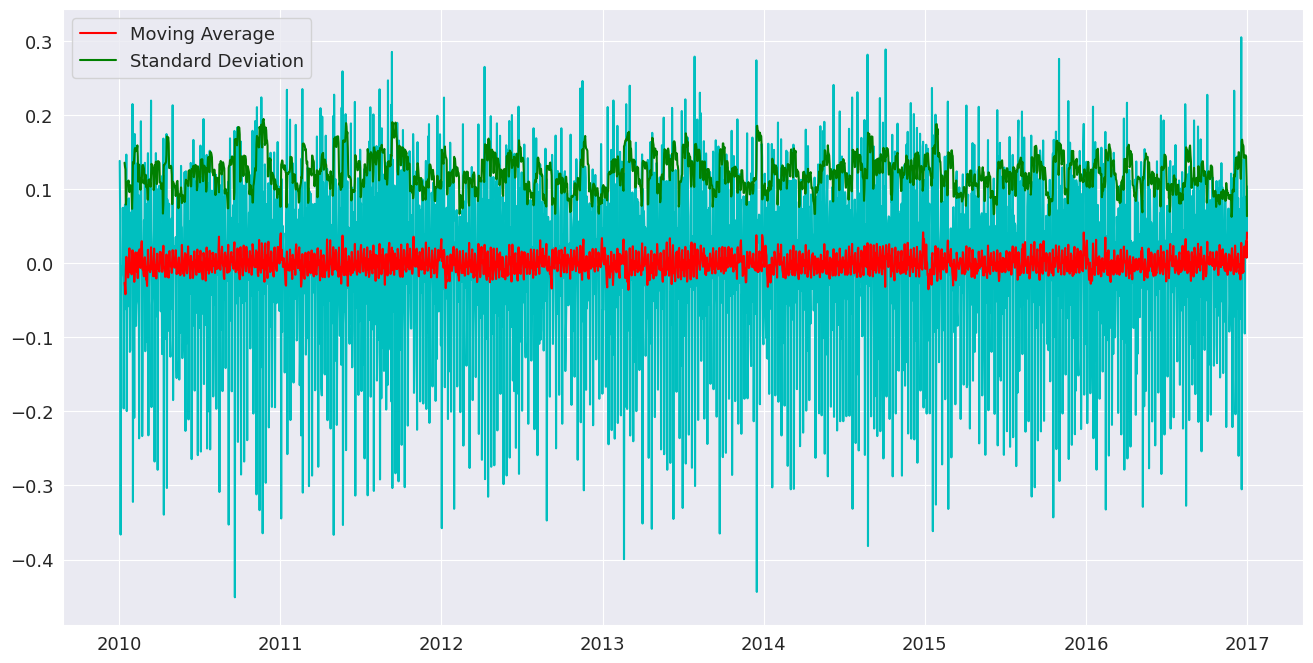

In [24]:
# Fixing the figure size
plt.figure(figsize = (16, 8))

df_shift = df_log - df_log.shift(periods = 1)

MAvg_shift = df_shift.rolling(window = 12).mean()

MStd_shift = df_shift.rolling(window = 12).std()

plt.plot(df_shift, color = 'c')

plt.plot(MAvg_shift, color = 'red', label = 'Moving Average')

plt.plot(MStd_shift, color = 'green', label = 'Standard Deviation')

plt.legend()

plt.show()

# Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

In [25]:
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic         -1.307443e+01
p-value                 1.927208e-24
Lags Used               2.700000e+01
No. of Observations     2.528000e+03
Critical Value (1%)    -3.432939e+00
Critical Value (5%)    -2.862684e+00
Critical Value (10%)   -2.567379e+00
dtype: float64


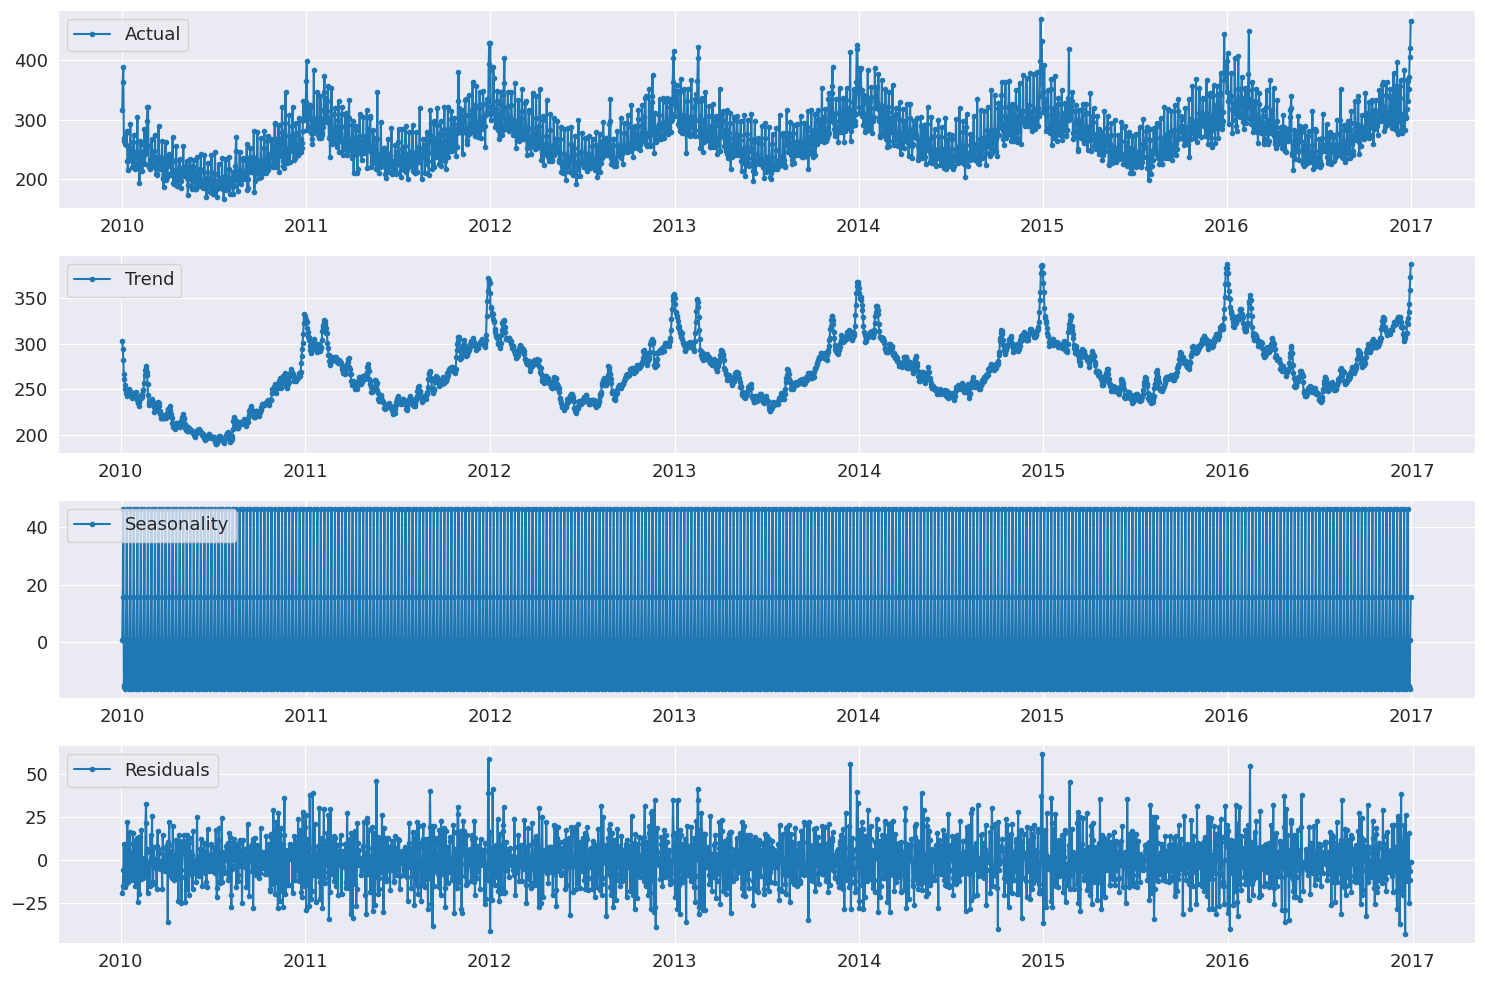

In [26]:
# Importing the seasonal_decompose to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df)

trend = decomp.trend

seasonal = decomp.seasonal

residual = decomp.resid

plt.figure(figsize = (15, 10))

plt.subplot(411)

plt.plot(df, label = 'Actual', marker = '.')

plt.legend(loc = 'upper left')

plt.subplot(412)

plt.plot(trend, label = 'Trend', marker = '.')

plt.legend(loc = 'upper left')

plt.subplot(413)

plt.plot(seasonal, label = 'Seasonality', marker = '.')

plt.legend(loc = 'upper left')

plt.subplot(414)

plt.plot(residual, label = 'Residuals', marker = '.')

plt.legend(loc = 'upper left')

plt.tight_layout()

<Figure size 1600x800 with 0 Axes>

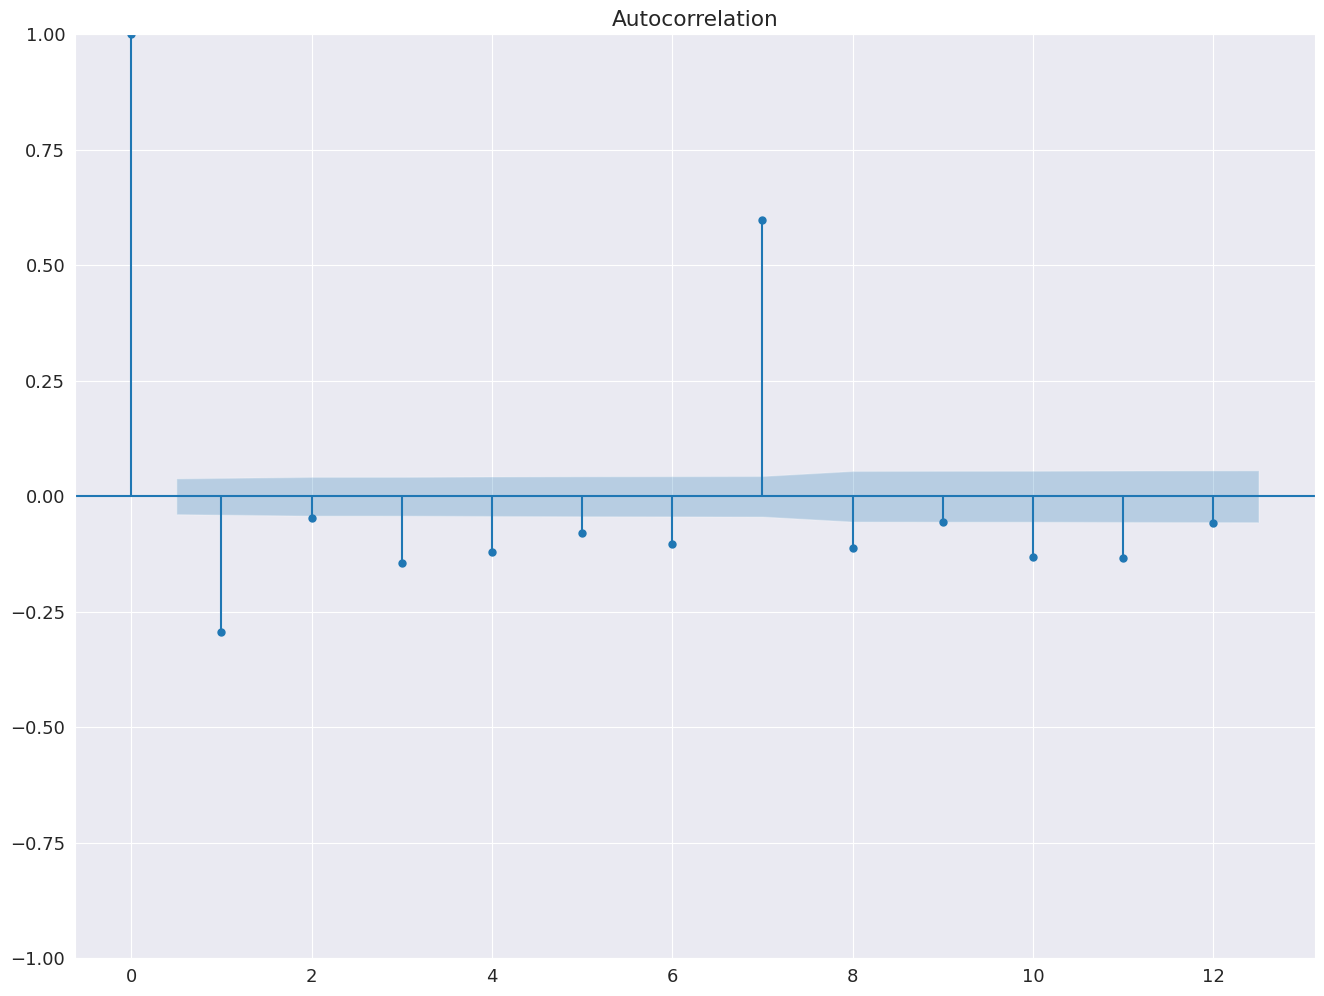

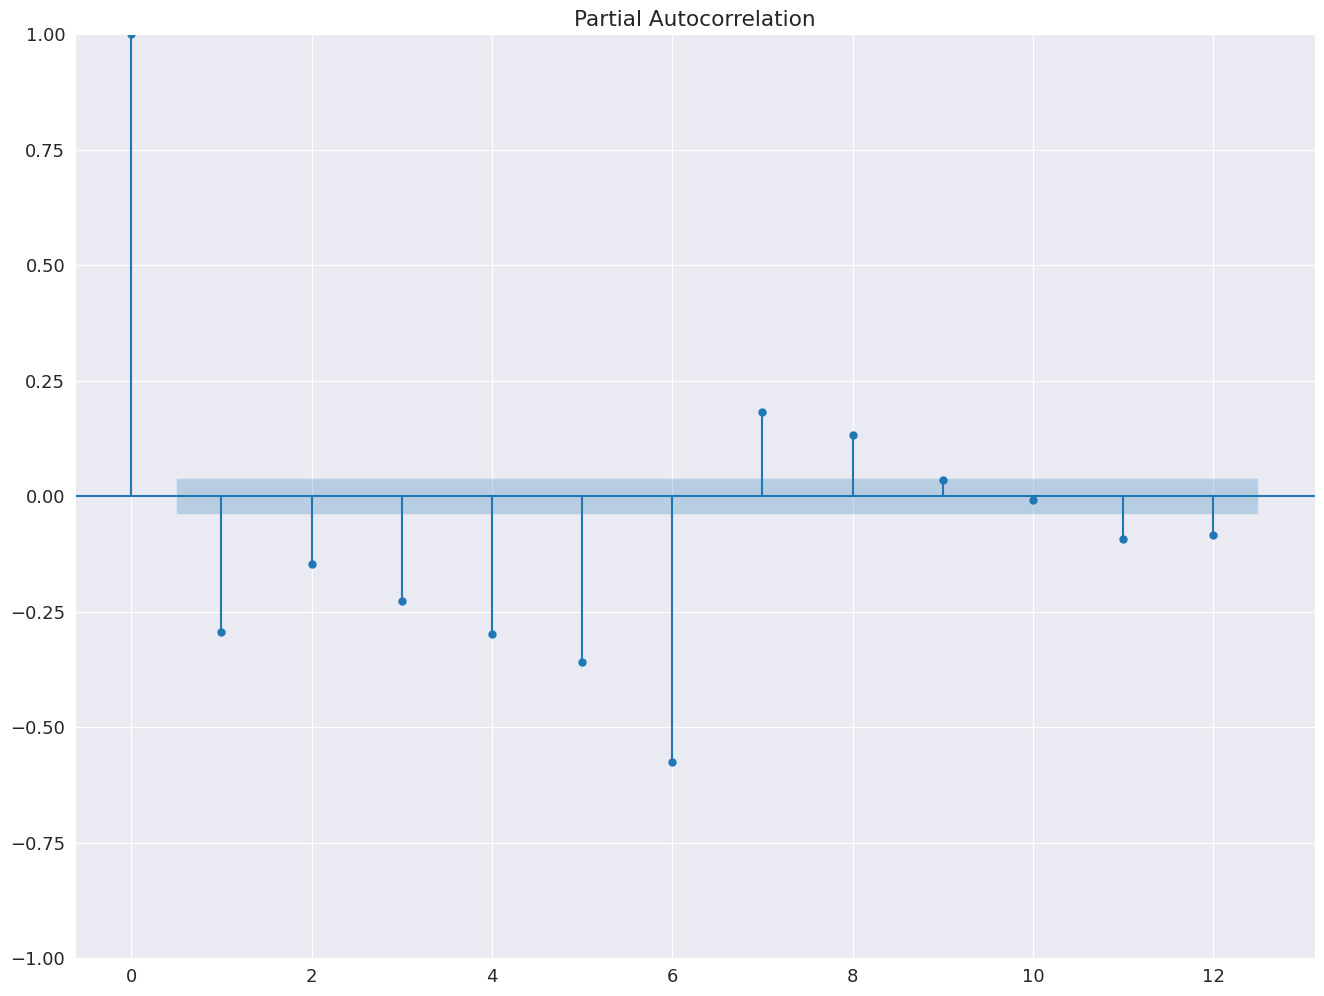

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (16, 8))

plot_acf(df_shift, lags = 12)

plt.show()

plot_pacf(df_shift, lags = 12)

plt.show()

In [28]:
train_df.drop(columns=[DATE], axis=1, inplace=True)
test_df.drop(columns=[DATE], axis=1, inplace=True)

In [29]:
cat_cols = [COUNTRY,STORE,PRODUCT]

from sklearn.preprocessing import LabelEncoder
label_encoders = {}  
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.fit_transform(test_df[col])
    label_encoders[col] = le

In [30]:
# treat for negative prediction
train_df[NUM_SOLD] = np.log1p(train_df[NUM_SOLD])

In [31]:
final_df = train_df
final_df.head()

,country,store,product,num_sold,Year,Quarter,Month,Week,Weekday,Christmas_and_New_Years,After_New_Years,Easter
id,,,,,,,,,,,,
1,0,0,1,6.881411,2010,1,1,0,1,10,0,0
2,0,0,2,6.810142,2010,1,1,0,1,10,0,0
3,0,0,3,6.049733,2010,1,1,0,1,10,0,0
4,0,0,4,6.198479,2010,1,1,0,1,10,0,0
6,0,2,1,7.516433,2010,1,1,0,1,10,0,0


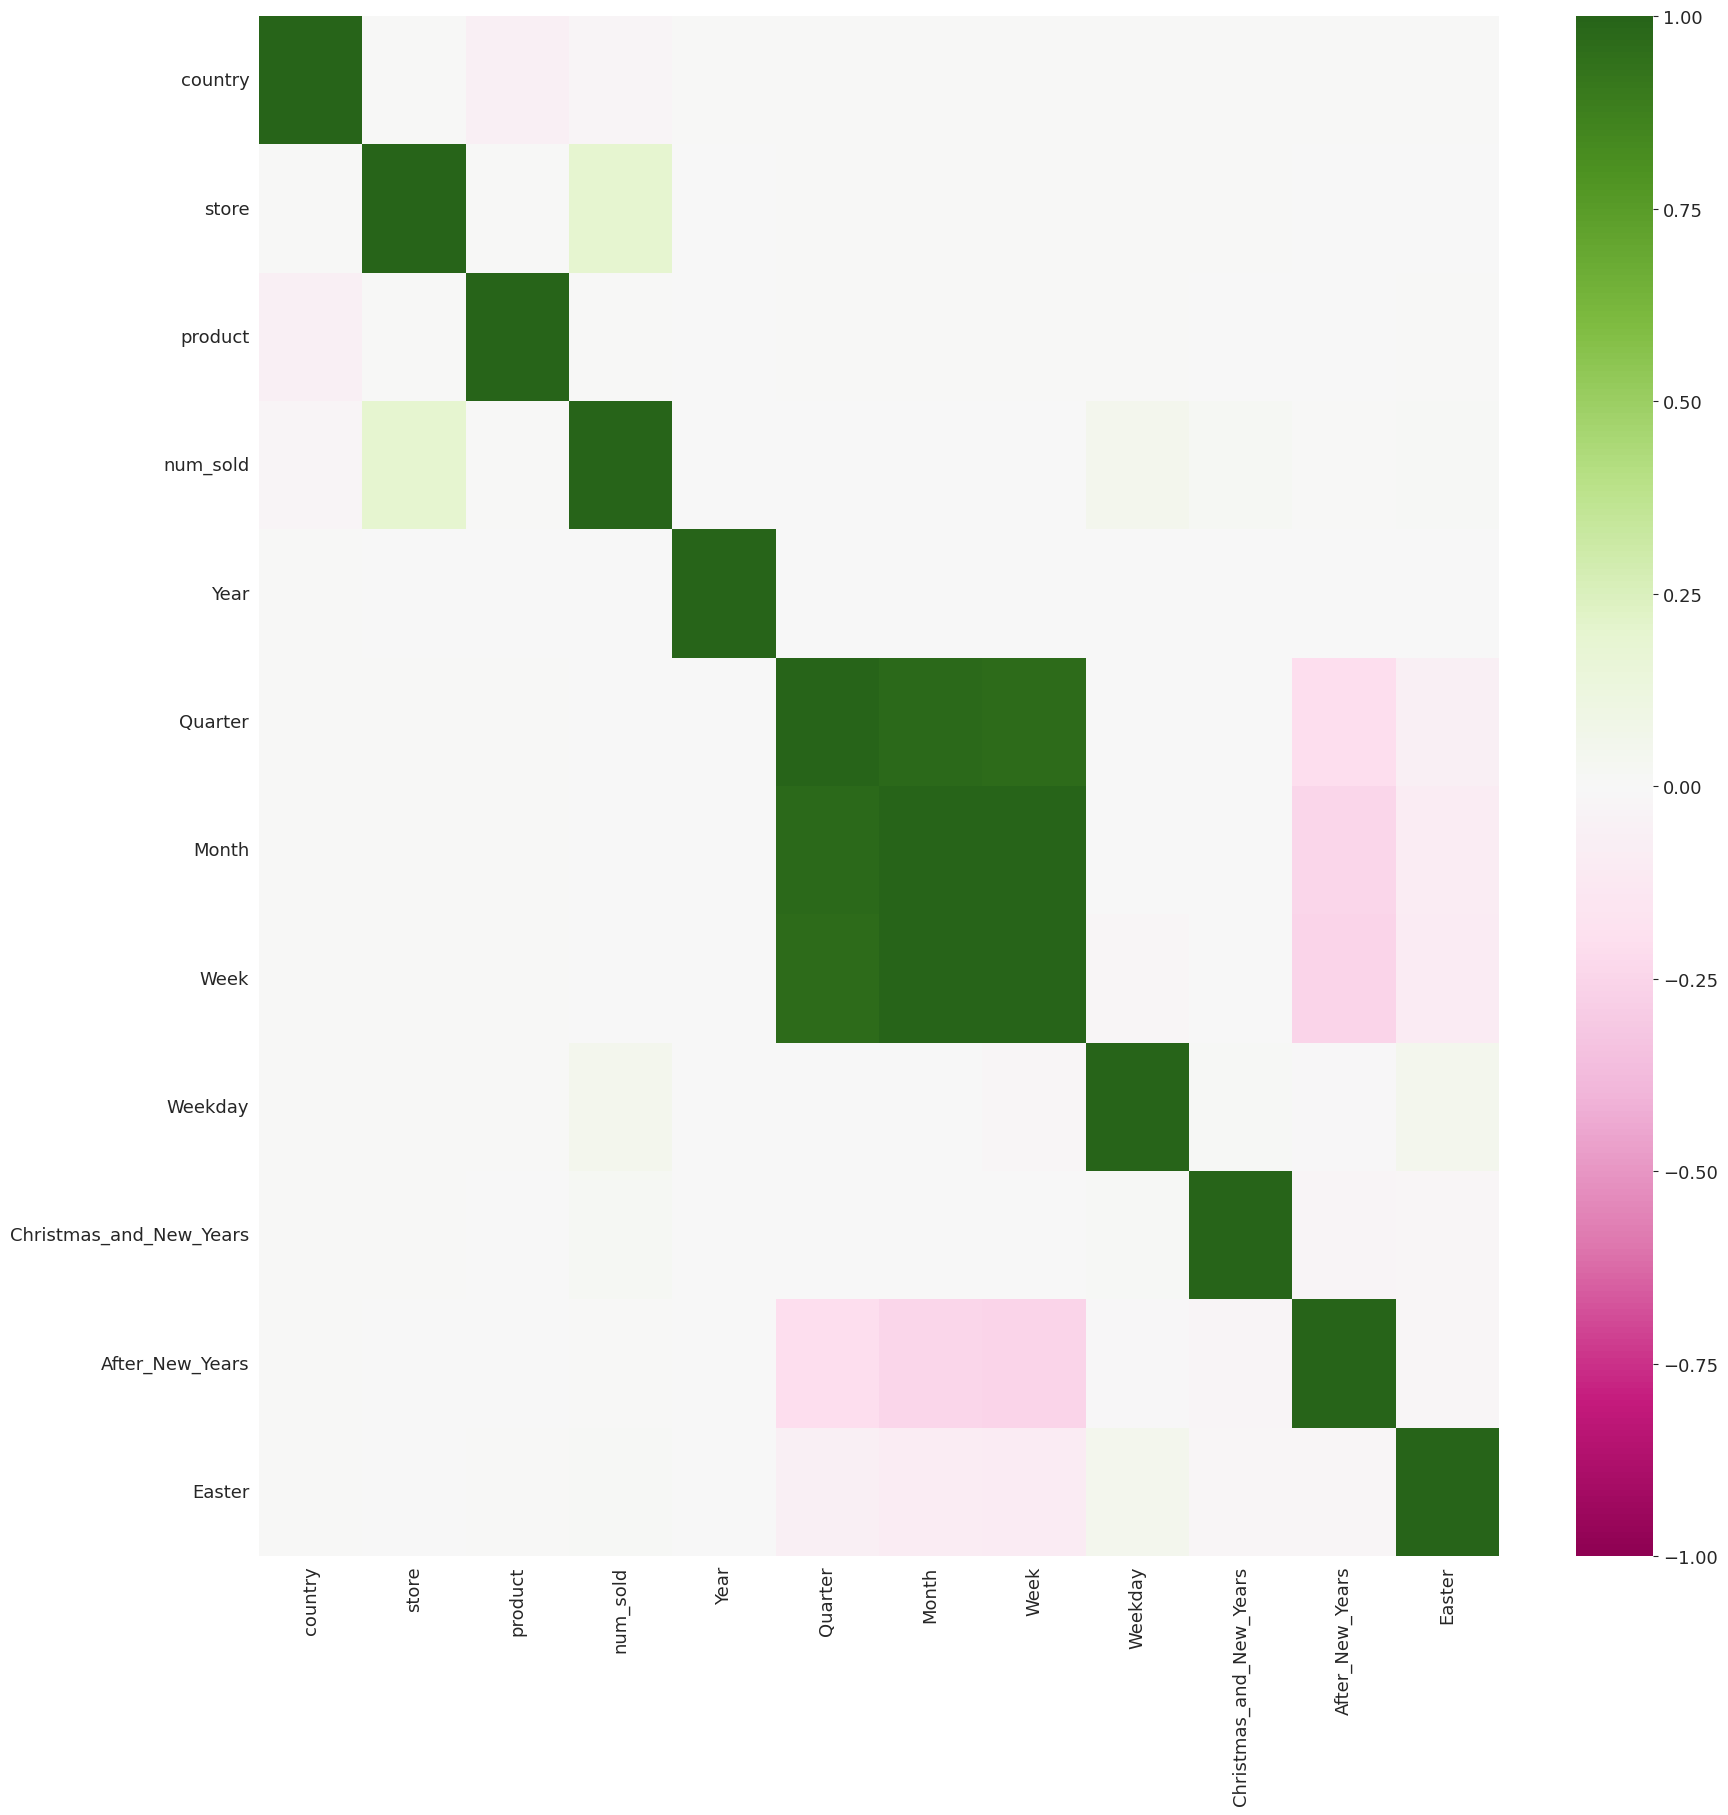

In [32]:
plt.figure(figsize  = (20, 20))

num_cols = final_df.select_dtypes(include = "number").columns.to_list()

sns.heatmap(final_df[num_cols].corr(), annot = False, vmin=-1, vmax=1, cmap = "PiYG")#cmap = "YlGnBu")

plt.show()

In [33]:
# Initialise the random number generator.
rng = np.random.default_rng(seed=7)

# Create train and test datasets
pcnt = .7

# Random state is a seed value
train = final_df.sample(frac = pcnt, random_state = 14)
test = final_df.drop(train.index)

columns = final_df.columns.to_list()
columns.remove(NUM_SOLD)

x_train = train[columns]
x_test = test[columns]

y_train = train[NUM_SOLD]
y_test = test[NUM_SOLD]

In [37]:
from xgboost import XGBRegressor # Had to lover the version of scikit-learn==1.5.2
#regressor = XGBRegressor(
#    n_estimators=2902,
#    learning_rate=0.04979561921487525,
#    max_depth=12,
#    reg_alpha=0.9230251060243451,
#    reg_lambda=0.07541479562519723,
#    min_child_weight=27,
#    colsample_bytree=0.7758849813234994,
#    subsample=0.9301705769755003,
#    random_state=42
#)
regressor = XGBRegressor()
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)

In [39]:
# Some tuning!
distributions = {
    'n_estimators': randint(10,5000),
    'learning_rate': uniform(0,1),
    'max_depth': randint(0,26),
    'reg_alpha': uniform(0,10),
    'reg_lambda': uniform(0,10),
    'min_child_weight': randint(0,50),
    'colsample_bytree': uniform(0,1),
    'subsample': uniform(0,1),
    'random_state': [1],
}
rgs = XGBRegressor()
# Random Search
rgs_tune = RandomizedSearchCV(estimator=rgs, param_distributions=distributions, n_iter=3000, cv=3, n_jobs=-1, random_state=1)
# to fit the data
rgs_tuned = rgs_tune.fit(x_train, y_train)  # Run this to finetune
print(f"Best Score: {rgs_tuned.best_score_}")
# and finally show the best parameters.
rgs_tuned.best_params_
#Best Score: 0.9986679931237221
#{'colsample_bytree': 0.7567770910287605,
# 'learning_rate': 0.07205767036873023,
# 'max_depth': 5,
# 'min_child_weight': 32,
# 'n_estimators': 3491,
# 'random_state': 1,
# 'reg_alpha': 0.7237703748256563,
# 'reg_lambda': 0.5270595548535351,
# 'subsample': 0.7288917779389558}
#3. Best Score: 0.9975617940055588
#{'booster': 'gbtree',
# 'colsample_bytree': 0.417022004702574,
# 'learning_rate': 0.7203244934421581,
# 'max_depth': 9,
# 'min_child_weight': 11,
# 'random_state': 1,
# 'reg_alpha': 9.990405153241447,
# 'reg_lambda': 2.3608897695197606,
# 'subsample': 0.3965807272960261}
#2. 0.9986766487337277
#{'colsample_bytree': 0.911839096499289,
# 'learning_rate': 0.035077508613630036,
# 'max_depth': 6,
# 'min_child_weight': 25,
# 'n_estimators': 4640,
# 'random_state': 1,
# 'reg_alpha': 0.8787591393066293,
# 'reg_lambda': 0.34910417787685966,
# 'subsample': 0.880703057412655}
# 1.
#{'colsample_bytree': 0.27993223838342884,
# 'learning_rate': 0.07924035857960192,
# 'max_depth': 12,
# 'min_child_weight': 9,
# 'n_estimators': 2860,
# 'random_state': 1,
# 'reg_alpha': 0.8959603628408364,
# 'reg_lambda': 0.892135872001881,
# 'subsample': 0.5775843411510946}

/home/eoh/.local/share/virtualenvs/Jupyter-TCFLM8mD/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Score: 0.9986679931237221


{'colsample_bytree': 0.7567770910287605,
 'learning_rate': 0.07205767036873023,
 'max_depth': 5,
 'min_child_weight': 32,
 'n_estimators': 3491,
 'random_state': 1,
 'reg_alpha': 0.7237703748256563,
 'reg_lambda': 0.5270595548535351,
 'subsample': 0.7288917779389558}

In [40]:
regressor = XGBRegressor(
    #booster='dart',
    n_estimators=3491,
    learning_rate=0.07205767036873023,
    max_depth=5,
    reg_alpha=0.7237703748256563,
    reg_lambda=0.5270595548535351,
    min_child_weight=32,
    colsample_bytree=0.7567770910287605,
    subsample=0.7288917779389558,
    random_state=1
)
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)

In [41]:
predictions = np.expm1(predictions)
y_test = np.expm1(y_test)

In [42]:
from sklearn.metrics import r2_score
print("R2 score:", r2_score(y_test,predictions))

R2 score: 0.9936916744809998


In [43]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt(mean_squared_log_error(y_test, predictions))
print("The score is %.5f" % RMSLE )

The score is 0.05319


# Prediction & Submission

In [ ]:
predictions = regressor.predict(test_df[columns])
predictions = np.expm1(predictions)

In [ ]:
submission = pd.DataFrame({
    ID: test_df.index,
    NUM_SOLD: predictions 
})

In [ ]:
submission.to_csv('submission.csv', index=False)
print("File Saved!")
print(submission.head())